## Image recoginition system for Identifying Healthy vs Rotten Fruits and Vegetables

Problem Statement
Context: Ensuring the quality of fruits and vegetables is critical in the food supply chain, from farms to retailers and ultimately to consumers. However, manual inspection methods are time-consuming, inconsistent, and prone to errors.
Issue: The inability to efficiently and accurately detect spoiled produce leads to significant food waste, impacts consumer health, and reduces retailer profitability.
Impact: Ineffective quality control systems result in the wastage of edible produce, higher operational costs, and a negative environmental footprint, highlighting the need for automated, scalable, and reliable solutions for detecting spoiled fruits and vegetables.

In [1]:
# Import necessary libraries
import os  # For handling file and directory operations
import shutil  # For file copying and directory management
from sklearn.model_selection import train_test_split  # For splitting datasets into train, test, and validation sets
from pyspark.sql import SparkSession, Row  # For creating and managing Spark DataFrames
import plotly.express as px  # For creating visualizations such as pie charts and bar charts
from pymongo import MongoClient  # For connecting to MongoDB
import gridfs  # For managing large files in MongoDB
from PIL import Image  # For handling image processing
import matplotlib.pyplot as plt  # For plotting images and graphs
import io  # For handling byte streams (used with image processing)

C:\Users\Dell\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## DATA STORAGE USING MONGODB

In [2]:
# Connecting to MongoDB
client = MongoClient("mongodb://localhost:27017/")
db = client["Fruits"]  # Database name
fs = gridfs.GridFS(db)  # Initialize GridFS for handling large files
print("MongoDB connection established.")

MongoDB connection established.


## SPARK SESSION

In [3]:
park = SparkSession.builder \
    .appName("FruitImageClassification") \
    .getOrCreate()
print("Spark Session initialized.")

Spark Session initialized.


The split_dataset function organizes a dataset into training, validation, and testing sets based on specified proportions. It identifies class folders within the dataset directory, processes each folder to split the images, and handles cases with very few images (<3) by assigning all to training. The split datasets are saved in structured subfolders (Training Data, Testing Data, Validation Data) under the specified output path, with necessary directories created dynamically. Each split image is copied to its corresponding folder, and the function logs progress for each class.








In [4]:
def split_dataset(dataset_path, output_path, test_size=0.2, val_size=0.1):
    """
    Splits a dataset into training, validation, and testing sets.

    Parameters:
    - dataset_path: Path to the root dataset folder.
    - output_path: Path to the folder where split data will be stored.
    - test_size: Proportion of the dataset to be used as the test set.
    - val_size: Proportion of the training data to be used as the validation set.
    """
    classes = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]
    
    for class_name in classes:
        class_path = os.path.join(dataset_path, class_name)
        images = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]

        if len(images) == 0:
            print(f"Skipping empty class folder: {class_name}")
            continue

        if len(images) < 3:
            print(f"Class '{class_name}' has only {len(images)} sample(s). Allocating all to training.")
            train_imgs, val_imgs, test_imgs = images, [], []
        else:
            # Split into train, test, and validation sets
            train_imgs, test_imgs = train_test_split(images, test_size=test_size, random_state=42)
            train_imgs, val_imgs = train_test_split(train_imgs, test_size=val_size / (1 - test_size), random_state=42)

        # Create output directories
        for split, split_imgs in zip(["Training Data", "Testing Data", "Validation Data"], [train_imgs, test_imgs, val_imgs]):
            split_class_path = os.path.join(output_path, split, class_name)
            os.makedirs(split_class_path, exist_ok=True)
            for img in split_imgs:
                shutil.copy(os.path.join(class_path, img), os.path.join(split_class_path, img))
        
        print(f"Processed class: {class_name}")

# Example usage
DATASET_PATH = r"C:/Users/Dell/Desktop/603-Project/dataset/Fruit And Vegetable Diseases Dataset"  
OUTPUT_PATH = r"C:/Users/Dell/Desktop/603-Project/dataset/"  

# Split the dataset
split_dataset(DATASET_PATH, OUTPUT_PATH)


Processed class: Apple__Healthy
Processed class: Apple__Rotten
Processed class: Banana__Healthy
Processed class: Banana__Rotten
Processed class: Bellpepper__Healthy
Processed class: Bellpepper__Rotten
Processed class: Carrot__Healthy
Processed class: Carrot__Rotten
Processed class: Cucumber__Healthy
Processed class: Cucumber__Rotten
Processed class: Grape__Healthy
Processed class: Grape__Rotten
Processed class: Guava__Healthy
Processed class: Guava__Rotten
Processed class: Jujube__Healthy
Processed class: Jujube__Rotten
Processed class: Mango__Healthy
Processed class: Mango__Rotten
Processed class: Orange__Healthy
Processed class: Orange__Rotten
Processed class: Pomegranate__Healthy
Processed class: Pomegranate__Rotten
Processed class: Potato__Healthy
Processed class: Potato__Rotten
Processed class: Strawberry__Healthy
Processed class: Strawberry__Rotten
Skipping empty class folder: Testing Data
Processed class: Tomato__Healthy
Processed class: Tomato__Rotten
Skipping empty class folde

## DATA VISUALIZATION

In [5]:
# Visualizing Dataset Distribution
def visualize_class_distribution(base_path):
    # Get class names and calculate distributions
    classes = [
        d for d in os.listdir(base_path)
        if os.path.isdir(os.path.join(base_path, d))
    ]
    class_distributions = [
        len(os.listdir(os.path.join(base_path, class_name)))
        if os.path.exists(os.path.join(base_path, class_name)) else 0
        for class_name in classes
    ]

    # Visualize with pie chart and bar chart
    fig = px.pie(names=classes, values=class_distributions, title="Class Distribution", hole=0.4)
    fig.update_layout({'title': {'x': 0.48}})
    fig.show()

    fig = px.bar(x=classes, y=class_distributions, title="Class Distribution")
    fig.update_layout({'title': {'x': 0.48}})
    fig.show()

# Visualizing the Training dataset distribution
visualize_class_distribution(os.path.join(DATASET_PATH, "Training Data"))

The create_spark_dataframe function constructs a Spark DataFrame for a specified dataset split (e.g., Training, Testing, or Validation) by reading the directory structure. It traverses through subfolders corresponding to class labels, collects image file paths along with their labels, and creates a distributed DataFrame with columns path (image file path) and label (class name). This DataFrame can be used for scalable data processing or machine learning tasks within a PySpark environment.

In [6]:
# Creating Spark DataFrames
def create_spark_dataframe(data_type, base_path):
    split_path = os.path.join(base_path, f"{data_type} Data")
    if not os.path.exists(split_path):
        print(f"Warning: Folder '{split_path}' does not exist.")
        return None

    data = []
    classes = [d for d in os.listdir(split_path) if os.path.isdir(os.path.join(split_path, d))]
    for class_name in classes:
        class_path = os.path.join(split_path, class_name)
        images = [os.path.join(class_path, img) for img in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, img))]
        for img in images:
            data.append(Row(path=img, label=class_name))
    
    return spark.createDataFrame(data)


This code initializes a PySpark session and connects to a MongoDB database using the pymongo library. It defines a function, create_spark_dataframe, to load image paths and class labels into Spark DataFrames for training, validation, and testing datasets. The DataFrames are created from a specified dataset directory structure. The code then uploads the images to MongoDB's GridFS for storage, checking for duplicate files before uploading, and storing metadata (file name and class) in a separate MongoDB collection. The process ensures that only unique images are uploaded and metadata is managed efficiently.

In [7]:
from pyspark.sql import SparkSession, Row
import os
from pymongo import MongoClient
import gridfs

# Initialize Spark Session
spark = SparkSession.builder \
    .appName("Image Processing") \
    .config("spark.executor.memory", "8g") \
    .getOrCreate()

# MongoDB connection
client = MongoClient("mongodb://localhost:27017/")
db = client.image_database
fs = gridfs.GridFS(db)

# Define the path to the dataset
DATASET_PATH = "C:/Users/Dell/Desktop/603-Project/dataset/Fruit And Vegetable Diseases Dataset"

# Function to create Spark DataFrame
def create_spark_dataframe(data_type, base_path):
    data = []
    data_path = os.path.join(base_path, data_type)
    classes = [d for d in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, d))]
    for class_name in classes:
        class_path = os.path.join(data_path, class_name)
        images = [os.path.join(class_path, img) for img in os.listdir(class_path)]
        for img in images:
            data.append(Row(path=img, label=class_name))
    return spark.createDataFrame(data)

# Create Spark DataFrames for Training, Validation, and Testing
train_images_df = create_spark_dataframe("Training Data", DATASET_PATH)
validation_images_df = create_spark_dataframe("Validation Data", DATASET_PATH)
test_images_df = create_spark_dataframe("Testing Data", DATASET_PATH)

# Show DataFrame schemas
if train_images_df:
    print("Training Data Schema:")
    train_images_df.printSchema()

if validation_images_df:
    print("Validation Data Schema:")
    validation_images_df.printSchema()

if test_images_df:
    print("Testing Data Schema:")
    test_images_df.printSchema()

# Upload images to MongoDB GridFS
def upload_images_to_gridfs():
    for data_type in ["Training Data", "Validation Data", "Testing Data"]:
        split_path = os.path.join(DATASET_PATH, data_type)
        classes = [d for d in os.listdir(split_path) if os.path.isdir(os.path.join(split_path, d))]
        for class_name in classes:
            class_path = os.path.join(split_path, class_name)
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                try:
                    # Check for duplicate metadata
                    existing_entry = db.image_metadata.find_one({"filename": img_name, "class_name": class_name})
                    if existing_entry is None:
                        with open(img_path, "rb") as img_file:
                            # Save file to GridFS
                            file_id = fs.put(img_file, filename=img_name, class_name=class_name)
                            db.image_metadata.insert_one({"file_id": file_id, "filename": img_name, "class_name": class_name})
                        print(f"Uploaded: {img_name} in class {class_name}")
                    else:
                        print(f"Skipped (already exists): {img_name}")
                except Exception as e:
                    print(f"Error uploading {img_name} in class {class_name}: {e}")

# Call the function to upload images
upload_images_to_gridfs()


Training Data Schema:
root
 |-- path: string (nullable = true)
 |-- label: string (nullable = true)

Validation Data Schema:
root
 |-- path: string (nullable = true)
 |-- label: string (nullable = true)

Testing Data Schema:
root
 |-- path: string (nullable = true)
 |-- label: string (nullable = true)

Skipped (already exists): FreshApple (1).jpg
Skipped (already exists): freshApple (1).png
Skipped (already exists): FreshApple (10).jpg
Skipped (already exists): FreshApple (100).jpg
Skipped (already exists): FreshApple (101).jpg
Skipped (already exists): FreshApple (102).jpg
Skipped (already exists): FreshApple (104).jpg
Skipped (already exists): FreshApple (105).jpg
Skipped (already exists): FreshApple (106).jpg
Skipped (already exists): FreshApple (107).jpg
Skipped (already exists): FreshApple (108).jpg
Skipped (already exists): FreshApple (109).jpg
Skipped (already exists): FreshApple (110).jpg
Skipped (already exists): FreshApple (111).jpg
Skipped (already exists): FreshApple (112).

Skipped (already exists): freshApple (433).png
Skipped (already exists): freshApple (434).png
Skipped (already exists): freshApple (435).png
Skipped (already exists): freshApple (436).png
Skipped (already exists): freshApple (437).png
Skipped (already exists): freshApple (438).png
Skipped (already exists): FreshApple (44).jpg
Skipped (already exists): freshApple (442).png
Skipped (already exists): freshApple (444).png
Skipped (already exists): freshApple (446).png
Skipped (already exists): freshApple (449).png
Skipped (already exists): FreshApple (45).jpg
Skipped (already exists): freshApple (450).png
Skipped (already exists): freshApple (452).png
Skipped (already exists): freshApple (453).png
Skipped (already exists): freshApple (457).png
Skipped (already exists): freshApple (458).png
Skipped (already exists): freshApple (459).png
Skipped (already exists): FreshApple (46).jpg
Skipped (already exists): freshApple (461).png
Skipped (already exists): freshApple (462).png
Skipped (already

Skipped (already exists): freshApple (817).png
Skipped (already exists): freshApple (820).png
Skipped (already exists): freshApple (821).png
Skipped (already exists): freshApple (822).png
Skipped (already exists): freshApple (823).png
Skipped (already exists): freshApple (825).png
Skipped (already exists): freshApple (826).png
Skipped (already exists): freshApple (827).png
Skipped (already exists): freshApple (828).png
Skipped (already exists): FreshApple (83).jpg
Skipped (already exists): freshApple (831).png
Skipped (already exists): freshApple (832).png
Skipped (already exists): freshApple (833).png
Skipped (already exists): freshApple (834).png
Skipped (already exists): freshApple (835).png
Skipped (already exists): freshApple (836).png
Skipped (already exists): freshApple (837).png
Skipped (already exists): freshApple (838).png
Skipped (already exists): freshApple (839).png
Skipped (already exists): FreshApple (84).jpg
Skipped (already exists): freshApple (840).png
Skipped (alread

Skipped (already exists): rotated_by_30_Screen Shot 2018-06-08 at 5.10.29 PM.png
Skipped (already exists): rotated_by_30_Screen Shot 2018-06-08 at 5.11.02 PM.png
Skipped (already exists): rotated_by_30_Screen Shot 2018-06-08 at 5.11.08 PM.png
Skipped (already exists): rotated_by_30_Screen Shot 2018-06-08 at 5.11.16 PM.png
Skipped (already exists): rotated_by_30_Screen Shot 2018-06-08 at 5.11.52 PM.png
Skipped (already exists): rotated_by_30_Screen Shot 2018-06-08 at 5.11.59 PM.png
Skipped (already exists): rotated_by_30_Screen Shot 2018-06-08 at 5.12.14 PM.png
Skipped (already exists): rotated_by_30_Screen Shot 2018-06-08 at 5.12.20 PM.png
Skipped (already exists): rotated_by_30_Screen Shot 2018-06-08 at 5.12.29 PM.png
Skipped (already exists): rotated_by_30_Screen Shot 2018-06-08 at 5.12.41 PM.png
Skipped (already exists): rotated_by_30_Screen Shot 2018-06-08 at 5.12.47 PM.png
Skipped (already exists): rotated_by_30_Screen Shot 2018-06-08 at 5.12.56 PM.png
Skipped (already exists): ro

Skipped (already exists): rotated_by_45_Screen Shot 2018-06-08 at 5.09.31 PM.png
Skipped (already exists): rotated_by_45_Screen Shot 2018-06-08 at 5.09.40 PM.png
Skipped (already exists): rotated_by_45_Screen Shot 2018-06-08 at 5.09.47 PM.png
Skipped (already exists): rotated_by_45_Screen Shot 2018-06-08 at 5.09.54 PM.png
Skipped (already exists): rotated_by_45_Screen Shot 2018-06-08 at 5.10.21 PM.png
Skipped (already exists): rotated_by_45_Screen Shot 2018-06-08 at 5.10.29 PM.png
Skipped (already exists): rotated_by_45_Screen Shot 2018-06-08 at 5.10.53 PM.png
Skipped (already exists): rotated_by_45_Screen Shot 2018-06-08 at 5.11.02 PM.png
Skipped (already exists): rotated_by_45_Screen Shot 2018-06-08 at 5.11.35 PM.png
Skipped (already exists): rotated_by_45_Screen Shot 2018-06-08 at 5.11.52 PM.png
Skipped (already exists): rotated_by_45_Screen Shot 2018-06-08 at 5.12.14 PM.png
Skipped (already exists): rotated_by_45_Screen Shot 2018-06-08 at 5.12.20 PM.png
Skipped (already exists): ro

Skipped (already exists): rotated_by_60_Screen Shot 2018-06-08 at 5.05.06 PM.png
Skipped (already exists): rotated_by_60_Screen Shot 2018-06-08 at 5.05.27 PM.png
Skipped (already exists): rotated_by_60_Screen Shot 2018-06-08 at 5.05.48 PM.png
Skipped (already exists): rotated_by_60_Screen Shot 2018-06-08 at 5.06.19 PM.png
Skipped (already exists): rotated_by_60_Screen Shot 2018-06-08 at 5.06.33 PM.png
Skipped (already exists): rotated_by_60_Screen Shot 2018-06-08 at 5.06.47 PM.png
Skipped (already exists): rotated_by_60_Screen Shot 2018-06-08 at 5.07.05 PM.png
Skipped (already exists): rotated_by_60_Screen Shot 2018-06-08 at 5.07.26 PM.png
Skipped (already exists): rotated_by_60_Screen Shot 2018-06-08 at 5.09.03 PM.png
Skipped (already exists): rotated_by_60_Screen Shot 2018-06-08 at 5.09.10 PM.png
Skipped (already exists): rotated_by_60_Screen Shot 2018-06-08 at 5.09.25 PM.png
Skipped (already exists): rotated_by_60_Screen Shot 2018-06-08 at 5.09.31 PM.png
Skipped (already exists): ro

Skipped (already exists): rotated_by_60_Screen Shot 2018-06-08 at 5.33.18 PM.png
Skipped (already exists): rotated_by_60_Screen Shot 2018-06-08 at 5.33.27 PM.png
Skipped (already exists): rotated_by_60_Screen Shot 2018-06-08 at 5.33.55 PM.png
Skipped (already exists): rotated_by_60_Screen Shot 2018-06-08 at 5.34.14 PM.png
Skipped (already exists): rotated_by_75_Screen Shot 2018-06-08 at 4.59.44 PM.png
Skipped (already exists): rotated_by_75_Screen Shot 2018-06-08 at 4.59.49 PM.png
Skipped (already exists): rotated_by_75_Screen Shot 2018-06-08 at 4.59.57 PM.png
Skipped (already exists): rotated_by_75_Screen Shot 2018-06-08 at 5.00.18 PM.png
Skipped (already exists): rotated_by_75_Screen Shot 2018-06-08 at 5.00.43 PM.png
Skipped (already exists): rotated_by_75_Screen Shot 2018-06-08 at 5.01.08 PM.png
Skipped (already exists): rotated_by_75_Screen Shot 2018-06-08 at 5.01.22 PM.png
Skipped (already exists): rotated_by_75_Screen Shot 2018-06-08 at 5.01.34 PM.png
Skipped (already exists): ro

Skipped (already exists): saltandpepper_Screen Shot 2018-06-08 at 5.07.52 PM.png
Skipped (already exists): saltandpepper_Screen Shot 2018-06-08 at 5.08.37 PM.png
Skipped (already exists): saltandpepper_Screen Shot 2018-06-08 at 5.08.58 PM.png
Skipped (already exists): saltandpepper_Screen Shot 2018-06-08 at 5.09.10 PM.png
Skipped (already exists): saltandpepper_Screen Shot 2018-06-08 at 5.09.17 PM.png
Skipped (already exists): saltandpepper_Screen Shot 2018-06-08 at 5.09.31 PM.png
Skipped (already exists): saltandpepper_Screen Shot 2018-06-08 at 5.09.47 PM.png
Skipped (already exists): saltandpepper_Screen Shot 2018-06-08 at 5.09.54 PM.png
Skipped (already exists): saltandpepper_Screen Shot 2018-06-08 at 5.10.03 PM.png
Skipped (already exists): saltandpepper_Screen Shot 2018-06-08 at 5.10.29 PM.png
Skipped (already exists): saltandpepper_Screen Shot 2018-06-08 at 5.10.43 PM.png
Skipped (already exists): saltandpepper_Screen Shot 2018-06-08 at 5.10.53 PM.png
Skipped (already exists): sa

Skipped (already exists): Screen Shot 2018-06-08 at 5.14.48 PM.png
Skipped (already exists): Screen Shot 2018-06-08 at 5.14.56 PM.png
Skipped (already exists): Screen Shot 2018-06-08 at 5.15.01 PM.png
Skipped (already exists): Screen Shot 2018-06-08 at 5.15.21 PM.png
Skipped (already exists): Screen Shot 2018-06-08 at 5.15.34 PM.png
Skipped (already exists): Screen Shot 2018-06-08 at 5.15.39 PM.png
Skipped (already exists): Screen Shot 2018-06-08 at 5.16.16 PM.png
Skipped (already exists): Screen Shot 2018-06-08 at 5.16.33 PM.png
Skipped (already exists): Screen Shot 2018-06-08 at 5.16.49 PM.png
Skipped (already exists): Screen Shot 2018-06-08 at 5.16.57 PM.png
Skipped (already exists): Screen Shot 2018-06-08 at 5.17.04 PM.png
Skipped (already exists): Screen Shot 2018-06-08 at 5.17.10 PM.png
Skipped (already exists): Screen Shot 2018-06-08 at 5.17.22 PM.png
Skipped (already exists): Screen Shot 2018-06-08 at 5.17.42 PM.png
Skipped (already exists): Screen Shot 2018-06-08 at 5.18.12 PM

Skipped (already exists): translation_Screen Shot 2018-06-08 at 5.21.22 PM.png
Skipped (already exists): translation_Screen Shot 2018-06-08 at 5.21.31 PM.png
Skipped (already exists): translation_Screen Shot 2018-06-08 at 5.21.35 PM.png
Skipped (already exists): translation_Screen Shot 2018-06-08 at 5.21.44 PM.png
Skipped (already exists): translation_Screen Shot 2018-06-08 at 5.22.15 PM.png
Skipped (already exists): translation_Screen Shot 2018-06-08 at 5.22.27 PM.png
Skipped (already exists): translation_Screen Shot 2018-06-08 at 5.22.35 PM.png
Skipped (already exists): translation_Screen Shot 2018-06-08 at 5.22.48 PM.png
Skipped (already exists): translation_Screen Shot 2018-06-08 at 5.22.58 PM.png
Skipped (already exists): translation_Screen Shot 2018-06-08 at 5.23.07 PM.png
Skipped (already exists): translation_Screen Shot 2018-06-08 at 5.23.14 PM.png
Skipped (already exists): translation_Screen Shot 2018-06-08 at 5.23.23 PM.png
Skipped (already exists): translation_Screen Shot 20

Skipped (already exists): vertical_flip_Screen Shot 2018-06-08 at 5.24.12 PM.png
Skipped (already exists): vertical_flip_Screen Shot 2018-06-08 at 5.24.19 PM.png
Skipped (already exists): vertical_flip_Screen Shot 2018-06-08 at 5.24.26 PM.png
Skipped (already exists): vertical_flip_Screen Shot 2018-06-08 at 5.24.35 PM.png
Skipped (already exists): vertical_flip_Screen Shot 2018-06-08 at 5.25.02 PM.png
Skipped (already exists): vertical_flip_Screen Shot 2018-06-08 at 5.25.22 PM.png
Skipped (already exists): vertical_flip_Screen Shot 2018-06-08 at 5.25.28 PM.png
Skipped (already exists): vertical_flip_Screen Shot 2018-06-08 at 5.25.33 PM.png
Skipped (already exists): vertical_flip_Screen Shot 2018-06-08 at 5.25.37 PM.png
Skipped (already exists): vertical_flip_Screen Shot 2018-06-08 at 5.25.49 PM.png
Skipped (already exists): vertical_flip_Screen Shot 2018-06-08 at 5.26.05 PM.png
Skipped (already exists): vertical_flip_Screen Shot 2018-06-08 at 5.26.19 PM.png
Skipped (already exists): ve

Skipped (already exists): rotated_by_15_Screen Shot 2018-06-08 at 2.35.03 PM.png
Skipped (already exists): rotated_by_15_Screen Shot 2018-06-08 at 2.35.10 PM.png
Skipped (already exists): rotated_by_15_Screen Shot 2018-06-08 at 2.35.25 PM.png
Skipped (already exists): rotated_by_15_Screen Shot 2018-06-08 at 2.35.32 PM.png
Skipped (already exists): rotated_by_15_Screen Shot 2018-06-08 at 2.36.01 PM.png
Skipped (already exists): rotated_by_15_Screen Shot 2018-06-08 at 2.36.18 PM.png
Skipped (already exists): rotated_by_15_Screen Shot 2018-06-08 at 2.36.23 PM.png
Skipped (already exists): rotated_by_15_Screen Shot 2018-06-08 at 2.36.55 PM.png
Skipped (already exists): rotated_by_15_Screen Shot 2018-06-08 at 2.37.03 PM.png
Skipped (already exists): rotated_by_15_Screen Shot 2018-06-08 at 2.37.19 PM.png
Skipped (already exists): rotated_by_15_Screen Shot 2018-06-08 at 2.38.08 PM.png
Skipped (already exists): rotated_by_15_Screen Shot 2018-06-08 at 2.38.54 PM.png
Skipped (already exists): ro

Skipped (already exists): rotated_by_30_Screen Shot 2018-06-07 at 3.03.58 PM.png
Skipped (already exists): rotated_by_30_Screen Shot 2018-06-07 at 3.04.04 PM.png
Skipped (already exists): rotated_by_30_Screen Shot 2018-06-07 at 3.04.10 PM.png
Skipped (already exists): rotated_by_30_Screen Shot 2018-06-07 at 3.04.24 PM.png
Skipped (already exists): rotated_by_30_Screen Shot 2018-06-07 at 3.04.47 PM.png
Skipped (already exists): rotated_by_30_Screen Shot 2018-06-07 at 3.05.05 PM.png
Skipped (already exists): rotated_by_30_Screen Shot 2018-06-07 at 3.05.13 PM.png
Skipped (already exists): rotated_by_30_Screen Shot 2018-06-07 at 3.06.11 PM.png
Skipped (already exists): rotated_by_30_Screen Shot 2018-06-07 at 3.06.22 PM.png
Skipped (already exists): rotated_by_30_Screen Shot 2018-06-07 at 3.06.30 PM.png
Skipped (already exists): rotated_by_30_Screen Shot 2018-06-08 at 2.23.40 PM.png
Skipped (already exists): rotated_by_30_Screen Shot 2018-06-08 at 2.24.37 PM.png
Skipped (already exists): ro

Skipped (already exists): rotated_by_45_Screen Shot 2018-06-07 at 2.52.22 PM.png
Skipped (already exists): rotated_by_45_Screen Shot 2018-06-07 at 2.52.30 PM.png
Skipped (already exists): rotated_by_45_Screen Shot 2018-06-07 at 2.53.57 PM.png
Skipped (already exists): rotated_by_45_Screen Shot 2018-06-07 at 2.54.08 PM.png
Skipped (already exists): rotated_by_45_Screen Shot 2018-06-07 at 2.54.41 PM.png
Skipped (already exists): rotated_by_45_Screen Shot 2018-06-07 at 2.54.49 PM.png
Skipped (already exists): rotated_by_45_Screen Shot 2018-06-07 at 2.54.58 PM.png
Skipped (already exists): rotated_by_45_Screen Shot 2018-06-07 at 2.55.27 PM.png
Skipped (already exists): rotated_by_45_Screen Shot 2018-06-07 at 2.56.09 PM.png
Skipped (already exists): rotated_by_45_Screen Shot 2018-06-07 at 2.56.16 PM.png
Skipped (already exists): rotated_by_45_Screen Shot 2018-06-07 at 2.56.47 PM.png
Skipped (already exists): rotated_by_45_Screen Shot 2018-06-07 at 2.57.05 PM.png
Skipped (already exists): ro

Skipped (already exists): rotated_by_60_Screen Shot 2018-06-07 at 2.37.11 PM.png
Skipped (already exists): rotated_by_60_Screen Shot 2018-06-07 at 2.37.53 PM.png
Skipped (already exists): rotated_by_60_Screen Shot 2018-06-07 at 2.38.13 PM.png
Skipped (already exists): rotated_by_60_Screen Shot 2018-06-07 at 2.38.28 PM.png
Skipped (already exists): rotated_by_60_Screen Shot 2018-06-07 at 2.38.49 PM.png
Skipped (already exists): rotated_by_60_Screen Shot 2018-06-07 at 2.38.59 PM.png
Skipped (already exists): rotated_by_60_Screen Shot 2018-06-07 at 2.39.20 PM.png
Skipped (already exists): rotated_by_60_Screen Shot 2018-06-07 at 2.39.26 PM.png
Skipped (already exists): rotated_by_60_Screen Shot 2018-06-07 at 2.39.35 PM.png
Skipped (already exists): rotated_by_60_Screen Shot 2018-06-07 at 2.39.44 PM.png
Skipped (already exists): rotated_by_60_Screen Shot 2018-06-07 at 2.39.53 PM.png
Skipped (already exists): rotated_by_60_Screen Shot 2018-06-07 at 2.40.00 PM.png
Skipped (already exists): ro

Skipped (already exists): rotated_by_60_Screen Shot 2018-06-08 at 2.42.58 PM.png
Skipped (already exists): rotated_by_60_Screen Shot 2018-06-08 at 2.43.29 PM.png
Skipped (already exists): rotated_by_60_Screen Shot 2018-06-08 at 2.44.54 PM.png
Skipped (already exists): rotated_by_60_Screen Shot 2018-06-08 at 2.45.58 PM.png
Skipped (already exists): rotated_by_60_Screen Shot 2018-06-08 at 2.46.36 PM.png
Skipped (already exists): rotated_by_60_Screen Shot 2018-06-08 at 2.46.44 PM.png
Skipped (already exists): rotated_by_60_Screen Shot 2018-06-08 at 2.47.30 PM.png
Skipped (already exists): rotated_by_60_Screen Shot 2018-06-08 at 2.47.37 PM.png
Skipped (already exists): rotated_by_60_Screen Shot 2018-06-08 at 2.47.54 PM.png
Skipped (already exists): rotated_by_60_Screen Shot 2018-06-08 at 2.48.00 PM.png
Skipped (already exists): rotated_by_60_Screen Shot 2018-06-08 at 2.48.15 PM.png
Skipped (already exists): rotated_by_60_Screen Shot 2018-06-08 at 2.48.29 PM.png
Skipped (already exists): ro

Skipped (already exists): rotated_by_75_Screen Shot 2018-06-08 at 2.35.03 PM.png
Skipped (already exists): rotated_by_75_Screen Shot 2018-06-08 at 2.35.10 PM.png
Skipped (already exists): rotated_by_75_Screen Shot 2018-06-08 at 2.35.25 PM.png
Skipped (already exists): rotated_by_75_Screen Shot 2018-06-08 at 2.35.32 PM.png
Skipped (already exists): rotated_by_75_Screen Shot 2018-06-08 at 2.36.01 PM.png
Skipped (already exists): rotated_by_75_Screen Shot 2018-06-08 at 2.36.18 PM.png
Skipped (already exists): rotated_by_75_Screen Shot 2018-06-08 at 2.36.43 PM.png
Skipped (already exists): rotated_by_75_Screen Shot 2018-06-08 at 2.37.03 PM.png
Skipped (already exists): rotated_by_75_Screen Shot 2018-06-08 at 2.37.19 PM.png
Skipped (already exists): rotated_by_75_Screen Shot 2018-06-08 at 2.37.53 PM.png
Skipped (already exists): rotated_by_75_Screen Shot 2018-06-08 at 2.38.47 PM.png
Skipped (already exists): rotated_by_75_Screen Shot 2018-06-08 at 2.39.02 PM.png
Skipped (already exists): ro

Skipped (already exists): rottenApple (319).jpg
Skipped (already exists): rottenApple (32).jpg
Skipped (already exists): rottenApple (321).jpg
Skipped (already exists): rottenApple (322).jpg
Skipped (already exists): rottenApple (323).jpg
Skipped (already exists): rottenApple (324).jpg
Skipped (already exists): rottenApple (325).jpg
Skipped (already exists): rottenApple (327).jpg
Skipped (already exists): rottenApple (329).jpg
Skipped (already exists): rottenApple (33).jpg
Skipped (already exists): rottenApple (330).jpg
Skipped (already exists): rottenApple (333).jpg
Skipped (already exists): rottenApple (334).jpg
Skipped (already exists): rottenApple (335).jpg
Skipped (already exists): rottenApple (336).jpg
Skipped (already exists): rottenApple (338).jpg
Skipped (already exists): rottenApple (339).jpg
Skipped (already exists): rottenApple (34).jpg
Skipped (already exists): rottenApple (340).jpg
Skipped (already exists): rottenApple (341).jpg
Skipped (already exists): rottenApple (343)

Skipped (already exists): rottenApple (60).jpg
Skipped (already exists): rottenApple (66).jpg
Skipped (already exists): rottenApple (67).jpg
Skipped (already exists): rottenApple (68).jpg
Skipped (already exists): rottenApple (69).jpg
Skipped (already exists): rottenApple (7).jpg
Skipped (already exists): rottenApple (71).jpg
Skipped (already exists): rottenApple (73).jpg
Skipped (already exists): rottenApple (74).jpg
Skipped (already exists): rottenApple (75).jpg
Skipped (already exists): rottenApple (76).jpg
Skipped (already exists): rottenApple (77).jpg
Skipped (already exists): rottenApple (78).jpg
Skipped (already exists): rottenApple (79).jpg
Skipped (already exists): rottenApple (8).jpg
Skipped (already exists): rottenApple (80).jpg
Skipped (already exists): rottenApple (81).jpg
Skipped (already exists): rottenApple (83).jpg
Skipped (already exists): rottenApple (84).jpg
Skipped (already exists): rottenApple (85).jpg
Skipped (already exists): rottenApple (86).jpg
Skipped (alread

Skipped (already exists): saltandpepper_Screen Shot 2018-06-08 at 2.26.09 PM.png
Skipped (already exists): saltandpepper_Screen Shot 2018-06-08 at 2.26.44 PM.png
Skipped (already exists): saltandpepper_Screen Shot 2018-06-08 at 2.26.55 PM.png
Skipped (already exists): saltandpepper_Screen Shot 2018-06-08 at 2.28.07 PM.png
Skipped (already exists): saltandpepper_Screen Shot 2018-06-08 at 2.28.12 PM.png
Skipped (already exists): saltandpepper_Screen Shot 2018-06-08 at 2.29.33 PM.png
Skipped (already exists): saltandpepper_Screen Shot 2018-06-08 at 2.29.55 PM.png
Skipped (already exists): saltandpepper_Screen Shot 2018-06-08 at 2.30.31 PM.png
Skipped (already exists): saltandpepper_Screen Shot 2018-06-08 at 2.30.40 PM.png
Skipped (already exists): saltandpepper_Screen Shot 2018-06-08 at 2.30.51 PM.png
Skipped (already exists): saltandpepper_Screen Shot 2018-06-08 at 2.31.03 PM.png
Skipped (already exists): saltandpepper_Screen Shot 2018-06-08 at 2.31.16 PM.png
Skipped (already exists): sa

Skipped (already exists): Screen Shot 2018-06-07 at 3.00.00 PM.png
Skipped (already exists): Screen Shot 2018-06-07 at 3.00.17 PM.png
Skipped (already exists): Screen Shot 2018-06-07 at 3.00.33 PM.png
Skipped (already exists): Screen Shot 2018-06-07 at 3.00.46 PM.png
Skipped (already exists): Screen Shot 2018-06-07 at 3.01.09 PM.png
Skipped (already exists): Screen Shot 2018-06-07 at 3.01.21 PM.png
Skipped (already exists): Screen Shot 2018-06-07 at 3.01.54 PM.png
Skipped (already exists): Screen Shot 2018-06-07 at 3.02.09 PM.png
Skipped (already exists): Screen Shot 2018-06-07 at 3.02.18 PM.png
Skipped (already exists): Screen Shot 2018-06-07 at 3.02.24 PM.png
Skipped (already exists): Screen Shot 2018-06-07 at 3.02.51 PM.png
Skipped (already exists): Screen Shot 2018-06-07 at 3.03.12 PM.png
Skipped (already exists): Screen Shot 2018-06-07 at 3.03.21 PM.png
Skipped (already exists): Screen Shot 2018-06-07 at 3.03.46 PM.png
Skipped (already exists): Screen Shot 2018-06-07 at 3.03.58 PM

Skipped (already exists): translation_Screen Shot 2018-06-07 at 2.41.14 PM.png
Skipped (already exists): translation_Screen Shot 2018-06-07 at 2.41.23 PM.png
Skipped (already exists): translation_Screen Shot 2018-06-07 at 2.41.32 PM.png
Skipped (already exists): translation_Screen Shot 2018-06-07 at 2.42.18 PM.png
Skipped (already exists): translation_Screen Shot 2018-06-07 at 2.42.37 PM.png
Skipped (already exists): translation_Screen Shot 2018-06-07 at 2.43.07 PM.png
Skipped (already exists): translation_Screen Shot 2018-06-07 at 2.43.13 PM.png
Skipped (already exists): translation_Screen Shot 2018-06-07 at 2.43.26 PM.png
Skipped (already exists): translation_Screen Shot 2018-06-07 at 2.43.34 PM.png
Skipped (already exists): translation_Screen Shot 2018-06-07 at 2.43.48 PM.png
Skipped (already exists): translation_Screen Shot 2018-06-07 at 2.44.05 PM.png
Skipped (already exists): translation_Screen Shot 2018-06-07 at 2.44.36 PM.png
Skipped (already exists): translation_Screen Shot 20

Skipped (already exists): translation_Screen Shot 2018-06-08 at 2.40.09 PM.png
Skipped (already exists): translation_Screen Shot 2018-06-08 at 2.40.13 PM.png
Skipped (already exists): translation_Screen Shot 2018-06-08 at 2.40.46 PM.png
Skipped (already exists): translation_Screen Shot 2018-06-08 at 2.40.56 PM.png
Skipped (already exists): translation_Screen Shot 2018-06-08 at 2.41.16 PM.png
Skipped (already exists): translation_Screen Shot 2018-06-08 at 2.41.39 PM.png
Skipped (already exists): translation_Screen Shot 2018-06-08 at 2.42.06 PM.png
Skipped (already exists): translation_Screen Shot 2018-06-08 at 2.42.22 PM.png
Skipped (already exists): translation_Screen Shot 2018-06-08 at 2.42.30 PM.png
Skipped (already exists): translation_Screen Shot 2018-06-08 at 2.42.52 PM.png
Skipped (already exists): translation_Screen Shot 2018-06-08 at 2.43.29 PM.png
Skipped (already exists): translation_Screen Shot 2018-06-08 at 2.43.54 PM.png
Skipped (already exists): translation_Screen Shot 20

Skipped (already exists): vertical_flip_Screen Shot 2018-06-07 at 2.58.30 PM.png
Skipped (already exists): vertical_flip_Screen Shot 2018-06-07 at 2.58.57 PM.png
Skipped (already exists): vertical_flip_Screen Shot 2018-06-07 at 2.59.09 PM.png
Skipped (already exists): vertical_flip_Screen Shot 2018-06-07 at 2.59.38 PM.png
Skipped (already exists): vertical_flip_Screen Shot 2018-06-07 at 2.59.52 PM.png
Skipped (already exists): vertical_flip_Screen Shot 2018-06-07 at 3.00.17 PM.png
Skipped (already exists): vertical_flip_Screen Shot 2018-06-07 at 3.00.40 PM.png
Skipped (already exists): vertical_flip_Screen Shot 2018-06-07 at 3.00.56 PM.png
Skipped (already exists): vertical_flip_Screen Shot 2018-06-07 at 3.01.21 PM.png
Skipped (already exists): vertical_flip_Screen Shot 2018-06-07 at 3.01.54 PM.png
Skipped (already exists): vertical_flip_Screen Shot 2018-06-07 at 3.02.02 PM.png
Skipped (already exists): vertical_flip_Screen Shot 2018-06-07 at 3.02.09 PM.png
Skipped (already exists): ve

Skipped (already exists): Banana__Healthy_augmented_1.jpg
Skipped (already exists): Banana__Healthy_augmented_10.jpg
Skipped (already exists): Banana__Healthy_augmented_101.jpg
Skipped (already exists): Banana__Healthy_augmented_102.jpg
Skipped (already exists): Banana__Healthy_augmented_103.jpg
Skipped (already exists): Banana__Healthy_augmented_104.jpg
Skipped (already exists): Banana__Healthy_augmented_105.jpg
Skipped (already exists): Banana__Healthy_augmented_106.jpg
Skipped (already exists): Banana__Healthy_augmented_107.jpg
Skipped (already exists): Banana__Healthy_augmented_108.jpg
Skipped (already exists): Banana__Healthy_augmented_109.jpg
Skipped (already exists): Banana__Healthy_augmented_11.jpg
Skipped (already exists): Banana__Healthy_augmented_110.jpg
Skipped (already exists): Banana__Healthy_augmented_111.jpg
Skipped (already exists): Banana__Healthy_augmented_113.jpg
Skipped (already exists): Banana__Healthy_augmented_114.jpg
Skipped (already exists): Banana__Healthy_au

Skipped (already exists): Banana__Healthy_augmented_282.jpg
Skipped (already exists): Banana__Healthy_augmented_283.jpg
Skipped (already exists): Banana__Healthy_augmented_284.jpg
Skipped (already exists): Banana__Healthy_augmented_285.jpg
Skipped (already exists): Banana__Healthy_augmented_286.jpg
Skipped (already exists): Banana__Healthy_augmented_287.jpg
Skipped (already exists): Banana__Healthy_augmented_290.jpg
Skipped (already exists): Banana__Healthy_augmented_291.jpg
Skipped (already exists): Banana__Healthy_augmented_292.jpg
Skipped (already exists): Banana__Healthy_augmented_293.jpg
Skipped (already exists): Banana__Healthy_augmented_296.jpg
Skipped (already exists): Banana__Healthy_augmented_298.jpg
Skipped (already exists): Banana__Healthy_augmented_299.jpg
Skipped (already exists): Banana__Healthy_augmented_3.jpg
Skipped (already exists): Banana__Healthy_augmented_300.jpg
Skipped (already exists): Banana__Healthy_augmented_301.jpg
Skipped (already exists): Banana__Healthy_

Skipped (already exists): freshBanana (142).png
Skipped (already exists): freshBanana (144).jpg
Skipped (already exists): freshBanana (144).png
Skipped (already exists): freshBanana (145).png
Skipped (already exists): freshBanana (146).png
Skipped (already exists): freshBanana (147).jpg
Skipped (already exists): freshBanana (147).png
Skipped (already exists): freshBanana (148).jpg
Skipped (already exists): freshBanana (148).png
Skipped (already exists): freshBanana (149).jpg
Skipped (already exists): freshBanana (15).jpg
Skipped (already exists): freshBanana (150).jpg
Skipped (already exists): freshBanana (150).png
Skipped (already exists): freshBanana (151).jpg
Skipped (already exists): freshBanana (153).png
Skipped (already exists): freshBanana (155).jpg
Skipped (already exists): freshBanana (156).jpg
Skipped (already exists): freshBanana (156).png
Skipped (already exists): freshBanana (157).png
Skipped (already exists): freshBanana (158).png
Skipped (already exists): freshBanana (15

Skipped (already exists): freshBanana (370).jpg
Skipped (already exists): freshBanana (371).jpg
Skipped (already exists): freshBanana (372).jpg
Skipped (already exists): freshBanana (374).jpg
Skipped (already exists): freshBanana (376).jpg
Skipped (already exists): freshBanana (377).jpg
Skipped (already exists): freshBanana (379).jpg
Skipped (already exists): freshBanana (380).jpg
Skipped (already exists): freshBanana (381).jpg
Skipped (already exists): freshBanana (382).jpg
Skipped (already exists): freshBanana (384).jpg
Skipped (already exists): freshBanana (385).jpg
Skipped (already exists): freshBanana (386).jpg
Skipped (already exists): freshBanana (387).jpg
Skipped (already exists): freshBanana (388).jpg
Skipped (already exists): freshBanana (389).jpg
Skipped (already exists): freshBanana (39).jpg
Skipped (already exists): freshBanana (39).png
Skipped (already exists): freshBanana (390).jpg
Skipped (already exists): freshBanana (392).jpg
Skipped (already exists): freshBanana (393

Skipped (already exists): rotated_by_15_Screen Shot 2018-06-12 at 10.06.07 PM.png
Skipped (already exists): rotated_by_15_Screen Shot 2018-06-12 at 10.06.33 PM.png
Skipped (already exists): rotated_by_15_Screen Shot 2018-06-12 at 10.06.38 PM.png
Skipped (already exists): rotated_by_15_Screen Shot 2018-06-12 at 10.06.44 PM.png
Skipped (already exists): rotated_by_15_Screen Shot 2018-06-12 at 10.06.59 PM.png
Skipped (already exists): rotated_by_15_Screen Shot 2018-06-12 at 10.07.13 PM.png
Skipped (already exists): rotated_by_15_Screen Shot 2018-06-12 at 10.07.21 PM.png
Skipped (already exists): rotated_by_15_Screen Shot 2018-06-12 at 10.07.29 PM.png
Skipped (already exists): rotated_by_15_Screen Shot 2018-06-12 at 10.07.46 PM.png
Skipped (already exists): rotated_by_15_Screen Shot 2018-06-12 at 10.08.01 PM.png
Skipped (already exists): rotated_by_15_Screen Shot 2018-06-12 at 9.38.10 PM.png
Skipped (already exists): rotated_by_15_Screen Shot 2018-06-12 at 9.38.15 PM.png
Skipped (already e

Skipped (already exists): rotated_by_15_Screen Shot 2018-06-12 at 9.55.27 PM.png
Skipped (already exists): rotated_by_15_Screen Shot 2018-06-12 at 9.55.42 PM.png
Skipped (already exists): rotated_by_15_Screen Shot 2018-06-12 at 9.55.46 PM.png
Skipped (already exists): rotated_by_15_Screen Shot 2018-06-12 at 9.55.53 PM.png
Skipped (already exists): rotated_by_15_Screen Shot 2018-06-12 at 9.56.03 PM.png
Skipped (already exists): rotated_by_15_Screen Shot 2018-06-12 at 9.56.16 PM.png
Skipped (already exists): rotated_by_15_Screen Shot 2018-06-12 at 9.56.23 PM.png
Skipped (already exists): rotated_by_15_Screen Shot 2018-06-12 at 9.56.39 PM.png
Skipped (already exists): rotated_by_15_Screen Shot 2018-06-12 at 9.56.56 PM.png
Skipped (already exists): rotated_by_15_Screen Shot 2018-06-12 at 9.57.02 PM.png
Skipped (already exists): rotated_by_15_Screen Shot 2018-06-12 at 9.57.08 PM.png
Skipped (already exists): rotated_by_15_Screen Shot 2018-06-12 at 9.57.17 PM.png
Skipped (already exists): ro

Skipped (already exists): rotated_by_30_Screen Shot 2018-06-12 at 9.50.16 PM.png
Skipped (already exists): rotated_by_30_Screen Shot 2018-06-12 at 9.50.48 PM.png
Skipped (already exists): rotated_by_30_Screen Shot 2018-06-12 at 9.51.00 PM.png
Skipped (already exists): rotated_by_30_Screen Shot 2018-06-12 at 9.51.24 PM.png
Skipped (already exists): rotated_by_30_Screen Shot 2018-06-12 at 9.51.44 PM.png
Skipped (already exists): rotated_by_30_Screen Shot 2018-06-12 at 9.52.06 PM.png
Skipped (already exists): rotated_by_30_Screen Shot 2018-06-12 at 9.52.26 PM.png
Skipped (already exists): rotated_by_30_Screen Shot 2018-06-12 at 9.52.34 PM.png
Skipped (already exists): rotated_by_30_Screen Shot 2018-06-12 at 9.52.50 PM.png
Skipped (already exists): rotated_by_30_Screen Shot 2018-06-12 at 9.52.58 PM.png
Skipped (already exists): rotated_by_30_Screen Shot 2018-06-12 at 9.53.03 PM.png
Skipped (already exists): rotated_by_30_Screen Shot 2018-06-12 at 9.53.07 PM.png
Skipped (already exists): ro

Skipped (already exists): rotated_by_45_Screen Shot 2018-06-12 at 9.54.02 PM.png
Skipped (already exists): rotated_by_45_Screen Shot 2018-06-12 at 9.54.35 PM.png
Skipped (already exists): rotated_by_45_Screen Shot 2018-06-12 at 9.54.50 PM.png
Skipped (already exists): rotated_by_45_Screen Shot 2018-06-12 at 9.55.02 PM.png
Skipped (already exists): rotated_by_45_Screen Shot 2018-06-12 at 9.55.19 PM.png
Skipped (already exists): rotated_by_45_Screen Shot 2018-06-12 at 9.55.27 PM.png
Skipped (already exists): rotated_by_45_Screen Shot 2018-06-12 at 9.55.42 PM.png
Skipped (already exists): rotated_by_45_Screen Shot 2018-06-12 at 9.55.46 PM.png
Skipped (already exists): rotated_by_45_Screen Shot 2018-06-12 at 9.56.03 PM.png
Skipped (already exists): rotated_by_45_Screen Shot 2018-06-12 at 9.56.23 PM.png
Skipped (already exists): rotated_by_45_Screen Shot 2018-06-12 at 9.56.48 PM.png
Skipped (already exists): rotated_by_45_Screen Shot 2018-06-12 at 9.56.56 PM.png
Skipped (already exists): ro

Skipped (already exists): rotated_by_60_Screen Shot 2018-06-12 at 9.58.07 PM.png
Skipped (already exists): rotated_by_60_Screen Shot 2018-06-12 at 9.58.36 PM.png
Skipped (already exists): rotated_by_60_Screen Shot 2018-06-12 at 9.58.49 PM.png
Skipped (already exists): rotated_by_60_Screen Shot 2018-06-12 at 9.59.02 PM.png
Skipped (already exists): rotated_by_60_Screen Shot 2018-06-12 at 9.59.07 PM.png
Skipped (already exists): rotated_by_60_Screen Shot 2018-06-12 at 9.59.17 PM.png
Skipped (already exists): rotated_by_60_Screen Shot 2018-06-12 at 9.59.41 PM.png
Skipped (already exists): rotated_by_75_Screen Shot 2018-06-12 at 10.00.00 PM.png
Skipped (already exists): rotated_by_75_Screen Shot 2018-06-12 at 10.00.07 PM.png
Skipped (already exists): rotated_by_75_Screen Shot 2018-06-12 at 10.00.49 PM.png
Skipped (already exists): rotated_by_75_Screen Shot 2018-06-12 at 10.01.07 PM.png
Skipped (already exists): rotated_by_75_Screen Shot 2018-06-12 at 10.01.27 PM.png
Skipped (already exists

Skipped (already exists): rotated_by_75_Screen Shot 2018-06-12 at 9.59.48 PM.png
Skipped (already exists): saltandpepper_Screen Shot 2018-06-12 at 9.38.04 PM.png
Skipped (already exists): saltandpepper_Screen Shot 2018-06-12 at 9.38.10 PM.png
Skipped (already exists): saltandpepper_Screen Shot 2018-06-12 at 9.38.15 PM.png
Skipped (already exists): saltandpepper_Screen Shot 2018-06-12 at 9.38.22 PM.png
Skipped (already exists): saltandpepper_Screen Shot 2018-06-12 at 9.39.08 PM.png
Skipped (already exists): saltandpepper_Screen Shot 2018-06-12 at 9.39.13 PM.png
Skipped (already exists): saltandpepper_Screen Shot 2018-06-12 at 9.39.17 PM.png
Skipped (already exists): saltandpepper_Screen Shot 2018-06-12 at 9.39.22 PM.png
Skipped (already exists): saltandpepper_Screen Shot 2018-06-12 at 9.39.28 PM.png
Skipped (already exists): saltandpepper_Screen Shot 2018-06-12 at 9.39.53 PM.png
Skipped (already exists): saltandpepper_Screen Shot 2018-06-12 at 9.39.58 PM.png
Skipped (already exists): sa

Skipped (already exists): rotated_by_15_Screen Shot 2018-06-12 at 8.58.57 PM.png
Skipped (already exists): rotated_by_15_Screen Shot 2018-06-12 at 8.59.44 PM.png
Skipped (already exists): rotated_by_15_Screen Shot 2018-06-12 at 8.59.57 PM.png
Skipped (already exists): rotated_by_15_Screen Shot 2018-06-12 at 9.00.31 PM.png
Skipped (already exists): rotated_by_15_Screen Shot 2018-06-12 at 9.00.44 PM.png
Skipped (already exists): rotated_by_15_Screen Shot 2018-06-12 at 9.01.10 PM.png
Skipped (already exists): rotated_by_15_Screen Shot 2018-06-12 at 9.01.26 PM.png
Skipped (already exists): rotated_by_15_Screen Shot 2018-06-12 at 9.01.27 PM.png
Skipped (already exists): rotated_by_15_Screen Shot 2018-06-12 at 9.01.35 PM.png
Skipped (already exists): rotated_by_15_Screen Shot 2018-06-12 at 9.01.46 PM.png
Skipped (already exists): rotated_by_15_Screen Shot 2018-06-12 at 9.01.51 PM.png
Skipped (already exists): rotated_by_15_Screen Shot 2018-06-12 at 9.02.24 PM.png
Skipped (already exists): ro

Skipped (already exists): rotated_by_30_Screen Shot 2018-06-12 at 8.53.09 PM.png
Skipped (already exists): rotated_by_30_Screen Shot 2018-06-12 at 8.53.15 PM.png
Skipped (already exists): rotated_by_30_Screen Shot 2018-06-12 at 8.53.37 PM.png
Skipped (already exists): rotated_by_30_Screen Shot 2018-06-12 at 8.53.47 PM.png
Skipped (already exists): rotated_by_30_Screen Shot 2018-06-12 at 8.54.48 PM.png
Skipped (already exists): rotated_by_30_Screen Shot 2018-06-12 at 8.55.08 PM.png
Skipped (already exists): rotated_by_30_Screen Shot 2018-06-12 at 8.55.28 PM.png
Skipped (already exists): rotated_by_30_Screen Shot 2018-06-12 at 8.55.41 PM.png
Skipped (already exists): rotated_by_30_Screen Shot 2018-06-12 at 8.55.47 PM.png
Skipped (already exists): rotated_by_30_Screen Shot 2018-06-12 at 8.55.53 PM.png
Skipped (already exists): rotated_by_30_Screen Shot 2018-06-12 at 8.56.01 PM.png
Skipped (already exists): rotated_by_30_Screen Shot 2018-06-12 at 8.56.06 PM.png
Skipped (already exists): ro

Skipped (already exists): rotated_by_30_Screen Shot 2018-06-12 at 9.26.27 PM.png
Skipped (already exists): rotated_by_30_Screen Shot 2018-06-12 at 9.27.11 PM.png
Skipped (already exists): rotated_by_30_Screen Shot 2018-06-12 at 9.27.22 PM.png
Skipped (already exists): rotated_by_30_Screen Shot 2018-06-12 at 9.27.35 PM.png
Skipped (already exists): rotated_by_30_Screen Shot 2018-06-12 at 9.27.41 PM.png
Skipped (already exists): rotated_by_30_Screen Shot 2018-06-12 at 9.27.46 PM.png
Skipped (already exists): rotated_by_30_Screen Shot 2018-06-12 at 9.28.09 PM.png
Skipped (already exists): rotated_by_45_Screen Shot 2018-06-12 at 8.47.14 PM.png
Skipped (already exists): rotated_by_45_Screen Shot 2018-06-12 at 8.47.57 PM.png
Skipped (already exists): rotated_by_45_Screen Shot 2018-06-12 at 8.48.07 PM.png
Skipped (already exists): rotated_by_45_Screen Shot 2018-06-12 at 8.48.18 PM.png
Skipped (already exists): rotated_by_45_Screen Shot 2018-06-12 at 8.48.24 PM.png
Skipped (already exists): ro

Skipped (already exists): rotated_by_45_Screen Shot 2018-06-12 at 9.09.16 PM.png
Skipped (already exists): rotated_by_45_Screen Shot 2018-06-12 at 9.09.22 PM.png
Skipped (already exists): rotated_by_45_Screen Shot 2018-06-12 at 9.09.29 PM.png
Skipped (already exists): rotated_by_45_Screen Shot 2018-06-12 at 9.09.43 PM.png
Skipped (already exists): rotated_by_45_Screen Shot 2018-06-12 at 9.10.04 PM.png
Skipped (already exists): rotated_by_45_Screen Shot 2018-06-12 at 9.10.10 PM.png
Skipped (already exists): rotated_by_45_Screen Shot 2018-06-12 at 9.10.14 PM.png
Skipped (already exists): rotated_by_45_Screen Shot 2018-06-12 at 9.10.20 PM.png
Skipped (already exists): rotated_by_45_Screen Shot 2018-06-12 at 9.10.45 PM.png
Skipped (already exists): rotated_by_45_Screen Shot 2018-06-12 at 9.10.55 PM.png
Skipped (already exists): rotated_by_45_Screen Shot 2018-06-12 at 9.11.00 PM.png
Skipped (already exists): rotated_by_45_Screen Shot 2018-06-12 at 9.11.17 PM.png
Skipped (already exists): ro

Skipped (already exists): rotated_by_60_Screen Shot 2018-06-12 at 8.56.06 PM.png
Skipped (already exists): rotated_by_60_Screen Shot 2018-06-12 at 8.56.11 PM.png
Skipped (already exists): rotated_by_60_Screen Shot 2018-06-12 at 8.56.16 PM.png
Skipped (already exists): rotated_by_60_Screen Shot 2018-06-12 at 8.56.37 PM.png
Skipped (already exists): rotated_by_60_Screen Shot 2018-06-12 at 8.56.41 PM.png
Skipped (already exists): rotated_by_60_Screen Shot 2018-06-12 at 8.56.49 PM.png
Skipped (already exists): rotated_by_60_Screen Shot 2018-06-12 at 8.56.59 PM.png
Skipped (already exists): rotated_by_60_Screen Shot 2018-06-12 at 8.57.04 PM.png
Skipped (already exists): rotated_by_60_Screen Shot 2018-06-12 at 8.57.29 PM.png
Skipped (already exists): rotated_by_60_Screen Shot 2018-06-12 at 8.57.54 PM.png
Skipped (already exists): rotated_by_60_Screen Shot 2018-06-12 at 8.58.01 PM.png
Skipped (already exists): rotated_by_60_Screen Shot 2018-06-12 at 8.58.07 PM.png
Skipped (already exists): ro

Skipped (already exists): rotated_by_60_Screen Shot 2018-06-12 at 9.22.50 PM.png
Skipped (already exists): rotated_by_60_Screen Shot 2018-06-12 at 9.23.10 PM.png
Skipped (already exists): rotated_by_60_Screen Shot 2018-06-12 at 9.23.24 PM.png
Skipped (already exists): rotated_by_60_Screen Shot 2018-06-12 at 9.25.09 PM.png
Skipped (already exists): rotated_by_60_Screen Shot 2018-06-12 at 9.25.23 PM.png
Skipped (already exists): rotated_by_60_Screen Shot 2018-06-12 at 9.25.28 PM.png
Skipped (already exists): rotated_by_60_Screen Shot 2018-06-12 at 9.25.46 PM.png
Skipped (already exists): rotated_by_60_Screen Shot 2018-06-12 at 9.26.01 PM.png
Skipped (already exists): rotated_by_60_Screen Shot 2018-06-12 at 9.26.07 PM.png
Skipped (already exists): rotated_by_60_Screen Shot 2018-06-12 at 9.26.27 PM.png
Skipped (already exists): rotated_by_60_Screen Shot 2018-06-12 at 9.27.11 PM.png
Skipped (already exists): rotated_by_60_Screen Shot 2018-06-12 at 9.27.15 PM.png
Skipped (already exists): ro

Skipped (already exists): rotated_by_75_Screen Shot 2018-06-12 at 9.11.27 PM.png
Skipped (already exists): rotated_by_75_Screen Shot 2018-06-12 at 9.11.47 PM.png
Skipped (already exists): rotated_by_75_Screen Shot 2018-06-12 at 9.11.58 PM.png
Skipped (already exists): rotated_by_75_Screen Shot 2018-06-12 at 9.12.06 PM.png
Skipped (already exists): rotated_by_75_Screen Shot 2018-06-12 at 9.12.17 PM.png
Skipped (already exists): rotated_by_75_Screen Shot 2018-06-12 at 9.12.27 PM.png
Skipped (already exists): rotated_by_75_Screen Shot 2018-06-12 at 9.12.37 PM.png
Skipped (already exists): rotated_by_75_Screen Shot 2018-06-12 at 9.12.40 PM.png
Skipped (already exists): rotated_by_75_Screen Shot 2018-06-12 at 9.12.45 PM.png
Skipped (already exists): rotated_by_75_Screen Shot 2018-06-12 at 9.12.49 PM.png
Skipped (already exists): rotated_by_75_Screen Shot 2018-06-12 at 9.13.10 PM.png
Skipped (already exists): rotated_by_75_Screen Shot 2018-06-12 at 9.13.16 PM.png
Skipped (already exists): ro

Skipped (already exists): rottenBanana (200).jpg
Skipped (already exists): rottenBanana (204).jpg
Skipped (already exists): rottenBanana (206).jpg
Skipped (already exists): rottenBanana (207).jpg
Skipped (already exists): rottenBanana (208).jpg
Skipped (already exists): rottenBanana (210).jpg
Skipped (already exists): rottenBanana (213).jpg
Skipped (already exists): rottenBanana (214).jpg
Skipped (already exists): rottenBanana (216).jpg
Skipped (already exists): rottenBanana (217).jpg
Skipped (already exists): rottenBanana (219).jpg
Skipped (already exists): rottenBanana (22).jpg
Skipped (already exists): rottenBanana (220).jpg
Skipped (already exists): rottenBanana (221).jpg
Skipped (already exists): rottenBanana (223).jpg
Skipped (already exists): rottenBanana (225).jpg
Skipped (already exists): rottenBanana (227).jpg
Skipped (already exists): rottenBanana (229).jpg
Skipped (already exists): rottenBanana (230).jpg
Skipped (already exists): rottenBanana (233).jpg
Skipped (already exis

Skipped (already exists): rottenBanana (461).jpg
Skipped (already exists): rottenBanana (463).jpg
Skipped (already exists): rottenBanana (464).jpg
Skipped (already exists): rottenBanana (466).jpg
Skipped (already exists): rottenBanana (467).jpg
Skipped (already exists): rottenBanana (468).jpg
Skipped (already exists): rottenBanana (469).jpg
Skipped (already exists): rottenBanana (47).jpg
Skipped (already exists): rottenBanana (474).jpg
Skipped (already exists): rottenBanana (475).jpg
Skipped (already exists): rottenBanana (478).jpg
Skipped (already exists): rottenBanana (48).jpg
Skipped (already exists): rottenBanana (480).jpg
Skipped (already exists): rottenBanana (481).jpg
Skipped (already exists): rottenBanana (483).jpg
Skipped (already exists): rottenBanana (484).jpg
Skipped (already exists): rottenBanana (486).jpg
Skipped (already exists): rottenBanana (487).jpg
Skipped (already exists): rottenBanana (488).jpg
Skipped (already exists): rottenBanana (489).jpg
Skipped (already exist

Skipped (already exists): saltandpepper_Screen Shot 2018-06-12 at 8.55.41 PM.png
Skipped (already exists): saltandpepper_Screen Shot 2018-06-12 at 8.56.01 PM.png
Skipped (already exists): saltandpepper_Screen Shot 2018-06-12 at 8.56.06 PM.png
Skipped (already exists): saltandpepper_Screen Shot 2018-06-12 at 8.56.30 PM.png
Skipped (already exists): saltandpepper_Screen Shot 2018-06-12 at 8.56.37 PM.png
Skipped (already exists): saltandpepper_Screen Shot 2018-06-12 at 8.56.41 PM.png
Skipped (already exists): saltandpepper_Screen Shot 2018-06-12 at 8.56.54 PM.png
Skipped (already exists): saltandpepper_Screen Shot 2018-06-12 at 8.56.59 PM.png
Skipped (already exists): saltandpepper_Screen Shot 2018-06-12 at 8.57.04 PM.png
Skipped (already exists): saltandpepper_Screen Shot 2018-06-12 at 8.57.14 PM.png
Skipped (already exists): saltandpepper_Screen Shot 2018-06-12 at 8.57.22 PM.png
Skipped (already exists): saltandpepper_Screen Shot 2018-06-12 at 8.57.34 PM.png
Skipped (already exists): sa

Skipped (already exists): saltandpepper_Screen Shot 2018-06-12 at 9.27.46 PM.png
Skipped (already exists): saltandpepper_Screen Shot 2018-06-12 at 9.27.52 PM.png
Skipped (already exists): saltandpepper_Screen Shot 2018-06-12 at 9.27.56 PM.png
Skipped (already exists): saltandpepper_Screen Shot 2018-06-12 at 9.28.09 PM.png
Skipped (already exists): Screen Shot 2018-06-12 at 8.47.14 PM.png
Skipped (already exists): Screen Shot 2018-06-12 at 8.47.28 PM.png
Skipped (already exists): Screen Shot 2018-06-12 at 8.47.57 PM.png
Skipped (already exists): Screen Shot 2018-06-12 at 8.48.07 PM.png
Skipped (already exists): Screen Shot 2018-06-12 at 8.48.24 PM.png
Skipped (already exists): Screen Shot 2018-06-12 at 8.48.32 PM.png
Skipped (already exists): Screen Shot 2018-06-12 at 8.48.46 PM.png
Skipped (already exists): Screen Shot 2018-06-12 at 8.49.20 PM.png
Skipped (already exists): Screen Shot 2018-06-12 at 8.49.30 PM.png
Skipped (already exists): Screen Shot 2018-06-12 at 8.49.52 PM.png
Skippe

Skipped (already exists): Screen Shot 2018-06-12 at 9.14.43 PM.png
Skipped (already exists): Screen Shot 2018-06-12 at 9.14.48 PM.png
Skipped (already exists): Screen Shot 2018-06-12 at 9.16.34 PM.png
Skipped (already exists): Screen Shot 2018-06-12 at 9.16.47 PM.png
Skipped (already exists): Screen Shot 2018-06-12 at 9.16.53 PM.png
Skipped (already exists): Screen Shot 2018-06-12 at 9.17.33 PM.png
Skipped (already exists): Screen Shot 2018-06-12 at 9.17.38 PM.png
Skipped (already exists): Screen Shot 2018-06-12 at 9.17.44 PM.png
Skipped (already exists): Screen Shot 2018-06-12 at 9.18.07 PM.png
Skipped (already exists): Screen Shot 2018-06-12 at 9.18.11 PM.png
Skipped (already exists): Screen Shot 2018-06-12 at 9.18.43 PM.png
Skipped (already exists): Screen Shot 2018-06-12 at 9.19.08 PM.png
Skipped (already exists): Screen Shot 2018-06-12 at 9.19.28 PM.png
Skipped (already exists): Screen Shot 2018-06-12 at 9.19.35 PM.png
Skipped (already exists): Screen Shot 2018-06-12 at 9.19.49 PM

Skipped (already exists): translation_Screen Shot 2018-06-12 at 9.04.08 PM.png
Skipped (already exists): translation_Screen Shot 2018-06-12 at 9.04.15 PM.png
Skipped (already exists): translation_Screen Shot 2018-06-12 at 9.04.47 PM.png
Skipped (already exists): translation_Screen Shot 2018-06-12 at 9.05.02 PM.png
Skipped (already exists): translation_Screen Shot 2018-06-12 at 9.05.21 PM.png
Skipped (already exists): translation_Screen Shot 2018-06-12 at 9.05.37 PM.png
Skipped (already exists): translation_Screen Shot 2018-06-12 at 9.05.43 PM.png
Skipped (already exists): translation_Screen Shot 2018-06-12 at 9.06.05 PM.png
Skipped (already exists): translation_Screen Shot 2018-06-12 at 9.06.21 PM.png
Skipped (already exists): translation_Screen Shot 2018-06-12 at 9.06.27 PM.png
Skipped (already exists): translation_Screen Shot 2018-06-12 at 9.06.33 PM.png
Skipped (already exists): translation_Screen Shot 2018-06-12 at 9.06.56 PM.png
Skipped (already exists): translation_Screen Shot 20

Skipped (already exists): vertical_flip_Screen Shot 2018-06-12 at 8.50.20 PM.png
Skipped (already exists): vertical_flip_Screen Shot 2018-06-12 at 8.50.26 PM.png
Skipped (already exists): vertical_flip_Screen Shot 2018-06-12 at 8.50.40 PM.png
Skipped (already exists): vertical_flip_Screen Shot 2018-06-12 at 8.50.47 PM.png
Skipped (already exists): vertical_flip_Screen Shot 2018-06-12 at 8.50.54 PM.png
Skipped (already exists): vertical_flip_Screen Shot 2018-06-12 at 8.51.00 PM.png
Skipped (already exists): vertical_flip_Screen Shot 2018-06-12 at 8.51.21 PM.png
Skipped (already exists): vertical_flip_Screen Shot 2018-06-12 at 8.51.30 PM.png
Skipped (already exists): vertical_flip_Screen Shot 2018-06-12 at 8.51.46 PM.png
Skipped (already exists): vertical_flip_Screen Shot 2018-06-12 at 8.52.37 PM.png
Skipped (already exists): vertical_flip_Screen Shot 2018-06-12 at 8.52.48 PM.png
Skipped (already exists): vertical_flip_Screen Shot 2018-06-12 at 8.53.09 PM.png
Skipped (already exists): ve

Skipped (already exists): vertical_flip_Screen Shot 2018-06-12 at 9.16.28 PM.png
Skipped (already exists): vertical_flip_Screen Shot 2018-06-12 at 9.16.34 PM.png
Skipped (already exists): vertical_flip_Screen Shot 2018-06-12 at 9.16.53 PM.png
Skipped (already exists): vertical_flip_Screen Shot 2018-06-12 at 9.17.05 PM.png
Skipped (already exists): vertical_flip_Screen Shot 2018-06-12 at 9.17.14 PM.png
Skipped (already exists): vertical_flip_Screen Shot 2018-06-12 at 9.17.27 PM.png
Skipped (already exists): vertical_flip_Screen Shot 2018-06-12 at 9.17.33 PM.png
Skipped (already exists): vertical_flip_Screen Shot 2018-06-12 at 9.17.38 PM.png
Skipped (already exists): vertical_flip_Screen Shot 2018-06-12 at 9.18.43 PM.png
Skipped (already exists): vertical_flip_Screen Shot 2018-06-12 at 9.18.50 PM.png
Skipped (already exists): vertical_flip_Screen Shot 2018-06-12 at 9.19.12 PM.png
Skipped (already exists): vertical_flip_Screen Shot 2018-06-12 at 9.19.17 PM.png
Skipped (already exists): ve

Skipped (already exists): freshPepper (246).jpg
Skipped (already exists): freshPepper (247).jpg
Skipped (already exists): freshPepper (248).jpg
Skipped (already exists): freshPepper (249).jpg
Skipped (already exists): freshPepper (25).jpg
Skipped (already exists): freshPepper (250).jpg
Skipped (already exists): freshPepper (251).jpg
Skipped (already exists): freshPepper (252).jpg
Skipped (already exists): freshPepper (253).jpg
Skipped (already exists): freshPepper (255).jpg
Skipped (already exists): freshPepper (256).jpg
Skipped (already exists): freshPepper (257).jpg
Skipped (already exists): freshPepper (258).jpg
Skipped (already exists): freshPepper (26).jpg
Skipped (already exists): freshPepper (260).jpg
Skipped (already exists): freshPepper (263).jpg
Skipped (already exists): freshPepper (264).jpg
Skipped (already exists): freshPepper (265).jpg
Skipped (already exists): freshPepper (266).jpg
Skipped (already exists): freshPepper (267).jpg
Skipped (already exists): freshPepper (268

Skipped (already exists): freshPepper (506).jpg
Skipped (already exists): freshPepper (507).jpg
Skipped (already exists): freshPepper (508).jpg
Skipped (already exists): freshPepper (509).jpg
Skipped (already exists): freshPepper (51).jpg
Skipped (already exists): freshPepper (510).jpg
Skipped (already exists): freshPepper (511).jpg
Skipped (already exists): freshPepper (512).jpg
Skipped (already exists): freshPepper (513).jpg
Skipped (already exists): freshPepper (514).jpg
Skipped (already exists): freshPepper (515).jpg
Skipped (already exists): freshPepper (517).jpg
Skipped (already exists): freshPepper (518).jpg
Skipped (already exists): freshPepper (52).jpg
Skipped (already exists): freshPepper (520).jpg
Skipped (already exists): freshPepper (521).jpg
Skipped (already exists): freshPepper (523).jpg
Skipped (already exists): freshPepper (524).jpg
Skipped (already exists): freshPepper (525).jpg
Skipped (already exists): freshPepper (53).jpg
Skipped (already exists): freshPepper (531)

Skipped (already exists): rottenPepper (214).jpg
Skipped (already exists): rottenPepper (215).jpg
Skipped (already exists): rottenPepper (217).jpg
Skipped (already exists): rottenPepper (218).jpg
Skipped (already exists): rottenPepper (221).jpg
Skipped (already exists): rottenPepper (223).jpg
Skipped (already exists): rottenPepper (224).jpg
Skipped (already exists): rottenPepper (225).jpg
Skipped (already exists): rottenPepper (226).jpg
Skipped (already exists): rottenPepper (228).jpg
Skipped (already exists): rottenPepper (230).jpg
Skipped (already exists): rottenPepper (231).jpg
Skipped (already exists): rottenPepper (232).jpg
Skipped (already exists): rottenPepper (233).jpg
Skipped (already exists): rottenPepper (234).jpg
Skipped (already exists): rottenPepper (236).jpg
Skipped (already exists): rottenPepper (237).jpg
Skipped (already exists): rottenPepper (239).jpg
Skipped (already exists): rottenPepper (240).jpg
Skipped (already exists): rottenPepper (241).jpg
Skipped (already exi

Skipped (already exists): rottenPepper (494).jpg
Skipped (already exists): rottenPepper (495).jpg
Skipped (already exists): rottenPepper (496).jpg
Skipped (already exists): rottenPepper (497).jpg
Skipped (already exists): rottenPepper (498).jpg
Skipped (already exists): rottenPepper (499).jpg
Skipped (already exists): rottenPepper (501).jpg
Skipped (already exists): rottenPepper (502).jpg
Skipped (already exists): rottenPepper (503).jpg
Skipped (already exists): rottenPepper (504).jpg
Skipped (already exists): rottenPepper (505).jpg
Skipped (already exists): rottenPepper (506).jpg
Skipped (already exists): rottenPepper (507).jpg
Skipped (already exists): rottenPepper (508).jpg
Skipped (already exists): rottenPepper (509).jpg
Skipped (already exists): rottenPepper (512).jpg
Skipped (already exists): rottenPepper (513).jpg
Skipped (already exists): rottenPepper (514).jpg
Skipped (already exists): rottenPepper (515).jpg
Skipped (already exists): rottenPepper (517).jpg
Skipped (already exi

Skipped (already exists): freshCarrot (154).jpg
Skipped (already exists): freshCarrot (155).jpg
Skipped (already exists): freshCarrot (157).jpg
Skipped (already exists): freshCarrot (160).jpg
Skipped (already exists): freshCarrot (161).jpg
Skipped (already exists): freshCarrot (162).jpg
Skipped (already exists): freshCarrot (166).jpg
Skipped (already exists): freshCarrot (17).jpg
Skipped (already exists): freshCarrot (170).jpg
Skipped (already exists): freshCarrot (173).jpg
Skipped (already exists): freshCarrot (174).jpg
Skipped (already exists): freshCarrot (175).jpg
Skipped (already exists): freshCarrot (178).jpg
Skipped (already exists): freshCarrot (179).jpg
Skipped (already exists): freshCarrot (18).jpg
Skipped (already exists): freshCarrot (180).jpg
Skipped (already exists): freshCarrot (181).jpg
Skipped (already exists): freshCarrot (183).jpg
Skipped (already exists): freshCarrot (184).jpg
Skipped (already exists): freshCarrot (187).jpg
Skipped (already exists): freshCarrot (188

Skipped (already exists): freshCarrot (38).jpg
Skipped (already exists): freshCarrot (382).jpg
Skipped (already exists): freshCarrot (383).jpg
Skipped (already exists): freshCarrot (384).jpg
Skipped (already exists): freshCarrot (385).jpg
Skipped (already exists): freshCarrot (386).jpg
Skipped (already exists): freshCarrot (388).jpg
Skipped (already exists): freshCarrot (390).jpg
Skipped (already exists): freshCarrot (391).jpg
Skipped (already exists): freshCarrot (392).jpg
Skipped (already exists): freshCarrot (395).jpg
Skipped (already exists): freshCarrot (396).jpg
Skipped (already exists): freshCarrot (397).jpg
Skipped (already exists): freshCarrot (399).jpg
Skipped (already exists): freshCarrot (4).jpeg
Skipped (already exists): freshCarrot (40).jpg
Skipped (already exists): freshCarrot (400).jpg
Skipped (already exists): freshCarrot (402).jpg
Skipped (already exists): freshCarrot (403).jpg
Skipped (already exists): freshCarrot (404).jpg
Skipped (already exists): freshCarrot (405)

Skipped (already exists): freshCarrot (63).jpg
Skipped (already exists): freshCarrot (67).jpg
Skipped (already exists): freshCarrot (68).jpg
Skipped (already exists): freshCarrot (69).jpg
Skipped (already exists): freshCarrot (7).jpg
Skipped (already exists): freshCarrot (71).jpg
Skipped (already exists): freshCarrot (72).jpg
Skipped (already exists): freshCarrot (73).jpg
Skipped (already exists): freshCarrot (76).jpg
Skipped (already exists): freshCarrot (77).jpg
Skipped (already exists): freshCarrot (78).jpg
Skipped (already exists): freshCarrot (79).jpg
Skipped (already exists): freshCarrot (80).jpg
Skipped (already exists): freshCarrot (82).jpg
Skipped (already exists): freshCarrot (85).jpg
Skipped (already exists): freshCarrot (87).jpg
Skipped (already exists): freshCarrot (88).jpg
Skipped (already exists): freshCarrot (89).jpg
Skipped (already exists): freshCarrot (9).jpg
Skipped (already exists): freshCarrot (90).jpg
Skipped (already exists): freshCarrot (91).jpg
Skipped (alread

Skipped (already exists): rottenCarrot (31).jpg
Skipped (already exists): rottenCarrot (310).jpg
Skipped (already exists): rottenCarrot (311).jpg
Skipped (already exists): rottenCarrot (313).jpg
Skipped (already exists): rottenCarrot (315).jpg
Skipped (already exists): rottenCarrot (316).jpg
Skipped (already exists): rottenCarrot (318).jpg
Skipped (already exists): rottenCarrot (319).jpg
Skipped (already exists): rottenCarrot (32).jpg
Skipped (already exists): rottenCarrot (321).jpg
Skipped (already exists): rottenCarrot (323).jpg
Skipped (already exists): rottenCarrot (324).jpg
Skipped (already exists): rottenCarrot (325).jpg
Skipped (already exists): rottenCarrot (326).jpg
Skipped (already exists): rottenCarrot (328).jpg
Skipped (already exists): rottenCarrot (33).jpg
Skipped (already exists): rottenCarrot (330).jpg
Skipped (already exists): rottenCarrot (331).jpg
Skipped (already exists): rottenCarrot (333).jpg
Skipped (already exists): rottenCarrot (334).jpg
Skipped (already exists

Skipped (already exists): rottenCarrot (536).jpg
Skipped (already exists): rottenCarrot (538).jpg
Skipped (already exists): rottenCarrot (54).jpg
Skipped (already exists): rottenCarrot (540).jpg
Skipped (already exists): rottenCarrot (541).jpg
Skipped (already exists): rottenCarrot (542).jpg
Skipped (already exists): rottenCarrot (544).jpg
Skipped (already exists): rottenCarrot (545).jpg
Skipped (already exists): rottenCarrot (546).jpg
Skipped (already exists): rottenCarrot (548).jpg
Skipped (already exists): rottenCarrot (55).jpg
Skipped (already exists): rottenCarrot (551).jpg
Skipped (already exists): rottenCarrot (553).jpg
Skipped (already exists): rottenCarrot (554).jpg
Skipped (already exists): rottenCarrot (555).jpg
Skipped (already exists): rottenCarrot (556).jpg
Skipped (already exists): rottenCarrot (557).jpg
Skipped (already exists): rottenCarrot (558).jpg
Skipped (already exists): rottenCarrot (560).jpg
Skipped (already exists): rottenCarrot (563).jpg
Skipped (already exist

Skipped (already exists): freshCucumber (266).jpg
Skipped (already exists): freshCucumber (267).jpg
Skipped (already exists): freshCucumber (27).jpg
Skipped (already exists): freshCucumber (270).jpg
Skipped (already exists): freshCucumber (273).jpg
Skipped (already exists): freshCucumber (274).jpg
Skipped (already exists): freshCucumber (275).jpg
Skipped (already exists): freshCucumber (276).jpg
Skipped (already exists): freshCucumber (277).jpg
Skipped (already exists): freshCucumber (278).jpg
Skipped (already exists): freshCucumber (279).jpg
Skipped (already exists): freshCucumber (281).jpg
Skipped (already exists): freshCucumber (282).jpg
Skipped (already exists): freshCucumber (288).jpg
Skipped (already exists): freshCucumber (29).jpg
Skipped (already exists): freshCucumber (290).jpg
Skipped (already exists): freshCucumber (294).jpg
Skipped (already exists): freshCucumber (295).jpg
Skipped (already exists): freshCucumber (297).jpg
Skipped (already exists): freshCucumber (298).jpg
Sk

Skipped (already exists): freshCucumber (506).jpg
Skipped (already exists): freshCucumber (507).jpg
Skipped (already exists): freshCucumber (508).jpg
Skipped (already exists): freshCucumber (51).jpg
Skipped (already exists): freshCucumber (510).jpg
Skipped (already exists): freshCucumber (511).jpg
Skipped (already exists): freshCucumber (512).jpg
Skipped (already exists): freshCucumber (513).jpg
Skipped (already exists): freshCucumber (514).jpg
Skipped (already exists): freshCucumber (515).jpg
Skipped (already exists): freshCucumber (516).jpg
Skipped (already exists): freshCucumber (518).jpg
Skipped (already exists): freshCucumber (519).jpg
Skipped (already exists): freshCucumber (520).jpg
Skipped (already exists): freshCucumber (521).jpg
Skipped (already exists): freshCucumber (523).jpg
Skipped (already exists): freshCucumber (524).jpg
Skipped (already exists): freshCucumber (525).jpg
Skipped (already exists): freshCucumber (526).jpg
Skipped (already exists): freshCucumber (527).jpg
S

Skipped (already exists): rottenCucumber (204).jpg
Skipped (already exists): rottenCucumber (206).jpg
Skipped (already exists): rottenCucumber (207).jpg
Skipped (already exists): rottenCucumber (208).jpg
Skipped (already exists): rottenCucumber (209).jpg
Skipped (already exists): rottenCucumber (21).jpg
Skipped (already exists): rottenCucumber (210).jpg
Skipped (already exists): rottenCucumber (211).jpg
Skipped (already exists): rottenCucumber (212).jpg
Skipped (already exists): rottenCucumber (213).jpg
Skipped (already exists): rottenCucumber (214).jpg
Skipped (already exists): rottenCucumber (215).jpg
Skipped (already exists): rottenCucumber (216).jpg
Skipped (already exists): rottenCucumber (219).jpg
Skipped (already exists): rottenCucumber (22).jpg
Skipped (already exists): rottenCucumber (221).jpg
Skipped (already exists): rottenCucumber (223).jpg
Skipped (already exists): rottenCucumber (224).jpg
Skipped (already exists): rottenCucumber (226).jpg
Skipped (already exists): rottenC

Skipped (already exists): rottenCucumber (420).jpg
Skipped (already exists): rottenCucumber (421).jpg
Skipped (already exists): rottenCucumber (422).jpg
Skipped (already exists): rottenCucumber (423).jpg
Skipped (already exists): rottenCucumber (426).jpg
Skipped (already exists): rottenCucumber (429).jpg
Skipped (already exists): rottenCucumber (431).jpg
Skipped (already exists): rottenCucumber (432).jpg
Skipped (already exists): rottenCucumber (433).jpg
Skipped (already exists): rottenCucumber (435).jpg
Skipped (already exists): rottenCucumber (436).jpg
Skipped (already exists): rottenCucumber (437).jpg
Skipped (already exists): rottenCucumber (438).jpg
Skipped (already exists): rottenCucumber (439).jpg
Skipped (already exists): rottenCucumber (44).jpg
Skipped (already exists): rottenCucumber (440).jpg
Skipped (already exists): rottenCucumber (441).jpg
Skipped (already exists): rottenCucumber (442).jpg
Skipped (already exists): rottenCucumber (443).jpg
Skipped (already exists): rotten

Skipped (already exists): FreshGrape (1).jpg
Skipped (already exists): FreshGrape (10).jpg
Skipped (already exists): FreshGrape (100).jpg
Skipped (already exists): FreshGrape (101).jpg
Skipped (already exists): FreshGrape (102).jpg
Skipped (already exists): FreshGrape (103).jpg
Skipped (already exists): FreshGrape (104).jpg
Skipped (already exists): FreshGrape (105).jpg
Skipped (already exists): FreshGrape (106).jpg
Skipped (already exists): FreshGrape (109).jpg
Skipped (already exists): FreshGrape (11).jpg
Skipped (already exists): FreshGrape (110).jpg
Skipped (already exists): FreshGrape (111).jpg
Skipped (already exists): FreshGrape (114).jpg
Skipped (already exists): FreshGrape (116).jpg
Skipped (already exists): FreshGrape (117).jpg
Skipped (already exists): FreshGrape (118).jpg
Skipped (already exists): FreshGrape (119).jpg
Skipped (already exists): FreshGrape (12).jpg
Skipped (already exists): FreshGrape (120).jpg
Skipped (already exists): FreshGrape (122).jpg
Skipped (already e

Skipped (already exists): RottenGrape (176).jpg
Skipped (already exists): RottenGrape (177).jpg
Skipped (already exists): RottenGrape (178).jpg
Skipped (already exists): RottenGrape (179).jpg
Skipped (already exists): RottenGrape (18).jpg
Skipped (already exists): RottenGrape (180).jpg
Skipped (already exists): RottenGrape (182).jpg
Skipped (already exists): RottenGrape (184).jpg
Skipped (already exists): RottenGrape (187).jpg
Skipped (already exists): RottenGrape (188).jpg
Skipped (already exists): RottenGrape (189).jpg
Skipped (already exists): RottenGrape (19).jpg
Skipped (already exists): RottenGrape (190).jpg
Skipped (already exists): RottenGrape (191).jpg
Skipped (already exists): RottenGrape (192).jpg
Skipped (already exists): RottenGrape (194).jpg
Skipped (already exists): RottenGrape (195).jpg
Skipped (already exists): RottenGrape (196).jpg
Skipped (already exists): RottenGrape (197).jpg
Skipped (already exists): RottenGrape (198).jpg
Skipped (already exists): RottenGrape (199

Skipped (already exists): FreshGuava (7).jpg
Skipped (already exists): FreshGuava (70).jpg
Skipped (already exists): FreshGuava (71).jpg
Skipped (already exists): FreshGuava (73).jpg
Skipped (already exists): FreshGuava (74).jpg
Skipped (already exists): FreshGuava (75).jpg
Skipped (already exists): FreshGuava (77).jpg
Skipped (already exists): FreshGuava (78).jpg
Skipped (already exists): FreshGuava (80).jpg
Skipped (already exists): FreshGuava (82).jpg
Skipped (already exists): FreshGuava (84).jpg
Skipped (already exists): FreshGuava (85).jpg
Skipped (already exists): FreshGuava (86).jpg
Skipped (already exists): FreshGuava (88).jpg
Skipped (already exists): FreshGuava (89).jpg
Skipped (already exists): FreshGuava (9).jpg
Skipped (already exists): FreshGuava (90).jpg
Skipped (already exists): FreshGuava (91).jpg
Skipped (already exists): FreshGuava (92).jpg
Skipped (already exists): FreshGuava (93).jpg
Skipped (already exists): FreshGuava (95).jpg
Skipped (already exists): FreshGuava

Skipped (already exists): FreshJujube (110).jpg
Skipped (already exists): FreshJujube (111).jpg
Skipped (already exists): FreshJujube (114).jpg
Skipped (already exists): FreshJujube (116).jpg
Skipped (already exists): FreshJujube (117).jpg
Skipped (already exists): FreshJujube (118).jpg
Skipped (already exists): FreshJujube (119).jpg
Skipped (already exists): FreshJujube (12).jpg
Skipped (already exists): FreshJujube (120).jpg
Skipped (already exists): FreshJujube (122).jpg
Skipped (already exists): FreshJujube (123).jpg
Skipped (already exists): FreshJujube (124).jpg
Skipped (already exists): FreshJujube (125).jpg
Skipped (already exists): FreshJujube (127).jpg
Skipped (already exists): FreshJujube (128).jpg
Skipped (already exists): FreshJujube (129).jpg
Skipped (already exists): FreshJujube (131).jpg
Skipped (already exists): FreshJujube (132).jpg
Skipped (already exists): FreshJujube (133).jpg
Skipped (already exists): FreshJujube (134).jpg
Skipped (already exists): FreshJujube (13

Skipped (already exists): RottenJujube (174).jpg
Skipped (already exists): RottenJujube (176).jpg
Skipped (already exists): RottenJujube (177).jpg
Skipped (already exists): RottenJujube (178).jpg
Skipped (already exists): RottenJujube (179).jpg
Skipped (already exists): RottenJujube (18).jpg
Skipped (already exists): RottenJujube (180).jpg
Skipped (already exists): RottenJujube (182).jpg
Skipped (already exists): RottenJujube (184).jpg
Skipped (already exists): RottenJujube (187).jpg
Skipped (already exists): RottenJujube (188).jpg
Skipped (already exists): RottenJujube (189).jpg
Skipped (already exists): RottenJujube (19).jpg
Skipped (already exists): RottenJujube (190).jpg
Skipped (already exists): RottenJujube (191).jpg
Skipped (already exists): RottenJujube (192).jpg
Skipped (already exists): RottenJujube (194).jpg
Skipped (already exists): RottenJujube (195).jpg
Skipped (already exists): RottenJujube (196).jpg
Skipped (already exists): RottenJujube (197).jpg
Skipped (already exist

Skipped (already exists): 261.jpg
Skipped (already exists): 262.jpg
Skipped (already exists): 263.jpg
Skipped (already exists): 266.jpg
Skipped (already exists): 267.jpg
Skipped (already exists): 269.jpg
Skipped (already exists): 27.jpg
Skipped (already exists): 270.jpg
Skipped (already exists): 271.jpg
Skipped (already exists): 272.jpg
Skipped (already exists): 273.jpg
Skipped (already exists): 274.jpg
Skipped (already exists): 276.jpg
Skipped (already exists): 277.jpg
Skipped (already exists): 278.jpg
Skipped (already exists): 279.jpg
Skipped (already exists): 28.jpg
Skipped (already exists): 280.jpg
Skipped (already exists): 282.jpg
Skipped (already exists): 283.jpg
Skipped (already exists): 284.jpg
Skipped (already exists): 285.jpg
Skipped (already exists): 286.jpg
Skipped (already exists): 287.jpg
Skipped (already exists): 289.jpg
Skipped (already exists): 290.jpg
Skipped (already exists): 291.jpg
Skipped (already exists): 292.jpg
Skipped (already exists): 293.jpg
Skipped (already

Skipped (already exists): 60.jpg
Skipped (already exists): 601.jpg
Skipped (already exists): 602.jpg
Skipped (already exists): 603.jpg
Skipped (already exists): 604.jpg
Skipped (already exists): 605.jpg
Skipped (already exists): 607.jpg
Skipped (already exists): 608.jpg
Skipped (already exists): 61.jpg
Skipped (already exists): 610.jpg
Skipped (already exists): 612.jpg
Skipped (already exists): 613.jpg
Skipped (already exists): 614.jpg
Skipped (already exists): 615.jpg
Skipped (already exists): 617.jpg
Skipped (already exists): 618.jpg
Skipped (already exists): 619.jpg
Skipped (already exists): 62.jpg
Skipped (already exists): 620.jpg
Skipped (already exists): 621.jpg
Skipped (already exists): 623.jpg
Skipped (already exists): 624.jpg
Skipped (already exists): 625.jpg
Skipped (already exists): 626.jpg
Skipped (already exists): 628.jpg
Skipped (already exists): 629.jpg
Skipped (already exists): 63.jpg
Skipped (already exists): 632.jpg
Skipped (already exists): 633.jpg
Skipped (already e

Skipped (already exists): 908.jpg
Skipped (already exists): 909.jpg
Skipped (already exists): 91.jpg
Skipped (already exists): 910.jpg
Skipped (already exists): 913.jpg
Skipped (already exists): 914.jpg
Skipped (already exists): 915.jpg
Skipped (already exists): 916.jpg
Skipped (already exists): 919.jpg
Skipped (already exists): 920.jpg
Skipped (already exists): 921.jpg
Skipped (already exists): 923.jpg
Skipped (already exists): 925.jpg
Skipped (already exists): 926.jpg
Skipped (already exists): 927.jpg
Skipped (already exists): 929.jpg
Skipped (already exists): 93.jpg
Skipped (already exists): 930.jpg
Skipped (already exists): 931.jpg
Skipped (already exists): 933.jpg
Skipped (already exists): 934.jpg
Skipped (already exists): 935.jpg
Skipped (already exists): 936.jpg
Skipped (already exists): 937.jpg
Skipped (already exists): 938.jpg
Skipped (already exists): 939.jpg
Skipped (already exists): 940.jpg
Skipped (already exists): 941.jpg
Skipped (already exists): 942.jpg
Skipped (already

Skipped (already exists): freshMango (170).jpg
Skipped (already exists): freshMango (171).jpg
Skipped (already exists): freshMango (172).jpg
Skipped (already exists): freshMango (173).jpg
Skipped (already exists): freshMango (174).jpg
Skipped (already exists): freshMango (174).png
Skipped (already exists): freshMango (175).jpg
Skipped (already exists): freshMango (175).png
Skipped (already exists): freshMango (176).jpg
Skipped (already exists): freshMango (176).png
Skipped (already exists): freshMango (178).jpg
Skipped (already exists): freshMango (179).png
Skipped (already exists): freshMango (18).jpg
Skipped (already exists): freshMango (180).jpg
Skipped (already exists): freshMango (180).png
Skipped (already exists): freshMango (181).jpg
Skipped (already exists): freshMango (181).png
Skipped (already exists): freshMango (182).jpg
Skipped (already exists): freshMango (182).png
Skipped (already exists): freshMango (183).jpg
Skipped (already exists): freshMango (184).jpg
Skipped (alrea

Skipped (already exists): freshMango (37).jpg
Skipped (already exists): freshMango (371).jpg
Skipped (already exists): freshMango (372).jpg
Skipped (already exists): freshMango (376).jpg
Skipped (already exists): freshMango (377).jpg
Skipped (already exists): freshMango (378).jpg
Skipped (already exists): freshMango (379).jpg
Skipped (already exists): freshMango (38).jpg
Skipped (already exists): freshMango (38).png
Skipped (already exists): freshMango (381).jpg
Skipped (already exists): freshMango (384).jpg
Skipped (already exists): freshMango (385).jpg
Skipped (already exists): freshMango (387).jpg
Skipped (already exists): freshMango (389).jpg
Skipped (already exists): freshMango (39).jpg
Skipped (already exists): freshMango (39).png
Skipped (already exists): freshMango (4).png
Skipped (already exists): freshMango (40).jpg
Skipped (already exists): freshMango (41).png
Skipped (already exists): freshMango (42).jpg
Skipped (already exists): freshMango (42).png
Skipped (already exists)

Skipped (already exists): healthy_124.jpg
Skipped (already exists): healthy_125.jpg
Skipped (already exists): healthy_126.jpg
Skipped (already exists): healthy_127.jpg
Skipped (already exists): healthy_130.jpg
Skipped (already exists): healthy_132.jpg
Skipped (already exists): healthy_133.jpg
Skipped (already exists): healthy_135.jpg
Skipped (already exists): healthy_137.jpg
Skipped (already exists): healthy_138.jpg
Skipped (already exists): healthy_139.jpg
Skipped (already exists): healthy_140.jpg
Skipped (already exists): healthy_143.jpg
Skipped (already exists): healthy_145.jpg
Skipped (already exists): healthy_147.jpg
Skipped (already exists): healthy_148.jpg
Skipped (already exists): healthy_151.jpg
Skipped (already exists): healthy_152.jpg
Skipped (already exists): healthy_153.jpg
Skipped (already exists): healthy_154.jpg
Skipped (already exists): healthy_155.jpg
Skipped (already exists): healthy_156.jpg
Skipped (already exists): healthy_157.jpg
Skipped (already exists): healthy_

Skipped (already exists): 342.jpg
Skipped (already exists): 343.jpg
Skipped (already exists): 344.jpg
Skipped (already exists): 345.jpg
Skipped (already exists): 347.jpg
Skipped (already exists): 348.jpg
Skipped (already exists): 349.jpg
Skipped (already exists): 35.jpg
Skipped (already exists): 350.jpg
Skipped (already exists): 353.jpg
Skipped (already exists): 354.jpg
Skipped (already exists): 355.jpg
Skipped (already exists): 356.jpg
Skipped (already exists): 357.jpg
Skipped (already exists): 358.jpg
Skipped (already exists): 360.jpg
Skipped (already exists): 361.jpg
Skipped (already exists): 362.jpg
Skipped (already exists): 363.jpg
Skipped (already exists): 364.jpg
Skipped (already exists): 369.jpg
Skipped (already exists): 37.jpg
Skipped (already exists): 370.jpg
Skipped (already exists): 372.jpg
Skipped (already exists): 373.jpg
Skipped (already exists): 377.jpg
Skipped (already exists): 378.jpg
Skipped (already exists): 379.jpg
Skipped (already exists): 38.jpg
Skipped (already 

Skipped (already exists): 70.jpg
Skipped (already exists): 700.jpg
Skipped (already exists): 702.jpg
Skipped (already exists): 703.jpg
Skipped (already exists): 704.jpg
Skipped (already exists): 706.jpg
Skipped (already exists): 707.jpg
Skipped (already exists): 708.jpg
Skipped (already exists): 709.jpg
Skipped (already exists): 710.jpg
Skipped (already exists): 711.jpg
Skipped (already exists): 713.jpg
Skipped (already exists): 714.jpg
Skipped (already exists): 715.jpg
Skipped (already exists): 717.jpg
Skipped (already exists): 718.jpg
Skipped (already exists): 719.jpg
Skipped (already exists): 72.jpg
Skipped (already exists): 721.jpg
Skipped (already exists): 725.jpg
Skipped (already exists): 727.jpg
Skipped (already exists): 728.jpg
Skipped (already exists): 730.jpg
Skipped (already exists): 731.jpg
Skipped (already exists): 732.jpg
Skipped (already exists): 733.jpg
Skipped (already exists): 734.jpg
Skipped (already exists): 736.jpg
Skipped (already exists): 737.jpg
Skipped (already

Skipped (already exists): alternaria_007.jpg
Skipped (already exists): alternaria_008.jpg
Skipped (already exists): alternaria_009.jpg
Skipped (already exists): alternaria_010.jpg
Skipped (already exists): alternaria_011.jpg
Skipped (already exists): alternaria_012.jpg
Skipped (already exists): alternaria_013.jpg
Skipped (already exists): alternaria_014.jpg
Skipped (already exists): alternaria_015.jpg
Skipped (already exists): alternaria_020.jpg
Skipped (already exists): alternaria_021.jpg
Skipped (already exists): alternaria_022.jpg
Skipped (already exists): alternaria_023.jpg
Skipped (already exists): alternaria_025.jpg
Skipped (already exists): alternaria_026.jpg
Skipped (already exists): alternaria_028.jpg
Skipped (already exists): alternaria_029.jpg
Skipped (already exists): alternaria_031.jpg
Skipped (already exists): alternaria_032.jpg
Skipped (already exists): alternaria_033.jpg
Skipped (already exists): alternaria_034.jpg
Skipped (already exists): alternaria_036.jpg
Skipped (a

Skipped (already exists): anthracnose_116.jpg
Skipped (already exists): anthracnose_117.jpg
Skipped (already exists): anthracnose_119.jpg
Skipped (already exists): anthracnose_120.jpg
Skipped (already exists): anthracnose_121.jpg
Skipped (already exists): anthracnose_123.jpg
Skipped (already exists): anthracnose_124.jpg
Skipped (already exists): anthracnose_125.jpg
Skipped (already exists): anthracnose_126.jpg
Skipped (already exists): anthracnose_127.jpg
Skipped (already exists): anthracnose_128.jpg
Skipped (already exists): anthracnose_130.jpg
Skipped (already exists): anthracnose_131.jpg
Skipped (already exists): anthracnose_132.jpg
Skipped (already exists): anthracnose_133.jpg
Skipped (already exists): aspergillus_003.jpg
Skipped (already exists): aspergillus_005.jpg
Skipped (already exists): aspergillus_007.jpg
Skipped (already exists): aspergillus_009.jpg
Skipped (already exists): aspergillus_010.jpg
Skipped (already exists): aspergillus_011.jpg
Skipped (already exists): aspergil

Skipped (already exists): lasio_075.jpg
Skipped (already exists): lasio_076.jpg
Skipped (already exists): lasio_077.jpg
Skipped (already exists): lasio_079.jpg
Skipped (already exists): lasio_081.jpg
Skipped (already exists): lasio_082.jpg
Skipped (already exists): lasio_084.jpg
Skipped (already exists): lasio_085.jpg
Skipped (already exists): lasio_086.jpg
Skipped (already exists): lasio_087.jpg
Skipped (already exists): lasio_088.jpg
Skipped (already exists): lasio_091.jpg
Skipped (already exists): lasio_093.jpg
Skipped (already exists): lasio_094.jpg
Skipped (already exists): lasio_096.jpg
Skipped (already exists): lasio_097.jpg
Skipped (already exists): lasio_098.jpg
Skipped (already exists): lasio_100.jpg
Skipped (already exists): lasio_101.jpg
Skipped (already exists): lasio_102.jpg
Skipped (already exists): lasio_103.jpg
Skipped (already exists): lasio_104.jpg
Skipped (already exists): lasio_105.jpg
Skipped (already exists): lasio_107.jpg
Skipped (already exists): lasio_109.jpg


Skipped (already exists): rottenMango (266).jpg
Skipped (already exists): rottenMango (267).jpg
Skipped (already exists): rottenMango (270).jpg
Skipped (already exists): rottenMango (271).jpg
Skipped (already exists): rottenMango (272).jpg
Skipped (already exists): rottenMango (275).jpg
Skipped (already exists): rottenMango (276).jpg
Skipped (already exists): rottenMango (278).jpg
Skipped (already exists): rottenMango (28).jpg
Skipped (already exists): rottenMango (280).jpg
Skipped (already exists): rottenMango (281).jpg
Skipped (already exists): rottenMango (282).jpg
Skipped (already exists): rottenMango (283).jpg
Skipped (already exists): rottenMango (284).jpg
Skipped (already exists): rottenMango (285).jpg
Skipped (already exists): rottenMango (286).jpg
Skipped (already exists): rottenMango (287).jpg
Skipped (already exists): rottenMango (289).jpg
Skipped (already exists): rottenMango (292).jpg
Skipped (already exists): rottenMango (293).jpg
Skipped (already exists): rottenMango (29

Skipped (already exists): rottenMango (5).jpeg
Skipped (already exists): rottenMango (50).jpg
Skipped (already exists): rottenMango (503).jpg
Skipped (already exists): rottenMango (506).jpg
Skipped (already exists): rottenMango (507).jpg
Skipped (already exists): rottenMango (508).jpg
Skipped (already exists): rottenMango (51).jpg
Skipped (already exists): rottenMango (512).jpg
Skipped (already exists): rottenMango (513).jpg
Skipped (already exists): rottenMango (514).jpg
Skipped (already exists): rottenMango (515).jpg
Skipped (already exists): rottenMango (516).jpg
Skipped (already exists): rottenMango (517).jpg
Skipped (already exists): rottenMango (518).jpg
Skipped (already exists): rottenMango (519).jpg
Skipped (already exists): rottenMango (522).jpg
Skipped (already exists): rottenMango (524).jpg
Skipped (already exists): rottenMango (525).jpg
Skipped (already exists): rottenMango (526).jpg
Skipped (already exists): rottenMango (527).jpg
Skipped (already exists): rottenMango (528)

Skipped (already exists): freshOrange (152).jpg
Skipped (already exists): freshOrange (152).png
Skipped (already exists): freshOrange (154).jpg
Skipped (already exists): freshOrange (154).png
Skipped (already exists): freshOrange (155).png
Skipped (already exists): freshOrange (156).jpg
Skipped (already exists): freshOrange (156).png
Skipped (already exists): freshOrange (157).png
Skipped (already exists): freshOrange (158).jpg
Skipped (already exists): freshOrange (158).png
Skipped (already exists): freshOrange (159).jpg
Skipped (already exists): freshOrange (159).png
Skipped (already exists): freshOrange (16).jpg
Skipped (already exists): freshOrange (160).jpg
Skipped (already exists): freshOrange (160).png
Skipped (already exists): freshOrange (161).jpg
Skipped (already exists): freshOrange (162).jpg
Skipped (already exists): freshOrange (163).jpg
Skipped (already exists): freshOrange (163).png
Skipped (already exists): freshOrange (164).jpg
Skipped (already exists): freshOrange (16

Skipped (already exists): freshOrange (272).png
Skipped (already exists): freshOrange (274).jpg
Skipped (already exists): freshOrange (274).png
Skipped (already exists): freshOrange (275).jpg
Skipped (already exists): freshOrange (275).png
Skipped (already exists): freshOrange (276).jpg
Skipped (already exists): freshOrange (277).jpg
Skipped (already exists): freshOrange (277).png
Skipped (already exists): freshOrange (278).jpg
Skipped (already exists): freshOrange (278).png
Skipped (already exists): freshOrange (279).jpg
Skipped (already exists): freshOrange (279).png
Skipped (already exists): freshOrange (28).jpg
Skipped (already exists): freshOrange (280).jpg
Skipped (already exists): freshOrange (280).png
Skipped (already exists): freshOrange (281).jpg
Skipped (already exists): freshOrange (281).png
Skipped (already exists): freshOrange (282).png
Skipped (already exists): freshOrange (283).jpg
Skipped (already exists): freshOrange (283).png
Skipped (already exists): freshOrange (28

Skipped (already exists): rotated_by_15_Screen Shot 2018-06-12 at 11.53.53 PM.png
Skipped (already exists): rotated_by_15_Screen Shot 2018-06-12 at 11.54.03 PM.png
Skipped (already exists): rotated_by_15_Screen Shot 2018-06-12 at 11.54.10 PM.png
Skipped (already exists): rotated_by_15_Screen Shot 2018-06-12 at 11.54.27 PM.png
Skipped (already exists): rotated_by_15_Screen Shot 2018-06-12 at 11.54.35 PM.png
Skipped (already exists): rotated_by_15_Screen Shot 2018-06-12 at 11.54.44 PM.png
Skipped (already exists): rotated_by_15_Screen Shot 2018-06-12 at 11.55.00 PM.png
Skipped (already exists): rotated_by_15_Screen Shot 2018-06-12 at 11.55.05 PM.png
Skipped (already exists): rotated_by_15_Screen Shot 2018-06-12 at 11.55.48 PM.png
Skipped (already exists): rotated_by_15_Screen Shot 2018-06-12 at 11.55.58 PM.png
Skipped (already exists): rotated_by_15_Screen Shot 2018-06-12 at 11.56.16 PM.png
Skipped (already exists): rotated_by_15_Screen Shot 2018-06-12 at 11.56.20 PM.png
Skipped (already

Skipped (already exists): rotated_by_15_Screen Shot 2018-06-13 at 12.17.31 AM.png
Skipped (already exists): rotated_by_15_Screen Shot 2018-06-13 at 12.17.37 AM.png
Skipped (already exists): rotated_by_15_Screen Shot 2018-06-13 at 12.17.55 AM.png
Skipped (already exists): rotated_by_15_Screen Shot 2018-06-13 at 12.18.23 AM.png
Skipped (already exists): rotated_by_15_Screen Shot 2018-06-13 at 12.18.34 AM.png
Skipped (already exists): rotated_by_15_Screen Shot 2018-06-13 at 12.18.52 AM.png
Skipped (already exists): rotated_by_15_Screen Shot 2018-06-13 at 12.19.17 AM.png
Skipped (already exists): rotated_by_15_Screen Shot 2018-06-13 at 12.19.43 AM.png
Skipped (already exists): rotated_by_15_Screen Shot 2018-06-13 at 12.20.25 AM.png
Skipped (already exists): rotated_by_30_Screen Shot 2018-06-12 at 11.50.33 PM.png
Skipped (already exists): rotated_by_30_Screen Shot 2018-06-12 at 11.50.41 PM.png
Skipped (already exists): rotated_by_30_Screen Shot 2018-06-12 at 11.52.03 PM.png
Skipped (already

Skipped (already exists): rotated_by_45_Screen Shot 2018-06-12 at 11.52.21 PM.png
Skipped (already exists): rotated_by_45_Screen Shot 2018-06-12 at 11.52.32 PM.png
Skipped (already exists): rotated_by_45_Screen Shot 2018-06-12 at 11.52.51 PM.png
Skipped (already exists): rotated_by_45_Screen Shot 2018-06-12 at 11.53.12 PM.png
Skipped (already exists): rotated_by_45_Screen Shot 2018-06-12 at 11.53.17 PM.png
Skipped (already exists): rotated_by_45_Screen Shot 2018-06-12 at 11.53.22 PM.png
Skipped (already exists): rotated_by_45_Screen Shot 2018-06-12 at 11.53.33 PM.png
Skipped (already exists): rotated_by_45_Screen Shot 2018-06-12 at 11.54.10 PM.png
Skipped (already exists): rotated_by_45_Screen Shot 2018-06-12 at 11.54.20 PM.png
Skipped (already exists): rotated_by_45_Screen Shot 2018-06-12 at 11.54.27 PM.png
Skipped (already exists): rotated_by_45_Screen Shot 2018-06-12 at 11.54.35 PM.png
Skipped (already exists): rotated_by_45_Screen Shot 2018-06-12 at 11.54.44 PM.png
Skipped (already

Skipped (already exists): rotated_by_45_Screen Shot 2018-06-13 at 12.20.15 AM.png
Skipped (already exists): rotated_by_45_Screen Shot 2018-06-13 at 12.20.21 AM.png
Skipped (already exists): rotated_by_45_Screen Shot 2018-06-13 at 12.20.25 AM.png
Skipped (already exists): rotated_by_45_Screen Shot 2018-06-13 at 12.20.39 AM.png
Skipped (already exists): rotated_by_60_Screen Shot 2018-06-12 at 11.50.54 PM.png
Skipped (already exists): rotated_by_60_Screen Shot 2018-06-12 at 11.51.02 PM.png
Skipped (already exists): rotated_by_60_Screen Shot 2018-06-12 at 11.51.08 PM.png
Skipped (already exists): rotated_by_60_Screen Shot 2018-06-12 at 11.51.13 PM.png
Skipped (already exists): rotated_by_60_Screen Shot 2018-06-12 at 11.52.21 PM.png
Skipped (already exists): rotated_by_60_Screen Shot 2018-06-12 at 11.52.40 PM.png
Skipped (already exists): rotated_by_60_Screen Shot 2018-06-12 at 11.52.46 PM.png
Skipped (already exists): rotated_by_60_Screen Shot 2018-06-12 at 11.52.51 PM.png
Skipped (already

Skipped (already exists): rotated_by_60_Screen Shot 2018-06-13 at 12.20.15 AM.png
Skipped (already exists): rotated_by_60_Screen Shot 2018-06-13 at 12.20.21 AM.png
Skipped (already exists): rotated_by_60_Screen Shot 2018-06-13 at 12.20.25 AM.png
Skipped (already exists): rotated_by_60_Screen Shot 2018-06-13 at 12.20.39 AM.png
Skipped (already exists): rotated_by_75_Screen Shot 2018-06-12 at 11.50.14 PM.png
Skipped (already exists): rotated_by_75_Screen Shot 2018-06-12 at 11.50.19 PM.png
Skipped (already exists): rotated_by_75_Screen Shot 2018-06-12 at 11.50.28 PM.png
Skipped (already exists): rotated_by_75_Screen Shot 2018-06-12 at 11.50.33 PM.png
Skipped (already exists): rotated_by_75_Screen Shot 2018-06-12 at 11.50.47 PM.png
Skipped (already exists): rotated_by_75_Screen Shot 2018-06-12 at 11.50.54 PM.png
Skipped (already exists): rotated_by_75_Screen Shot 2018-06-12 at 11.51.02 PM.png
Skipped (already exists): rotated_by_75_Screen Shot 2018-06-12 at 11.51.13 PM.png
Skipped (already

Skipped (already exists): rotated_by_75_Screen Shot 2018-06-13 at 12.17.10 AM.png
Skipped (already exists): rotated_by_75_Screen Shot 2018-06-13 at 12.17.55 AM.png
Skipped (already exists): rotated_by_75_Screen Shot 2018-06-13 at 12.18.02 AM.png
Skipped (already exists): rotated_by_75_Screen Shot 2018-06-13 at 12.18.27 AM.png
Skipped (already exists): rotated_by_75_Screen Shot 2018-06-13 at 12.18.34 AM.png
Skipped (already exists): rotated_by_75_Screen Shot 2018-06-13 at 12.19.08 AM.png
Skipped (already exists): rotated_by_75_Screen Shot 2018-06-13 at 12.19.43 AM.png
Skipped (already exists): rotated_by_75_Screen Shot 2018-06-13 at 12.20.21 AM.png
Skipped (already exists): saltandpepper_Screen Shot 2018-06-12 at 11.50.14 PM.png
Skipped (already exists): saltandpepper_Screen Shot 2018-06-12 at 11.50.19 PM.png
Skipped (already exists): saltandpepper_Screen Shot 2018-06-12 at 11.50.28 PM.png
Skipped (already exists): saltandpepper_Screen Shot 2018-06-12 at 11.50.33 PM.png
Skipped (already

Skipped (already exists): saltandpepper_Screen Shot 2018-06-13 at 12.16.45 AM.png
Skipped (already exists): saltandpepper_Screen Shot 2018-06-13 at 12.16.54 AM.png
Skipped (already exists): saltandpepper_Screen Shot 2018-06-13 at 12.17.01 AM.png
Skipped (already exists): saltandpepper_Screen Shot 2018-06-13 at 12.17.05 AM.png
Skipped (already exists): saltandpepper_Screen Shot 2018-06-13 at 12.17.10 AM.png
Skipped (already exists): saltandpepper_Screen Shot 2018-06-13 at 12.17.31 AM.png
Skipped (already exists): saltandpepper_Screen Shot 2018-06-13 at 12.17.37 AM.png
Skipped (already exists): saltandpepper_Screen Shot 2018-06-13 at 12.17.51 AM.png
Skipped (already exists): saltandpepper_Screen Shot 2018-06-13 at 12.18.02 AM.png
Skipped (already exists): saltandpepper_Screen Shot 2018-06-13 at 12.18.27 AM.png
Skipped (already exists): saltandpepper_Screen Shot 2018-06-13 at 12.18.40 AM.png
Skipped (already exists): saltandpepper_Screen Shot 2018-06-13 at 12.18.52 AM.png
Skipped (already

Skipped (already exists): Screen Shot 2018-06-13 at 12.20.06 AM.png
Skipped (already exists): Screen Shot 2018-06-13 at 12.20.15 AM.png
Skipped (already exists): Screen Shot 2018-06-13 at 12.20.21 AM.png
Skipped (already exists): Screen Shot 2018-06-13 at 12.20.25 AM.png
Skipped (already exists): Screen Shot 2018-06-13 at 12.20.39 AM.png
Skipped (already exists): translation_Screen Shot 2018-06-12 at 11.50.14 PM.png
Skipped (already exists): translation_Screen Shot 2018-06-12 at 11.50.19 PM.png
Skipped (already exists): translation_Screen Shot 2018-06-12 at 11.50.33 PM.png
Skipped (already exists): translation_Screen Shot 2018-06-12 at 11.50.47 PM.png
Skipped (already exists): translation_Screen Shot 2018-06-12 at 11.50.54 PM.png
Skipped (already exists): translation_Screen Shot 2018-06-12 at 11.51.02 PM.png
Skipped (already exists): translation_Screen Shot 2018-06-12 at 11.51.08 PM.png
Skipped (already exists): translation_Screen Shot 2018-06-12 at 11.51.13 PM.png
Skipped (already exi

Skipped (already exists): translation_Screen Shot 2018-06-13 at 12.20.06 AM.png
Skipped (already exists): translation_Screen Shot 2018-06-13 at 12.20.25 AM.png
Skipped (already exists): translation_Screen Shot 2018-06-13 at 12.20.39 AM.png
Skipped (already exists): vertical_flip_Screen Shot 2018-06-12 at 11.50.14 PM.png
Skipped (already exists): vertical_flip_Screen Shot 2018-06-12 at 11.50.19 PM.png
Skipped (already exists): vertical_flip_Screen Shot 2018-06-12 at 11.50.54 PM.png
Skipped (already exists): vertical_flip_Screen Shot 2018-06-12 at 11.51.08 PM.png
Skipped (already exists): vertical_flip_Screen Shot 2018-06-12 at 11.51.13 PM.png
Skipped (already exists): vertical_flip_Screen Shot 2018-06-12 at 11.51.47 PM.png
Skipped (already exists): vertical_flip_Screen Shot 2018-06-12 at 11.52.12 PM.png
Skipped (already exists): vertical_flip_Screen Shot 2018-06-12 at 11.52.26 PM.png
Skipped (already exists): vertical_flip_Screen Shot 2018-06-12 at 11.52.32 PM.png
Skipped (already exist

Skipped (already exists): vertical_flip_Screen Shot 2018-06-13 at 12.16.54 AM.png
Skipped (already exists): vertical_flip_Screen Shot 2018-06-13 at 12.17.10 AM.png
Skipped (already exists): vertical_flip_Screen Shot 2018-06-13 at 12.17.19 AM.png
Skipped (already exists): vertical_flip_Screen Shot 2018-06-13 at 12.17.37 AM.png
Skipped (already exists): vertical_flip_Screen Shot 2018-06-13 at 12.18.07 AM.png
Skipped (already exists): vertical_flip_Screen Shot 2018-06-13 at 12.18.34 AM.png
Skipped (already exists): vertical_flip_Screen Shot 2018-06-13 at 12.18.40 AM.png
Skipped (already exists): vertical_flip_Screen Shot 2018-06-13 at 12.19.17 AM.png
Skipped (already exists): vertical_flip_Screen Shot 2018-06-13 at 12.19.43 AM.png
Skipped (already exists): vertical_flip_Screen Shot 2018-06-13 at 12.20.15 AM.png
Skipped (already exists): vertical_flip_Screen Shot 2018-06-13 at 12.20.25 AM.png
Skipped (already exists): vertical_flip_Screen Shot 2018-06-13 at 12.20.39 AM.png
Skipped (already

Skipped (already exists): rotated_by_15_Screen Shot 2018-06-12 at 11.41.04 PM.png
Skipped (already exists): rotated_by_15_Screen Shot 2018-06-12 at 11.41.08 PM.png
Skipped (already exists): rotated_by_15_Screen Shot 2018-06-12 at 11.41.17 PM.png
Skipped (already exists): rotated_by_15_Screen Shot 2018-06-12 at 11.41.22 PM.png
Skipped (already exists): rotated_by_15_Screen Shot 2018-06-12 at 11.41.26 PM.png
Skipped (already exists): rotated_by_15_Screen Shot 2018-06-12 at 11.41.35 PM.png
Skipped (already exists): rotated_by_15_Screen Shot 2018-06-12 at 11.41.44 PM.png
Skipped (already exists): rotated_by_15_Screen Shot 2018-06-12 at 11.41.52 PM.png
Skipped (already exists): rotated_by_15_Screen Shot 2018-06-12 at 11.42.00 PM.png
Skipped (already exists): rotated_by_15_Screen Shot 2018-06-12 at 11.42.05 PM.png
Skipped (already exists): rotated_by_15_Screen Shot 2018-06-12 at 11.42.10 PM.png
Skipped (already exists): rotated_by_15_Screen Shot 2018-06-12 at 11.42.20 PM.png
Skipped (already

Skipped (already exists): rotated_by_30_Screen Shot 2018-06-12 at 11.41.26 PM.png
Skipped (already exists): rotated_by_30_Screen Shot 2018-06-12 at 11.41.35 PM.png
Skipped (already exists): rotated_by_30_Screen Shot 2018-06-12 at 11.41.48 PM.png
Skipped (already exists): rotated_by_30_Screen Shot 2018-06-12 at 11.42.00 PM.png
Skipped (already exists): rotated_by_30_Screen Shot 2018-06-12 at 11.42.10 PM.png
Skipped (already exists): rotated_by_30_Screen Shot 2018-06-12 at 11.42.20 PM.png
Skipped (already exists): rotated_by_30_Screen Shot 2018-06-12 at 11.42.38 PM.png
Skipped (already exists): rotated_by_30_Screen Shot 2018-06-12 at 11.42.45 PM.png
Skipped (already exists): rotated_by_30_Screen Shot 2018-06-12 at 11.42.52 PM.png
Skipped (already exists): rotated_by_30_Screen Shot 2018-06-12 at 11.42.56 PM.png
Skipped (already exists): rotated_by_30_Screen Shot 2018-06-12 at 11.43.10 PM.png
Skipped (already exists): rotated_by_30_Screen Shot 2018-06-12 at 11.43.31 PM.png
Skipped (already

Skipped (already exists): rotated_by_45_Screen Shot 2018-06-12 at 11.39.19 PM.png
Skipped (already exists): rotated_by_45_Screen Shot 2018-06-12 at 11.39.29 PM.png
Skipped (already exists): rotated_by_45_Screen Shot 2018-06-12 at 11.40.11 PM.png
Skipped (already exists): rotated_by_45_Screen Shot 2018-06-12 at 11.40.23 PM.png
Skipped (already exists): rotated_by_45_Screen Shot 2018-06-12 at 11.41.17 PM.png
Skipped (already exists): rotated_by_45_Screen Shot 2018-06-12 at 11.41.22 PM.png
Skipped (already exists): rotated_by_45_Screen Shot 2018-06-12 at 11.41.35 PM.png
Skipped (already exists): rotated_by_45_Screen Shot 2018-06-12 at 11.41.48 PM.png
Skipped (already exists): rotated_by_45_Screen Shot 2018-06-12 at 11.42.05 PM.png
Skipped (already exists): rotated_by_45_Screen Shot 2018-06-12 at 11.42.20 PM.png
Skipped (already exists): rotated_by_45_Screen Shot 2018-06-12 at 11.42.45 PM.png
Skipped (already exists): rotated_by_45_Screen Shot 2018-06-12 at 11.43.26 PM.png
Skipped (already

Skipped (already exists): rotated_by_60_Screen Shot 2018-06-12 at 11.36.24 PM.png
Skipped (already exists): rotated_by_60_Screen Shot 2018-06-12 at 11.36.35 PM.png
Skipped (already exists): rotated_by_60_Screen Shot 2018-06-12 at 11.36.42 PM.png
Skipped (already exists): rotated_by_60_Screen Shot 2018-06-12 at 11.36.53 PM.png
Skipped (already exists): rotated_by_60_Screen Shot 2018-06-12 at 11.37.19 PM.png
Skipped (already exists): rotated_by_60_Screen Shot 2018-06-12 at 11.37.25 PM.png
Skipped (already exists): rotated_by_60_Screen Shot 2018-06-12 at 11.37.36 PM.png
Skipped (already exists): rotated_by_60_Screen Shot 2018-06-12 at 11.37.45 PM.png
Skipped (already exists): rotated_by_60_Screen Shot 2018-06-12 at 11.37.52 PM.png
Skipped (already exists): rotated_by_60_Screen Shot 2018-06-12 at 11.37.58 PM.png
Skipped (already exists): rotated_by_60_Screen Shot 2018-06-12 at 11.38.13 PM.png
Skipped (already exists): rotated_by_60_Screen Shot 2018-06-12 at 11.38.19 PM.png
Skipped (already

Skipped (already exists): rotated_by_75_Screen Shot 2018-06-12 at 11.29.44 PM.png
Skipped (already exists): rotated_by_75_Screen Shot 2018-06-12 at 11.29.51 PM.png
Skipped (already exists): rotated_by_75_Screen Shot 2018-06-12 at 11.30.06 PM.png
Skipped (already exists): rotated_by_75_Screen Shot 2018-06-12 at 11.30.16 PM.png
Skipped (already exists): rotated_by_75_Screen Shot 2018-06-12 at 11.30.28 PM.png
Skipped (already exists): rotated_by_75_Screen Shot 2018-06-12 at 11.30.35 PM.png
Skipped (already exists): rotated_by_75_Screen Shot 2018-06-12 at 11.30.41 PM.png
Skipped (already exists): rotated_by_75_Screen Shot 2018-06-12 at 11.30.48 PM.png
Skipped (already exists): rotated_by_75_Screen Shot 2018-06-12 at 11.31.11 PM.png
Skipped (already exists): rotated_by_75_Screen Shot 2018-06-12 at 11.31.17 PM.png
Skipped (already exists): rotated_by_75_Screen Shot 2018-06-12 at 11.31.24 PM.png
Skipped (already exists): rotated_by_75_Screen Shot 2018-06-12 at 11.31.39 PM.png
Skipped (already

Skipped (already exists): rottenOrange (182).jpg
Skipped (already exists): rottenOrange (185).jpg
Skipped (already exists): rottenOrange (186).jpg
Skipped (already exists): rottenOrange (187).jpg
Skipped (already exists): rottenOrange (189).jpg
Skipped (already exists): rottenOrange (19).jpg
Skipped (already exists): rottenOrange (190).jpg
Skipped (already exists): rottenOrange (191).jpg
Skipped (already exists): rottenOrange (192).jpg
Skipped (already exists): rottenOrange (193).jpg
Skipped (already exists): rottenOrange (196).jpg
Skipped (already exists): rottenOrange (197).jpg
Skipped (already exists): rottenOrange (199).jpg
Skipped (already exists): rottenOrange (2).jpg
Skipped (already exists): rottenOrange (200).jpg
Skipped (already exists): rottenOrange (201).jpg
Skipped (already exists): rottenOrange (202).jpg
Skipped (already exists): rottenOrange (203).jpg
Skipped (already exists): rottenOrange (205).jpg
Skipped (already exists): rottenOrange (207).jpg
Skipped (already exists

Skipped (already exists): rottenOrange (400).jpg
Skipped (already exists): rottenOrange (401).jpg
Skipped (already exists): rottenOrange (403).jpg
Skipped (already exists): rottenOrange (404).jpg
Skipped (already exists): rottenOrange (406).jpg
Skipped (already exists): rottenOrange (408).jpg
Skipped (already exists): rottenOrange (409).jpg
Skipped (already exists): rottenOrange (41).jpg
Skipped (already exists): rottenOrange (411).jpg
Skipped (already exists): rottenOrange (412).jpg
Skipped (already exists): rottenOrange (414).jpg
Skipped (already exists): rottenOrange (415).jpg
Skipped (already exists): rottenOrange (416).jpg
Skipped (already exists): rottenOrange (418).jpg
Skipped (already exists): rottenOrange (419).jpg
Skipped (already exists): rottenOrange (42).jpg
Skipped (already exists): rottenOrange (420).jpg
Skipped (already exists): rottenOrange (421).jpg
Skipped (already exists): rottenOrange (422).jpg
Skipped (already exists): rottenOrange (423).jpg
Skipped (already exist

Skipped (already exists): rottenOrange (79).jpg
Skipped (already exists): rottenOrange (80).jpg
Skipped (already exists): rottenOrange (81).jpg
Skipped (already exists): rottenOrange (82).jpg
Skipped (already exists): rottenOrange (84).jpg
Skipped (already exists): rottenOrange (87).jpg
Skipped (already exists): rottenOrange (88).jpg
Skipped (already exists): rottenOrange (89).jpg
Skipped (already exists): rottenOrange (9).jpg
Skipped (already exists): rottenOrange (90).jpg
Skipped (already exists): rottenOrange (91).jpg
Skipped (already exists): rottenOrange (92).jpg
Skipped (already exists): rottenOrange (95).jpg
Skipped (already exists): rottenOrange (96).jpg
Skipped (already exists): rottenOrange (98).jpg
Skipped (already exists): rottenOrange (99).jpg
Skipped (already exists): saltandpepper_Screen Shot 2018-06-12 at 11.18.28 PM.png
Skipped (already exists): saltandpepper_Screen Shot 2018-06-12 at 11.18.34 PM.png
Skipped (already exists): saltandpepper_Screen Shot 2018-06-12 at 11.

Skipped (already exists): saltandpepper_Screen Shot 2018-06-12 at 11.42.52 PM.png
Skipped (already exists): saltandpepper_Screen Shot 2018-06-12 at 11.43.10 PM.png
Skipped (already exists): saltandpepper_Screen Shot 2018-06-12 at 11.43.26 PM.png
Skipped (already exists): saltandpepper_Screen Shot 2018-06-12 at 11.43.31 PM.png
Skipped (already exists): saltandpepper_Screen Shot 2018-06-12 at 11.43.36 PM.png
Skipped (already exists): saltandpepper_Screen Shot 2018-06-12 at 11.43.49 PM.png
Skipped (already exists): saltandpepper_Screen Shot 2018-06-12 at 11.44.34 PM.png
Skipped (already exists): saltandpepper_Screen Shot 2018-06-12 at 11.44.39 PM.png
Skipped (already exists): saltandpepper_Screen Shot 2018-06-12 at 11.44.48 PM.png
Skipped (already exists): saltandpepper_Screen Shot 2018-06-12 at 11.45.12 PM.png
Skipped (already exists): saltandpepper_Screen Shot 2018-06-12 at 11.45.21 PM.png
Skipped (already exists): saltandpepper_Screen Shot 2018-06-12 at 11.45.42 PM.png
Skipped (already

Skipped (already exists): translation_Screen Shot 2018-06-12 at 11.18.46 PM.png
Skipped (already exists): translation_Screen Shot 2018-06-12 at 11.19.08 PM.png
Skipped (already exists): translation_Screen Shot 2018-06-12 at 11.19.22 PM.png
Skipped (already exists): translation_Screen Shot 2018-06-12 at 11.19.37 PM.png
Skipped (already exists): translation_Screen Shot 2018-06-12 at 11.19.47 PM.png
Skipped (already exists): translation_Screen Shot 2018-06-12 at 11.19.56 PM.png
Skipped (already exists): translation_Screen Shot 2018-06-12 at 11.20.13 PM.png
Skipped (already exists): translation_Screen Shot 2018-06-12 at 11.20.40 PM.png
Skipped (already exists): translation_Screen Shot 2018-06-12 at 11.20.52 PM.png
Skipped (already exists): translation_Screen Shot 2018-06-12 at 11.21.05 PM.png
Skipped (already exists): translation_Screen Shot 2018-06-12 at 11.21.10 PM.png
Skipped (already exists): translation_Screen Shot 2018-06-12 at 11.21.17 PM.png
Skipped (already exists): translation_Sc

Skipped (already exists): translation_Screen Shot 2018-06-12 at 11.45.47 PM.png
Skipped (already exists): translation_Screen Shot 2018-06-12 at 11.46.04 PM.png
Skipped (already exists): translation_Screen Shot 2018-06-12 at 11.46.10 PM.png
Skipped (already exists): translation_Screen Shot 2018-06-12 at 11.46.26 PM.png
Skipped (already exists): translation_Screen Shot 2018-06-12 at 11.46.56 PM.png
Skipped (already exists): translation_Screen Shot 2018-06-12 at 11.47.08 PM.png
Skipped (already exists): vertical_flip_Screen Shot 2018-06-12 at 11.18.34 PM.png
Skipped (already exists): vertical_flip_Screen Shot 2018-06-12 at 11.19.08 PM.png
Skipped (already exists): vertical_flip_Screen Shot 2018-06-12 at 11.19.56 PM.png
Skipped (already exists): vertical_flip_Screen Shot 2018-06-12 at 11.20.30 PM.png
Skipped (already exists): vertical_flip_Screen Shot 2018-06-12 at 11.20.40 PM.png
Skipped (already exists): vertical_flip_Screen Shot 2018-06-12 at 11.20.52 PM.png
Skipped (already exists): ve

Skipped (already exists): vertical_flip_Screen Shot 2018-06-12 at 11.44.39 PM.png
Skipped (already exists): vertical_flip_Screen Shot 2018-06-12 at 11.45.17 PM.png
Skipped (already exists): vertical_flip_Screen Shot 2018-06-12 at 11.45.21 PM.png
Skipped (already exists): vertical_flip_Screen Shot 2018-06-12 at 11.45.42 PM.png
Skipped (already exists): vertical_flip_Screen Shot 2018-06-12 at 11.45.47 PM.png
Skipped (already exists): vertical_flip_Screen Shot 2018-06-12 at 11.45.57 PM.png
Skipped (already exists): vertical_flip_Screen Shot 2018-06-12 at 11.46.04 PM.png
Skipped (already exists): vertical_flip_Screen Shot 2018-06-12 at 11.46.17 PM.png
Skipped (already exists): vertical_flip_Screen Shot 2018-06-12 at 11.46.26 PM.png
Skipped (already exists): vertical_flip_Screen Shot 2018-06-12 at 11.47.08 PM.png
Skipped (already exists): FreshPomegranate (1).jpg
Skipped (already exists): FreshPomegranate (10).jpg
Skipped (already exists): FreshPomegranate (100).jpg
Skipped (already exists)

Skipped (already exists): RottenPomegranate (127).jpg
Skipped (already exists): RottenPomegranate (128).jpg
Skipped (already exists): RottenPomegranate (129).jpg
Skipped (already exists): RottenPomegranate (131).jpg
Skipped (already exists): RottenPomegranate (132).jpg
Skipped (already exists): RottenPomegranate (133).jpg
Skipped (already exists): RottenPomegranate (134).jpg
Skipped (already exists): RottenPomegranate (135).jpg
Skipped (already exists): RottenPomegranate (136).jpg
Skipped (already exists): RottenPomegranate (137).jpg
Skipped (already exists): RottenPomegranate (139).jpg
Skipped (already exists): RottenPomegranate (140).jpg
Skipped (already exists): RottenPomegranate (141).jpg
Skipped (already exists): RottenPomegranate (142).jpg
Skipped (already exists): RottenPomegranate (143).jpg
Skipped (already exists): RottenPomegranate (144).jpg
Skipped (already exists): RottenPomegranate (148).jpg
Skipped (already exists): RottenPomegranate (150).jpg
Skipped (already exists): Ro

Skipped (already exists): freshPotato (149).jpg
Skipped (already exists): freshPotato (15).jpg
Skipped (already exists): freshPotato (151).jpg
Skipped (already exists): freshPotato (152).jpg
Skipped (already exists): freshPotato (154).jpg
Skipped (already exists): freshPotato (155).jpg
Skipped (already exists): freshPotato (157).jpg
Skipped (already exists): freshPotato (158).jpg
Skipped (already exists): freshPotato (159).jpg
Skipped (already exists): freshPotato (163).jpg
Skipped (already exists): freshPotato (164).jpg
Skipped (already exists): freshPotato (168).jpg
Skipped (already exists): freshPotato (169).jpg
Skipped (already exists): freshPotato (172).jpg
Skipped (already exists): freshPotato (173).jpg
Skipped (already exists): freshPotato (175).jpg
Skipped (already exists): freshPotato (176).jpg
Skipped (already exists): freshPotato (177).jpg
Skipped (already exists): freshPotato (178).jpg
Skipped (already exists): freshPotato (18).jpg
Skipped (already exists): freshPotato (182

Skipped (already exists): freshPotato (383).jpg
Skipped (already exists): freshPotato (385).jpg
Skipped (already exists): freshPotato (386).jpg
Skipped (already exists): freshPotato (387).jpg
Skipped (already exists): freshPotato (388).jpg
Skipped (already exists): freshPotato (389).jpg
Skipped (already exists): freshPotato (39).jpg
Skipped (already exists): freshPotato (390).jpg
Skipped (already exists): freshPotato (392).jpg
Skipped (already exists): freshPotato (393).jpg
Skipped (already exists): freshPotato (394).jpg
Skipped (already exists): freshPotato (395).jpg
Skipped (already exists): freshPotato (396).jpg
Skipped (already exists): freshPotato (398).jpg
Skipped (already exists): freshPotato (399).jpg
Skipped (already exists): freshPotato (4).jpg
Skipped (already exists): freshPotato (4).png
Skipped (already exists): freshPotato (40).jpg
Skipped (already exists): freshPotato (400).jpg
Skipped (already exists): freshPotato (402).jpg
Skipped (already exists): freshPotato (403).jp

Skipped (already exists): freshPotato (595).jpg
Skipped (already exists): freshPotato (596).jpg
Skipped (already exists): freshPotato (599).jpg
Skipped (already exists): freshPotato (6).jpg
Skipped (already exists): freshPotato (60).jpg
Skipped (already exists): freshPotato (600).jpg
Skipped (already exists): freshPotato (602).jpg
Skipped (already exists): freshPotato (603).jpg
Skipped (already exists): freshPotato (61).jpg
Skipped (already exists): freshPotato (62).jpg
Skipped (already exists): freshPotato (63).jpg
Skipped (already exists): freshPotato (65).jpg
Skipped (already exists): freshPotato (66).jpg
Skipped (already exists): freshPotato (67).jpg
Skipped (already exists): freshPotato (69).jpg
Skipped (already exists): freshPotato (7).jpg
Skipped (already exists): freshPotato (70).jpg
Skipped (already exists): freshPotato (72).jpg
Skipped (already exists): freshPotato (74).jpg
Skipped (already exists): freshPotato (75).jpg
Skipped (already exists): freshPotato (76).jpg
Skipped (

Skipped (already exists): rottenPotato (280).jpg
Skipped (already exists): rottenPotato (282).jpg
Skipped (already exists): rottenPotato (283).jpg
Skipped (already exists): rottenPotato (284).jpg
Skipped (already exists): rottenPotato (288).jpg
Skipped (already exists): rottenPotato (29).jpg
Skipped (already exists): rottenPotato (290).jpg
Skipped (already exists): rottenPotato (291).jpg
Skipped (already exists): rottenPotato (292).jpg
Skipped (already exists): rottenPotato (293).jpg
Skipped (already exists): rottenPotato (294).jpg
Skipped (already exists): rottenPotato (295).jpg
Skipped (already exists): rottenPotato (296).jpg
Skipped (already exists): rottenPotato (297).jpg
Skipped (already exists): rottenPotato (298).jpg
Skipped (already exists): rottenPotato (299).jpg
Skipped (already exists): rottenPotato (3).jpg
Skipped (already exists): rottenPotato (30).jpg
Skipped (already exists): rottenPotato (300).jpg
Skipped (already exists): rottenPotato (303).jpg
Skipped (already exists)

Skipped (already exists): rottenPotato (501).jpg
Skipped (already exists): rottenPotato (502).jpg
Skipped (already exists): rottenPotato (506).jpg
Skipped (already exists): rottenPotato (507).jpg
Skipped (already exists): rottenPotato (508).jpg
Skipped (already exists): rottenPotato (509).jpg
Skipped (already exists): rottenPotato (51).jpg
Skipped (already exists): rottenPotato (510).jpg
Skipped (already exists): rottenPotato (511).jpg
Skipped (already exists): rottenPotato (513).jpg
Skipped (already exists): rottenPotato (515).jpg
Skipped (already exists): rottenPotato (516).jpg
Skipped (already exists): rottenPotato (517).jpg
Skipped (already exists): rottenPotato (518).jpg
Skipped (already exists): rottenPotato (519).jpg
Skipped (already exists): rottenPotato (520).jpg
Skipped (already exists): rottenPotato (523).jpg
Skipped (already exists): rottenPotato (524).jpg
Skipped (already exists): rottenPotato (525).jpg
Skipped (already exists): rottenPotato (526).jpg
Skipped (already exis

Skipped (already exists): 268.jpg
Skipped (already exists): 269.jpg
Skipped (already exists): 27.jpg
Skipped (already exists): 270.jpg
Skipped (already exists): 272.jpg
Skipped (already exists): 273.jpg
Skipped (already exists): 274.jpg
Skipped (already exists): 275.jpg
Skipped (already exists): 276.jpg
Skipped (already exists): 279.jpg
Skipped (already exists): 28.jpg
Skipped (already exists): 282.jpg
Skipped (already exists): 283.jpg
Skipped (already exists): 284.jpg
Skipped (already exists): 287.jpg
Skipped (already exists): 288.jpg
Skipped (already exists): 289.jpg
Skipped (already exists): 29.jpg
Skipped (already exists): 290.jpg
Skipped (already exists): 291.jpg
Skipped (already exists): 293.jpg
Skipped (already exists): 294.jpg
Skipped (already exists): 296.jpg
Skipped (already exists): 298.jpg
Skipped (already exists): 299.jpg
Skipped (already exists): 3.jpg
Skipped (already exists): 30.jpg
Skipped (already exists): 301.jpg
Skipped (already exists): 302.jpg
Skipped (already exi

Skipped (already exists): 59.jpg
Skipped (already exists): 590.jpg
Skipped (already exists): 591.jpg
Skipped (already exists): 593.jpg
Skipped (already exists): 594.jpg
Skipped (already exists): 598.jpg
Skipped (already exists): 599.jpg
Skipped (already exists): 6.jpg
Skipped (already exists): 60.jpg
Skipped (already exists): 600.jpg
Skipped (already exists): 601.jpg
Skipped (already exists): 602.jpg
Skipped (already exists): 604.jpg
Skipped (already exists): 605.jpg
Skipped (already exists): 606.jpg
Skipped (already exists): 608.jpg
Skipped (already exists): 609.jpg
Skipped (already exists): 61.jpg
Skipped (already exists): 610.jpg
Skipped (already exists): 611.jpg
Skipped (already exists): 612.jpg
Skipped (already exists): 614.jpg
Skipped (already exists): 615.jpg
Skipped (already exists): 616.jpg
Skipped (already exists): 618.jpg
Skipped (already exists): 619.jpg
Skipped (already exists): 62.jpg
Skipped (already exists): 620.jpg
Skipped (already exists): 621.jpg
Skipped (already exi

Skipped (already exists): 904.jpg
Skipped (already exists): 906.jpg
Skipped (already exists): 907.jpg
Skipped (already exists): 908.jpg
Skipped (already exists): 909.jpg
Skipped (already exists): 91.jpg
Skipped (already exists): 910.jpg
Skipped (already exists): 911.jpg
Skipped (already exists): 912.jpg
Skipped (already exists): 915.jpg
Skipped (already exists): 916.jpg
Skipped (already exists): 917.jpg
Skipped (already exists): 918.jpg
Skipped (already exists): 919.jpg
Skipped (already exists): 92.jpg
Skipped (already exists): 921.jpg
Skipped (already exists): 922.jpg
Skipped (already exists): 923.jpg
Skipped (already exists): 924.jpg
Skipped (already exists): 925.jpg
Skipped (already exists): 926.jpg
Skipped (already exists): 927.jpg
Skipped (already exists): 928.jpg
Skipped (already exists): 929.jpg
Skipped (already exists): 930.jpg
Skipped (already exists): 931.jpg
Skipped (already exists): 934.jpg
Skipped (already exists): 936.jpg
Skipped (already exists): 938.jpg
Skipped (already

Skipped (already exists): freshStrawberry (27).jpg
Skipped (already exists): freshStrawberry (271).jpg
Skipped (already exists): freshStrawberry (272).jpg
Skipped (already exists): freshStrawberry (273).jpg
Skipped (already exists): freshStrawberry (274).jpg
Skipped (already exists): freshStrawberry (275).jpg
Skipped (already exists): freshStrawberry (277).jpg
Skipped (already exists): freshStrawberry (278).jpg
Skipped (already exists): freshStrawberry (279).jpg
Skipped (already exists): freshStrawberry (28).jpg
Skipped (already exists): freshStrawberry (283).jpg
Skipped (already exists): freshStrawberry (284).jpg
Skipped (already exists): freshStrawberry (285).jpg
Skipped (already exists): freshStrawberry (286).jpg
Skipped (already exists): freshStrawberry (287).jpg
Skipped (already exists): freshStrawberry (289).jpg
Skipped (already exists): freshStrawberry (29).jpg
Skipped (already exists): freshStrawberry (290).jpg
Skipped (already exists): freshStrawberry (291).jpg
Skipped (alread

Skipped (already exists): freshStrawberry (475).jpg
Skipped (already exists): freshStrawberry (477).jpg
Skipped (already exists): freshStrawberry (478).jpg
Skipped (already exists): freshStrawberry (479).jpg
Skipped (already exists): freshStrawberry (48).jpg
Skipped (already exists): freshStrawberry (480).jpg
Skipped (already exists): freshStrawberry (481).jpg
Skipped (already exists): freshStrawberry (483).jpg
Skipped (already exists): freshStrawberry (484).jpg
Skipped (already exists): freshStrawberry (485).jpg
Skipped (already exists): freshStrawberry (486).jpg
Skipped (already exists): freshStrawberry (487).jpg
Skipped (already exists): freshStrawberry (49).jpg
Skipped (already exists): freshStrawberry (490).jpg
Skipped (already exists): freshStrawberry (491).jpg
Skipped (already exists): freshStrawberry (493).jpg
Skipped (already exists): freshStrawberry (494).jpg
Skipped (already exists): freshStrawberry (495).jpg
Skipped (already exists): freshStrawberry (499).jpg
Skipped (alrea

Skipped (already exists): 162.jpg
Skipped (already exists): 163.jpg
Skipped (already exists): 165.jpg
Skipped (already exists): 166.jpg
Skipped (already exists): 168.jpg
Skipped (already exists): 17.jpg
Skipped (already exists): 170.jpg
Skipped (already exists): 171.jpg
Skipped (already exists): 173.jpg
Skipped (already exists): 174.jpg
Skipped (already exists): 175.jpg
Skipped (already exists): 176.jpg
Skipped (already exists): 178.jpg
Skipped (already exists): 18.jpg
Skipped (already exists): 180.jpg
Skipped (already exists): 181.jpg
Skipped (already exists): 182.jpg
Skipped (already exists): 183.jpg
Skipped (already exists): 184.jpg
Skipped (already exists): 186.jpg
Skipped (already exists): 187.jpg
Skipped (already exists): 190.jpg
Skipped (already exists): 191.jpg
Skipped (already exists): 192.jpg
Skipped (already exists): 193.jpg
Skipped (already exists): 194.jpg
Skipped (already exists): 196.jpg
Skipped (already exists): 198.jpg
Skipped (already exists): 2.jpg
Skipped (already e

Skipped (already exists): 476.jpg
Skipped (already exists): 478.jpg
Skipped (already exists): 48.jpg
Skipped (already exists): 481.jpg
Skipped (already exists): 482.jpg
Skipped (already exists): 484.jpg
Skipped (already exists): 486.jpg
Skipped (already exists): 487.jpg
Skipped (already exists): 49.jpg
Skipped (already exists): 490.jpg
Skipped (already exists): 491.jpg
Skipped (already exists): 494.jpg
Skipped (already exists): 495.jpg
Skipped (already exists): 496.jpg
Skipped (already exists): 497.jpg
Skipped (already exists): 498.jpg
Skipped (already exists): 499.jpg
Skipped (already exists): 5.jpg
Skipped (already exists): 50.jpg
Skipped (already exists): 500.jpg
Skipped (already exists): 501.jpg
Skipped (already exists): 502.jpg
Skipped (already exists): 504.jpg
Skipped (already exists): 505.jpg
Skipped (already exists): 507.jpg
Skipped (already exists): 508.jpg
Skipped (already exists): 509.jpg
Skipped (already exists): 51.jpg
Skipped (already exists): 510.jpg
Skipped (already exi

Skipped (already exists): 798.jpg
Skipped (already exists): 799.jpg
Skipped (already exists): 8.jpg
Skipped (already exists): 80.jpg
Skipped (already exists): 801.jpg
Skipped (already exists): 803.jpg
Skipped (already exists): 804.jpg
Skipped (already exists): 806.jpg
Skipped (already exists): 807.jpg
Skipped (already exists): 808.jpg
Skipped (already exists): 809.jpg
Skipped (already exists): 81.jpg
Skipped (already exists): 813.jpg
Skipped (already exists): 814.jpg
Skipped (already exists): 815.jpg
Skipped (already exists): 816.jpg
Skipped (already exists): 818.jpg
Skipped (already exists): 819.jpg
Skipped (already exists): 82.jpg
Skipped (already exists): 820.jpg
Skipped (already exists): 823.jpg
Skipped (already exists): 824.jpg
Skipped (already exists): 826.jpg
Skipped (already exists): 827.jpg
Skipped (already exists): 829.jpg
Skipped (already exists): 831.jpg
Skipped (already exists): 832.jpg
Skipped (already exists): 833.jpg
Skipped (already exists): 835.jpg
Skipped (already ex

Skipped (already exists): rottenStrawberry (17).jpg
Skipped (already exists): rottenStrawberry (170).jpg
Skipped (already exists): rottenStrawberry (171).jpg
Skipped (already exists): rottenStrawberry (172).jpg
Skipped (already exists): rottenStrawberry (173).jpg
Skipped (already exists): rottenStrawberry (174).jpg
Skipped (already exists): rottenStrawberry (175).jpg
Skipped (already exists): rottenStrawberry (176).jpg
Skipped (already exists): rottenStrawberry (178).jpg
Skipped (already exists): rottenStrawberry (179).jpg
Skipped (already exists): rottenStrawberry (18).jpeg
Skipped (already exists): rottenStrawberry (18).jpg
Skipped (already exists): rottenStrawberry (181).jpg
Skipped (already exists): rottenStrawberry (182).jpg
Skipped (already exists): rottenStrawberry (183).jpg
Skipped (already exists): rottenStrawberry (185).jpg
Skipped (already exists): rottenStrawberry (187).jpg
Skipped (already exists): rottenStrawberry (188).jpg
Skipped (already exists): rottenStrawberry (189)

Skipped (already exists): rottenStrawberry (375).jpg
Skipped (already exists): rottenStrawberry (376).jpg
Skipped (already exists): rottenStrawberry (377).jpg
Skipped (already exists): rottenStrawberry (378).jpg
Skipped (already exists): rottenStrawberry (379).jpg
Skipped (already exists): rottenStrawberry (38).jpg
Skipped (already exists): rottenStrawberry (380).jpg
Skipped (already exists): rottenStrawberry (381).jpg
Skipped (already exists): rottenStrawberry (382).jpg
Skipped (already exists): rottenStrawberry (383).jpg
Skipped (already exists): rottenStrawberry (384).jpg
Skipped (already exists): rottenStrawberry (385).jpg
Skipped (already exists): rottenStrawberry (388).jpg
Skipped (already exists): rottenStrawberry (389).jpg
Skipped (already exists): rottenStrawberry (391).jpg
Skipped (already exists): rottenStrawberry (392).jpg
Skipped (already exists): rottenStrawberry (395).jpg
Skipped (already exists): rottenStrawberry (396).jpg
Skipped (already exists): rottenStrawberry (397

Skipped (already exists): rottenStrawberry (64).jpg
Skipped (already exists): rottenStrawberry (65).jpg
Skipped (already exists): rottenStrawberry (67).jpg
Skipped (already exists): rottenStrawberry (69).jpg
Skipped (already exists): rottenStrawberry (7).jpeg
Skipped (already exists): rottenStrawberry (7).jpg
Skipped (already exists): rottenStrawberry (70).jpg
Skipped (already exists): rottenStrawberry (71).jpg
Skipped (already exists): rottenStrawberry (72).jpg
Skipped (already exists): rottenStrawberry (74).jpg
Skipped (already exists): rottenStrawberry (75).jpg
Skipped (already exists): rottenStrawberry (76).jpg
Skipped (already exists): rottenStrawberry (77).jpg
Skipped (already exists): rottenStrawberry (78).jpg
Skipped (already exists): rottenStrawberry (79).jpg
Skipped (already exists): rottenStrawberry (8).jpeg
Skipped (already exists): rottenStrawberry (8).jpg
Skipped (already exists): rottenStrawberry (80).jpg
Skipped (already exists): rottenStrawberry (81).jpg
Skipped (alrea

Skipped (already exists): freshTomato (186).jpg
Skipped (already exists): freshTomato (186).png
Skipped (already exists): freshTomato (187).png
Skipped (already exists): freshTomato (188).jpg
Skipped (already exists): freshTomato (188).png
Skipped (already exists): freshTomato (189).png
Skipped (already exists): freshTomato (19).png
Skipped (already exists): freshTomato (190).jpg
Skipped (already exists): freshTomato (190).png
Skipped (already exists): freshTomato (191).jpg
Skipped (already exists): freshTomato (191).png
Skipped (already exists): freshTomato (192).jpg
Skipped (already exists): freshTomato (194).jpg
Skipped (already exists): freshTomato (195).jpg
Skipped (already exists): freshTomato (196).jpg
Skipped (already exists): freshTomato (196).png
Skipped (already exists): freshTomato (197).jpg
Skipped (already exists): freshTomato (198).jpg
Skipped (already exists): freshTomato (198).png
Skipped (already exists): freshTomato (199).png
Skipped (already exists): freshTomato (2)

Skipped (already exists): freshTomato (319).png
Skipped (already exists): freshTomato (32).png
Skipped (already exists): freshTomato (320).png
Skipped (already exists): freshTomato (321).png
Skipped (already exists): freshTomato (322).png
Skipped (already exists): freshTomato (33).jpg
Skipped (already exists): freshTomato (33).png
Skipped (already exists): freshTomato (34).jpg
Skipped (already exists): freshTomato (34).png
Skipped (already exists): freshTomato (36).jpg
Skipped (already exists): freshTomato (36).png
Skipped (already exists): freshTomato (37).jpg
Skipped (already exists): freshTomato (37).png
Skipped (already exists): freshTomato (38).jpg
Skipped (already exists): freshTomato (38).png
Skipped (already exists): freshTomato (39).jpg
Skipped (already exists): freshTomato (39).png
Skipped (already exists): freshTomato (4).jpg
Skipped (already exists): freshTomato (40).jpg
Skipped (already exists): freshTomato (40).png
Skipped (already exists): freshTomato (41).jpg
Skipped (a

Skipped (already exists): rottenTomato (196).jpg
Skipped (already exists): rottenTomato (197).jpg
Skipped (already exists): rottenTomato (198).jpg
Skipped (already exists): rottenTomato (199).jpg
Skipped (already exists): rottenTomato (2).jpeg
Skipped (already exists): rottenTomato (20).jpg
Skipped (already exists): rottenTomato (200).jpg
Skipped (already exists): rottenTomato (201).jpg
Skipped (already exists): rottenTomato (202).jpg
Skipped (already exists): rottenTomato (203).jpg
Skipped (already exists): rottenTomato (205).jpg
Skipped (already exists): rottenTomato (206).jpg
Skipped (already exists): rottenTomato (207).jpg
Skipped (already exists): rottenTomato (208).jpg
Skipped (already exists): rottenTomato (209).jpg
Skipped (already exists): rottenTomato (21).jpg
Skipped (already exists): rottenTomato (212).jpg
Skipped (already exists): rottenTomato (213).jpg
Skipped (already exists): rottenTomato (215).jpg
Skipped (already exists): rottenTomato (216).jpg
Skipped (already exists

Skipped (already exists): rottenTomato (428).jpg
Skipped (already exists): rottenTomato (43).jpg
Skipped (already exists): rottenTomato (430).jpg
Skipped (already exists): rottenTomato (431).jpg
Skipped (already exists): rottenTomato (432).jpg
Skipped (already exists): rottenTomato (433).jpg
Skipped (already exists): rottenTomato (435).jpg
Skipped (already exists): rottenTomato (436).jpg
Skipped (already exists): rottenTomato (438).jpg
Skipped (already exists): rottenTomato (439).jpg
Skipped (already exists): rottenTomato (44).jpg
Skipped (already exists): rottenTomato (441).jpg
Skipped (already exists): rottenTomato (442).jpg
Skipped (already exists): rottenTomato (443).jpg
Skipped (already exists): rottenTomato (444).jpg
Skipped (already exists): rottenTomato (445).jpg
Skipped (already exists): rottenTomato (448).jpg
Skipped (already exists): rottenTomato (449).jpg
Skipped (already exists): rottenTomato (45).jpg
Skipped (already exists): rottenTomato (450).jpg
Skipped (already exists

Skipped (already exists): FreshApple (28).jpg
Skipped (already exists): freshApple (290).jpg
Skipped (already exists): freshApple (299).jpg
Skipped (already exists): freshApple (300).jpg
Skipped (already exists): freshApple (302).jpg
Skipped (already exists): freshApple (303).jpg
Skipped (already exists): freshApple (305).jpg
Skipped (already exists): freshApple (309).jpg
Skipped (already exists): FreshApple (35).jpg
Skipped (already exists): freshApple (439).png
Skipped (already exists): freshApple (440).png
Skipped (already exists): freshApple (441).png
Skipped (already exists): freshApple (443).png
Skipped (already exists): freshApple (447).png
Skipped (already exists): freshApple (451).png
Skipped (already exists): freshApple (465).png
Skipped (already exists): freshApple (475).png
Skipped (already exists): FreshApple (48).jpg
Skipped (already exists): freshApple (480).png
Skipped (already exists): freshApple (499).png
Skipped (already exists): freshApple (520).png
Skipped (already

Skipped (already exists): rotated_by_75_Screen Shot 2018-06-08 at 5.00.12 PM.png
Skipped (already exists): rotated_by_75_Screen Shot 2018-06-08 at 5.02.54 PM.png
Skipped (already exists): rotated_by_75_Screen Shot 2018-06-08 at 5.03.10 PM.png
Skipped (already exists): rotated_by_75_Screen Shot 2018-06-08 at 5.04.31 PM.png
Skipped (already exists): rotated_by_75_Screen Shot 2018-06-08 at 5.09.03 PM.png
Skipped (already exists): rotated_by_75_Screen Shot 2018-06-08 at 5.14.01 PM.png
Skipped (already exists): rotated_by_75_Screen Shot 2018-06-08 at 5.17.42 PM.png
Skipped (already exists): rotated_by_75_Screen Shot 2018-06-08 at 5.17.58 PM.png
Skipped (already exists): rotated_by_75_Screen Shot 2018-06-08 at 5.18.58 PM.png
Skipped (already exists): rotated_by_75_Screen Shot 2018-06-08 at 5.23.14 PM.png
Skipped (already exists): rotated_by_75_Screen Shot 2018-06-08 at 5.24.12 PM.png
Skipped (already exists): rotated_by_75_Screen Shot 2018-06-08 at 5.25.33 PM.png
Skipped (already exists): ro

Skipped (already exists): rotated_by_15_Screen Shot 2018-06-07 at 2.59.38 PM.png
Skipped (already exists): rotated_by_15_Screen Shot 2018-06-07 at 3.02.24 PM.png
Skipped (already exists): rotated_by_15_Screen Shot 2018-06-07 at 3.03.58 PM.png
Skipped (already exists): rotated_by_15_Screen Shot 2018-06-08 at 2.33.49 PM.png
Skipped (already exists): rotated_by_15_Screen Shot 2018-06-08 at 2.38.33 PM.png
Skipped (already exists): rotated_by_15_Screen Shot 2018-06-08 at 2.39.35 PM.png
Skipped (already exists): rotated_by_15_Screen Shot 2018-06-08 at 2.40.09 PM.png
Skipped (already exists): rotated_by_15_Screen Shot 2018-06-08 at 2.40.46 PM.png
Skipped (already exists): rotated_by_15_Screen Shot 2018-06-08 at 2.41.44 PM.png
Skipped (already exists): rotated_by_15_Screen Shot 2018-06-08 at 2.41.54 PM.png
Skipped (already exists): rotated_by_15_Screen Shot 2018-06-08 at 2.42.06 PM.png
Skipped (already exists): rotated_by_15_Screen Shot 2018-06-08 at 2.44.13 PM.png
Skipped (already exists): ro

Skipped (already exists): rotated_by_75_Screen Shot 2018-06-07 at 2.52.44 PM.png
Skipped (already exists): rotated_by_75_Screen Shot 2018-06-07 at 2.55.27 PM.png
Skipped (already exists): rotated_by_75_Screen Shot 2018-06-07 at 2.57.26 PM.png
Skipped (already exists): rotated_by_75_Screen Shot 2018-06-07 at 2.58.17 PM.png
Skipped (already exists): rotated_by_75_Screen Shot 2018-06-07 at 3.00.17 PM.png
Skipped (already exists): rotated_by_75_Screen Shot 2018-06-07 at 3.01.54 PM.png
Skipped (already exists): rotated_by_75_Screen Shot 2018-06-07 at 3.04.24 PM.png
Skipped (already exists): rotated_by_75_Screen Shot 2018-06-08 at 2.23.48 PM.png
Skipped (already exists): rotated_by_75_Screen Shot 2018-06-08 at 2.26.55 PM.png
Skipped (already exists): rotated_by_75_Screen Shot 2018-06-08 at 2.29.55 PM.png
Skipped (already exists): rotated_by_75_Screen Shot 2018-06-08 at 2.35.37 PM.png
Skipped (already exists): rotated_by_75_Screen Shot 2018-06-08 at 2.36.31 PM.png
Skipped (already exists): ro

Skipped (already exists): translation_Screen Shot 2018-06-08 at 2.26.09 PM.png
Skipped (already exists): translation_Screen Shot 2018-06-08 at 2.31.23 PM.png
Skipped (already exists): translation_Screen Shot 2018-06-08 at 2.35.10 PM.png
Skipped (already exists): translation_Screen Shot 2018-06-08 at 2.37.53 PM.png
Skipped (already exists): translation_Screen Shot 2018-06-08 at 2.46.25 PM.png
Skipped (already exists): translation_Screen Shot 2018-06-08 at 2.47.49 PM.png
Skipped (already exists): translation_Screen Shot 2018-06-08 at 2.50.22 PM.png
Skipped (already exists): vertical_flip_Screen Shot 2018-06-07 at 2.18.13 PM.png
Skipped (already exists): vertical_flip_Screen Shot 2018-06-07 at 2.19.37 PM.png
Skipped (already exists): vertical_flip_Screen Shot 2018-06-07 at 2.20.46 PM.png
Skipped (already exists): vertical_flip_Screen Shot 2018-06-07 at 2.24.02 PM.png
Skipped (already exists): vertical_flip_Screen Shot 2018-06-07 at 2.40.13 PM.png
Skipped (already exists): vertical_flip_Sc

Skipped (already exists): rotated_by_30_Screen Shot 2018-06-12 at 10.02.09 PM.png
Skipped (already exists): rotated_by_30_Screen Shot 2018-06-12 at 10.05.41 PM.png
Skipped (already exists): rotated_by_30_Screen Shot 2018-06-12 at 9.38.51 PM.png
Skipped (already exists): rotated_by_30_Screen Shot 2018-06-12 at 9.39.22 PM.png
Skipped (already exists): rotated_by_30_Screen Shot 2018-06-12 at 9.40.32 PM.png
Skipped (already exists): rotated_by_30_Screen Shot 2018-06-12 at 9.40.38 PM.png
Skipped (already exists): rotated_by_30_Screen Shot 2018-06-12 at 9.43.03 PM.png
Skipped (already exists): rotated_by_30_Screen Shot 2018-06-12 at 9.44.19 PM.png
Skipped (already exists): rotated_by_30_Screen Shot 2018-06-12 at 9.46.19 PM.png
Skipped (already exists): rotated_by_30_Screen Shot 2018-06-12 at 9.47.18 PM.png
Skipped (already exists): rotated_by_30_Screen Shot 2018-06-12 at 9.47.22 PM.png
Skipped (already exists): rotated_by_30_Screen Shot 2018-06-12 at 9.48.54 PM.png
Skipped (already exists): 

Skipped (already exists): rotated_by_30_Screen Shot 2018-06-12 at 8.53.54 PM.png
Skipped (already exists): rotated_by_30_Screen Shot 2018-06-12 at 8.54.14 PM.png
Skipped (already exists): rotated_by_30_Screen Shot 2018-06-12 at 8.55.35 PM.png
Skipped (already exists): rotated_by_30_Screen Shot 2018-06-12 at 8.59.51 PM.png
Skipped (already exists): rotated_by_30_Screen Shot 2018-06-12 at 9.00.38 PM.png
Skipped (already exists): rotated_by_30_Screen Shot 2018-06-12 at 9.02.38 PM.png
Skipped (already exists): rotated_by_30_Screen Shot 2018-06-12 at 9.07.26 PM.png
Skipped (already exists): rotated_by_30_Screen Shot 2018-06-12 at 9.12.06 PM.png
Skipped (already exists): rotated_by_30_Screen Shot 2018-06-12 at 9.12.40 PM.png
Skipped (already exists): rotated_by_30_Screen Shot 2018-06-12 at 9.12.45 PM.png
Skipped (already exists): rotated_by_30_Screen Shot 2018-06-12 at 9.13.21 PM.png
Skipped (already exists): rotated_by_30_Screen Shot 2018-06-12 at 9.13.48 PM.png
Skipped (already exists): ro

Skipped (already exists): rottenBanana (41).jpg
Skipped (already exists): rottenBanana (415).jpg
Skipped (already exists): rottenBanana (416).jpg
Skipped (already exists): rottenBanana (434).jpg
Skipped (already exists): rottenBanana (439).jpg
Skipped (already exists): rottenBanana (452).jpg
Skipped (already exists): rottenBanana (465).jpg
Skipped (already exists): rottenBanana (470).jpg
Skipped (already exists): rottenBanana (473).jpg
Skipped (already exists): rottenBanana (476).jpg
Skipped (already exists): rottenBanana (477).jpg
Skipped (already exists): rottenBanana (482).jpg
Skipped (already exists): rottenBanana (505).jpg
Skipped (already exists): rottenBanana (507).jpg
Skipped (already exists): rottenBanana (512).jpg
Skipped (already exists): rottenBanana (514).jpg
Skipped (already exists): rottenBanana (542).jpg
Skipped (already exists): rottenBanana (555).jpg
Skipped (already exists): rottenBanana (568).jpg
Skipped (already exists): rottenBanana (572).jpg
Skipped (already exis

Skipped (already exists): freshPepper (16).jpg
Skipped (already exists): freshPepper (161).jpg
Skipped (already exists): freshPepper (177).jpg
Skipped (already exists): freshPepper (185).jpg
Skipped (already exists): freshPepper (186).jpg
Skipped (already exists): freshPepper (188).jpg
Skipped (already exists): freshPepper (2).png
Skipped (already exists): freshPepper (22).jpg
Skipped (already exists): freshPepper (222).jpg
Skipped (already exists): freshPepper (224).jpg
Skipped (already exists): freshPepper (23).jpg
Skipped (already exists): freshPepper (232).jpg
Skipped (already exists): freshPepper (262).jpg
Skipped (already exists): freshPepper (273).jpg
Skipped (already exists): freshPepper (275).jpg
Skipped (already exists): freshPepper (283).jpg
Skipped (already exists): freshPepper (289).jpg
Skipped (already exists): freshPepper (291).jpg
Skipped (already exists): freshPepper (3).jpg
Skipped (already exists): freshPepper (300).jpg
Skipped (already exists): freshPepper (311).jpg

Skipped (already exists): rottenCarrot (117).jpg
Skipped (already exists): rottenCarrot (133).jpg
Skipped (already exists): rottenCarrot (153).jpg
Skipped (already exists): rottenCarrot (16).jpg
Skipped (already exists): rottenCarrot (161).jpg
Skipped (already exists): rottenCarrot (167).jpg
Skipped (already exists): rottenCarrot (176).jpg
Skipped (already exists): rottenCarrot (194).jpg
Skipped (already exists): rottenCarrot (198).jpg
Skipped (already exists): rottenCarrot (212).jpg
Skipped (already exists): rottenCarrot (227).jpg
Skipped (already exists): rottenCarrot (231).jpg
Skipped (already exists): rottenCarrot (232).jpg
Skipped (already exists): rottenCarrot (249).jpg
Skipped (already exists): rottenCarrot (264).jpg
Skipped (already exists): rottenCarrot (268).jpg
Skipped (already exists): rottenCarrot (27).jpg
Skipped (already exists): rottenCarrot (271).jpg
Skipped (already exists): rottenCarrot (272).jpg
Skipped (already exists): rottenCarrot (28).jpg
Skipped (already exists

Skipped (already exists): rottenCucumber (567).jpg
Skipped (already exists): rottenCucumber (584).jpg
Skipped (already exists): rottenCucumber (589).jpg
Skipped (already exists): rottenCucumber (59).jpg
Skipped (already exists): rottenCucumber (67).jpg
Skipped (already exists): rottenCucumber (78).jpg
Skipped (already exists): rottenCucumber (81).jpg
Skipped (already exists): rottenCucumber (90).jpg
Skipped (already exists): FreshGrape (108).jpg
Skipped (already exists): FreshGrape (121).jpg
Skipped (already exists): FreshGrape (13).jpg
Skipped (already exists): FreshGrape (130).jpg
Skipped (already exists): FreshGrape (138).jpg
Skipped (already exists): FreshGrape (145).jpg
Skipped (already exists): FreshGrape (146).jpg
Skipped (already exists): FreshGrape (147).jpg
Skipped (already exists): FreshGrape (165).jpg
Skipped (already exists): FreshGrape (181).jpg
Skipped (already exists): FreshGrape (186).jpg
Skipped (already exists): FreshGrape (23).jpg
Skipped (already exists): FreshGrap

Skipped (already exists): 723.jpg
Skipped (already exists): 728.jpg
Skipped (already exists): 736.jpg
Skipped (already exists): 759.jpg
Skipped (already exists): 77.jpg
Skipped (already exists): 773.jpg
Skipped (already exists): 781.jpg
Skipped (already exists): 786.jpg
Skipped (already exists): 811.jpg
Skipped (already exists): 812.jpg
Skipped (already exists): 846.jpg
Skipped (already exists): 854.jpg
Skipped (already exists): 867.jpg
Skipped (already exists): 879.jpg
Skipped (already exists): 882.jpg
Skipped (already exists): 883.jpg
Skipped (already exists): 891.jpg
Skipped (already exists): 892.jpg
Skipped (already exists): 90.jpg
Skipped (already exists): 904.jpg
Skipped (already exists): 92.jpg
Skipped (already exists): 922.jpg
Skipped (already exists): 94.jpg
Skipped (already exists): 975.jpg
Skipped (already exists): 999.jpg
Skipped (already exists): freshMango (104).png
Skipped (already exists): freshMango (107).png
Skipped (already exists): freshMango (120).jpg
Skipped (alre

Skipped (already exists): alternaria_109.jpg
Skipped (already exists): alternaria_115.jpg
Skipped (already exists): alternaria_135.jpg
Skipped (already exists): alternaria_143.jpg
Skipped (already exists): alternaria_147.jpg
Skipped (already exists): alternaria_153.jpg
Skipped (already exists): anthracnose_003.jpg
Skipped (already exists): anthracnose_007.jpg
Skipped (already exists): anthracnose_011.jpg
Skipped (already exists): anthracnose_016.jpg
Skipped (already exists): anthracnose_022.jpg
Skipped (already exists): anthracnose_023.jpg
Skipped (already exists): anthracnose_027.jpg
Skipped (already exists): anthracnose_040.jpg
Skipped (already exists): anthracnose_098.jpg
Skipped (already exists): anthracnose_102.jpg
Skipped (already exists): anthracnose_112.jpg
Skipped (already exists): anthracnose_113.jpg
Skipped (already exists): anthracnose_129.jpg
Skipped (already exists): aspergillus_001.jpg
Skipped (already exists): aspergillus_002.jpg
Skipped (already exists): aspergillus_00

Skipped (already exists): rotated_by_15_Screen Shot 2018-06-13 at 12.11.57 AM.png
Skipped (already exists): rotated_by_15_Screen Shot 2018-06-13 at 12.17.51 AM.png
Skipped (already exists): rotated_by_15_Screen Shot 2018-06-13 at 12.18.02 AM.png
Skipped (already exists): rotated_by_15_Screen Shot 2018-06-13 at 12.18.27 AM.png
Skipped (already exists): rotated_by_15_Screen Shot 2018-06-13 at 12.20.21 AM.png
Skipped (already exists): rotated_by_30_Screen Shot 2018-06-12 at 11.51.13 PM.png
Skipped (already exists): rotated_by_30_Screen Shot 2018-06-12 at 11.52.12 PM.png
Skipped (already exists): rotated_by_30_Screen Shot 2018-06-12 at 11.54.35 PM.png
Skipped (already exists): rotated_by_30_Screen Shot 2018-06-12 at 11.56.48 PM.png
Skipped (already exists): rotated_by_30_Screen Shot 2018-06-12 at 11.58.56 PM.png
Skipped (already exists): rotated_by_30_Screen Shot 2018-06-12 at 11.59.19 PM.png
Skipped (already exists): rotated_by_30_Screen Shot 2018-06-13 at 12.01.03 AM.png
Skipped (already

Skipped (already exists): Screen Shot 2018-06-13 at 12.13.44 AM.png
Skipped (already exists): Screen Shot 2018-06-13 at 12.13.51 AM.png
Skipped (already exists): Screen Shot 2018-06-13 at 12.14.09 AM.png
Skipped (already exists): Screen Shot 2018-06-13 at 12.14.43 AM.png
Skipped (already exists): Screen Shot 2018-06-13 at 12.19.17 AM.png
Skipped (already exists): translation_Screen Shot 2018-06-12 at 11.53.17 PM.png
Skipped (already exists): translation_Screen Shot 2018-06-12 at 11.55.42 PM.png
Skipped (already exists): translation_Screen Shot 2018-06-12 at 11.56.02 PM.png
Skipped (already exists): translation_Screen Shot 2018-06-12 at 11.56.16 PM.png
Skipped (already exists): translation_Screen Shot 2018-06-12 at 11.58.18 PM.png
Skipped (already exists): translation_Screen Shot 2018-06-12 at 11.59.23 PM.png
Skipped (already exists): translation_Screen Shot 2018-06-13 at 12.01.03 AM.png
Skipped (already exists): translation_Screen Shot 2018-06-13 at 12.07.10 AM.png
Skipped (already exi

Skipped (already exists): rottenOrange (126).jpg
Skipped (already exists): rottenOrange (149).jpg
Skipped (already exists): rottenOrange (150).jpg
Skipped (already exists): rottenOrange (154).jpg
Skipped (already exists): rottenOrange (157).jpg
Skipped (already exists): rottenOrange (159).jpg
Skipped (already exists): rottenOrange (164).jpg
Skipped (already exists): rottenOrange (18).jpg
Skipped (already exists): rottenOrange (181).jpg
Skipped (already exists): rottenOrange (206).jpg
Skipped (already exists): rottenOrange (210).jpg
Skipped (already exists): rottenOrange (216).jpg
Skipped (already exists): rottenOrange (218).jpg
Skipped (already exists): rottenOrange (223).jpg
Skipped (already exists): rottenOrange (23).jpg
Skipped (already exists): rottenOrange (231).jpg
Skipped (already exists): rottenOrange (237).jpg
Skipped (already exists): rottenOrange (242).jpg
Skipped (already exists): rottenOrange (243).jpg
Skipped (already exists): rottenOrange (271).jpg
Skipped (already exist

Skipped (already exists): FreshPomegranate (108).jpg
Skipped (already exists): FreshPomegranate (121).jpg
Skipped (already exists): FreshPomegranate (13).jpg
Skipped (already exists): FreshPomegranate (130).jpg
Skipped (already exists): FreshPomegranate (138).jpg
Skipped (already exists): FreshPomegranate (145).jpg
Skipped (already exists): FreshPomegranate (146).jpg
Skipped (already exists): FreshPomegranate (147).jpg
Skipped (already exists): FreshPomegranate (165).jpg
Skipped (already exists): FreshPomegranate (181).jpg
Skipped (already exists): FreshPomegranate (186).jpg
Skipped (already exists): FreshPomegranate (23).jpg
Skipped (already exists): FreshPomegranate (41).jpg
Skipped (already exists): FreshPomegranate (45).jpg
Skipped (already exists): FreshPomegranate (46).jpg
Skipped (already exists): FreshPomegranate (53).jpg
Skipped (already exists): FreshPomegranate (8).jpg
Skipped (already exists): FreshPomegranate (81).jpg
Skipped (already exists): FreshPomegranate (94).jpg
Ski

Skipped (already exists): 216.jpg
Skipped (already exists): 232.jpg
Skipped (already exists): 234.jpg
Skipped (already exists): 252.jpg
Skipped (already exists): 280.jpg
Skipped (already exists): 285.jpg
Skipped (already exists): 286.jpg
Skipped (already exists): 292.jpg
Skipped (already exists): 300.jpg
Skipped (already exists): 308.jpg
Skipped (already exists): 33.jpg
Skipped (already exists): 368.jpg
Skipped (already exists): 393.jpg
Skipped (already exists): 400.jpg
Skipped (already exists): 409.jpg
Skipped (already exists): 426.jpg
Skipped (already exists): 43.jpg
Skipped (already exists): 436.jpg
Skipped (already exists): 447.jpg
Skipped (already exists): 45.jpg
Skipped (already exists): 471.jpg
Skipped (already exists): 492.jpg
Skipped (already exists): 494.jpg
Skipped (already exists): 520.jpg
Skipped (already exists): 535.jpg
Skipped (already exists): 541.jpg
Skipped (already exists): 548.jpg
Skipped (already exists): 551.jpg
Skipped (already exists): 558.jpg
Skipped (already 

Skipped (already exists): 825.jpg
Skipped (already exists): 834.jpg
Skipped (already exists): 840.jpg
Skipped (already exists): 842.jpg
Skipped (already exists): 844.jpg
Skipped (already exists): 85.jpg
Skipped (already exists): 855.jpg
Skipped (already exists): 859.jpg
Skipped (already exists): 865.jpg
Skipped (already exists): 866.jpg
Skipped (already exists): 868.jpg
Skipped (already exists): 883.jpg
Skipped (already exists): 886.jpg
Skipped (already exists): 889.jpg
Skipped (already exists): 894.jpg
Skipped (already exists): 898.jpg
Skipped (already exists): 903.jpg
Skipped (already exists): 910.jpg
Skipped (already exists): 911.jpg
Skipped (already exists): 920.jpg
Skipped (already exists): 934.jpg
Skipped (already exists): 935.jpg
Skipped (already exists): 936.jpg
Skipped (already exists): 937.jpg
Skipped (already exists): 946.jpg
Skipped (already exists): 95.jpg
Skipped (already exists): 965.jpg
Skipped (already exists): 971.jpg
Skipped (already exists): 974.jpg
Skipped (already

Skipped (already exists): rottenTomato (347).jpg
Skipped (already exists): rottenTomato (356).jpg
Skipped (already exists): rottenTomato (357).jpg
Skipped (already exists): rottenTomato (359).jpg
Skipped (already exists): rottenTomato (369).jpg
Skipped (already exists): rottenTomato (388).jpg
Skipped (already exists): rottenTomato (39).jpg
Skipped (already exists): rottenTomato (4).jpg
Skipped (already exists): rottenTomato (400).jpg
Skipped (already exists): rottenTomato (420).jpg
Skipped (already exists): rottenTomato (423).jpg
Skipped (already exists): rottenTomato (429).jpg
Skipped (already exists): rottenTomato (434).jpg
Skipped (already exists): rottenTomato (437).jpg
Skipped (already exists): rottenTomato (452).jpg
Skipped (already exists): rottenTomato (467).jpg
Skipped (already exists): rottenTomato (475).jpg
Skipped (already exists): rottenTomato (493).jpg
Skipped (already exists): rottenTomato (500).jpg
Skipped (already exists): rottenTomato (507).jpg
Skipped (already exists

Skipped (already exists): FreshApple (89).jpg
Skipped (already exists): FreshApple (91).jpg
Skipped (already exists): FreshApple (96).jpg
Skipped (already exists): rotated_by_15_Screen Shot 2018-06-08 at 5.01.22 PM.png
Skipped (already exists): rotated_by_15_Screen Shot 2018-06-08 at 5.01.29 PM.png
Skipped (already exists): rotated_by_15_Screen Shot 2018-06-08 at 5.03.10 PM.png
Skipped (already exists): rotated_by_15_Screen Shot 2018-06-08 at 5.03.26 PM.png
Skipped (already exists): rotated_by_15_Screen Shot 2018-06-08 at 5.05.34 PM.png
Skipped (already exists): rotated_by_15_Screen Shot 2018-06-08 at 5.05.41 PM.png
Skipped (already exists): rotated_by_15_Screen Shot 2018-06-08 at 5.06.19 PM.png
Skipped (already exists): rotated_by_15_Screen Shot 2018-06-08 at 5.06.47 PM.png
Skipped (already exists): rotated_by_15_Screen Shot 2018-06-08 at 5.06.54 PM.png
Skipped (already exists): rotated_by_15_Screen Shot 2018-06-08 at 5.09.31 PM.png
Skipped (already exists): rotated_by_15_Screen Shot 

Skipped (already exists): rotated_by_45_Screen Shot 2018-06-08 at 5.21.31 PM.png
Skipped (already exists): rotated_by_45_Screen Shot 2018-06-08 at 5.21.56 PM.png
Skipped (already exists): rotated_by_45_Screen Shot 2018-06-08 at 5.22.27 PM.png
Skipped (already exists): rotated_by_45_Screen Shot 2018-06-08 at 5.23.26 PM.png
Skipped (already exists): rotated_by_45_Screen Shot 2018-06-08 at 5.23.51 PM.png
Skipped (already exists): rotated_by_45_Screen Shot 2018-06-08 at 5.24.12 PM.png
Skipped (already exists): rotated_by_45_Screen Shot 2018-06-08 at 5.25.49 PM.png
Skipped (already exists): rotated_by_45_Screen Shot 2018-06-08 at 5.26.36 PM.png
Skipped (already exists): rotated_by_45_Screen Shot 2018-06-08 at 5.26.47 PM.png
Skipped (already exists): rotated_by_45_Screen Shot 2018-06-08 at 5.28.32 PM.png
Skipped (already exists): rotated_by_45_Screen Shot 2018-06-08 at 5.32.50 PM.png
Skipped (already exists): rotated_by_45_Screen Shot 2018-06-08 at 5.33.11 PM.png
Skipped (already exists): ro

Skipped (already exists): Screen Shot 2018-06-08 at 5.01.08 PM.png
Skipped (already exists): Screen Shot 2018-06-08 at 5.03.05 PM.png
Skipped (already exists): Screen Shot 2018-06-08 at 5.03.34 PM.png
Skipped (already exists): Screen Shot 2018-06-08 at 5.04.11 PM.png
Skipped (already exists): Screen Shot 2018-06-08 at 5.04.48 PM.png
Skipped (already exists): Screen Shot 2018-06-08 at 5.04.59 PM.png
Skipped (already exists): Screen Shot 2018-06-08 at 5.05.27 PM.png
Skipped (already exists): Screen Shot 2018-06-08 at 5.06.10 PM.png
Skipped (already exists): Screen Shot 2018-06-08 at 5.06.54 PM.png
Skipped (already exists): Screen Shot 2018-06-08 at 5.07.32 PM.png
Skipped (already exists): Screen Shot 2018-06-08 at 5.08.58 PM.png
Skipped (already exists): Screen Shot 2018-06-08 at 5.10.11 PM.png
Skipped (already exists): Screen Shot 2018-06-08 at 5.10.21 PM.png
Skipped (already exists): Screen Shot 2018-06-08 at 5.10.53 PM.png
Skipped (already exists): Screen Shot 2018-06-08 at 5.11.24 PM

Skipped (already exists): rotated_by_15_Screen Shot 2018-06-07 at 2.43.26 PM.png
Skipped (already exists): rotated_by_15_Screen Shot 2018-06-07 at 2.44.59 PM.png
Skipped (already exists): rotated_by_15_Screen Shot 2018-06-07 at 2.46.22 PM.png
Skipped (already exists): rotated_by_15_Screen Shot 2018-06-07 at 2.47.13 PM.png
Skipped (already exists): rotated_by_15_Screen Shot 2018-06-07 at 2.47.50 PM.png
Skipped (already exists): rotated_by_15_Screen Shot 2018-06-07 at 2.50.43 PM.png
Skipped (already exists): rotated_by_15_Screen Shot 2018-06-07 at 2.52.00 PM.png
Skipped (already exists): rotated_by_15_Screen Shot 2018-06-07 at 2.54.08 PM.png
Skipped (already exists): rotated_by_15_Screen Shot 2018-06-07 at 2.56.34 PM.png
Skipped (already exists): rotated_by_15_Screen Shot 2018-06-07 at 2.57.13 PM.png
Skipped (already exists): rotated_by_15_Screen Shot 2018-06-07 at 2.58.30 PM.png
Skipped (already exists): rotated_by_15_Screen Shot 2018-06-07 at 2.59.09 PM.png
Skipped (already exists): ro

Skipped (already exists): rotated_by_45_Screen Shot 2018-06-07 at 2.20.29 PM.png
Skipped (already exists): rotated_by_45_Screen Shot 2018-06-07 at 2.24.02 PM.png
Skipped (already exists): rotated_by_45_Screen Shot 2018-06-07 at 2.24.47 PM.png
Skipped (already exists): rotated_by_45_Screen Shot 2018-06-07 at 2.36.06 PM.png
Skipped (already exists): rotated_by_45_Screen Shot 2018-06-07 at 2.36.21 PM.png
Skipped (already exists): rotated_by_45_Screen Shot 2018-06-07 at 2.37.11 PM.png
Skipped (already exists): rotated_by_45_Screen Shot 2018-06-07 at 2.38.49 PM.png
Skipped (already exists): rotated_by_45_Screen Shot 2018-06-07 at 2.38.59 PM.png
Skipped (already exists): rotated_by_45_Screen Shot 2018-06-07 at 2.39.35 PM.png
Skipped (already exists): rotated_by_45_Screen Shot 2018-06-07 at 2.39.44 PM.png
Skipped (already exists): rotated_by_45_Screen Shot 2018-06-07 at 2.40.55 PM.png
Skipped (already exists): rotated_by_45_Screen Shot 2018-06-07 at 2.43.13 PM.png
Skipped (already exists): ro

Skipped (already exists): rotated_by_75_Screen Shot 2018-06-07 at 3.00.25 PM.png
Skipped (already exists): rotated_by_75_Screen Shot 2018-06-07 at 3.03.21 PM.png
Skipped (already exists): rotated_by_75_Screen Shot 2018-06-07 at 3.05.38 PM.png
Skipped (already exists): rotated_by_75_Screen Shot 2018-06-07 at 3.17.25 PM.png
Skipped (already exists): rotated_by_75_Screen Shot 2018-06-07 at 3.17.32 PM.png
Skipped (already exists): rotated_by_75_Screen Shot 2018-06-08 at 2.24.15 PM.png
Skipped (already exists): rotated_by_75_Screen Shot 2018-06-08 at 2.28.42 PM.png
Skipped (already exists): rotated_by_75_Screen Shot 2018-06-08 at 2.30.26 PM.png
Skipped (already exists): rotated_by_75_Screen Shot 2018-06-08 at 2.30.31 PM.png
Skipped (already exists): rotated_by_75_Screen Shot 2018-06-08 at 2.30.51 PM.png
Skipped (already exists): rotated_by_75_Screen Shot 2018-06-08 at 2.30.57 PM.png
Skipped (already exists): rotated_by_75_Screen Shot 2018-06-08 at 2.31.23 PM.png
Skipped (already exists): ro

Skipped (already exists): saltandpepper_Screen Shot 2018-06-07 at 2.39.53 PM.png
Skipped (already exists): saltandpepper_Screen Shot 2018-06-07 at 2.46.52 PM.png
Skipped (already exists): saltandpepper_Screen Shot 2018-06-07 at 2.47.35 PM.png
Skipped (already exists): saltandpepper_Screen Shot 2018-06-07 at 2.50.31 PM.png
Skipped (already exists): saltandpepper_Screen Shot 2018-06-07 at 2.55.52 PM.png
Skipped (already exists): saltandpepper_Screen Shot 2018-06-07 at 2.56.47 PM.png
Skipped (already exists): saltandpepper_Screen Shot 2018-06-07 at 3.00.56 PM.png
Skipped (already exists): saltandpepper_Screen Shot 2018-06-07 at 3.02.18 PM.png
Skipped (already exists): saltandpepper_Screen Shot 2018-06-07 at 3.02.37 PM.png
Skipped (already exists): saltandpepper_Screen Shot 2018-06-07 at 3.04.24 PM.png
Skipped (already exists): saltandpepper_Screen Shot 2018-06-07 at 3.05.38 PM.png
Skipped (already exists): saltandpepper_Screen Shot 2018-06-08 at 2.23.48 PM.png
Skipped (already exists): sa

Skipped (already exists): translation_Screen Shot 2018-06-07 at 3.01.54 PM.png
Skipped (already exists): translation_Screen Shot 2018-06-07 at 3.02.51 PM.png
Skipped (already exists): translation_Screen Shot 2018-06-07 at 3.03.02 PM.png
Skipped (already exists): translation_Screen Shot 2018-06-08 at 2.23.40 PM.png
Skipped (already exists): translation_Screen Shot 2018-06-08 at 2.24.37 PM.png
Skipped (already exists): translation_Screen Shot 2018-06-08 at 2.29.55 PM.png
Skipped (already exists): translation_Screen Shot 2018-06-08 at 2.31.08 PM.png
Skipped (already exists): translation_Screen Shot 2018-06-08 at 2.31.16 PM.png
Skipped (already exists): translation_Screen Shot 2018-06-08 at 2.32.10 PM.png
Skipped (already exists): translation_Screen Shot 2018-06-08 at 2.32.42 PM.png
Skipped (already exists): translation_Screen Shot 2018-06-08 at 2.37.13 PM.png
Skipped (already exists): translation_Screen Shot 2018-06-08 at 2.38.47 PM.png
Skipped (already exists): translation_Screen Shot 20

Skipped (already exists): Banana__Healthy_augmented_245.jpg
Skipped (already exists): Banana__Healthy_augmented_25.jpg
Skipped (already exists): Banana__Healthy_augmented_254.jpg
Skipped (already exists): Banana__Healthy_augmented_256.jpg
Skipped (already exists): Banana__Healthy_augmented_265.jpg
Skipped (already exists): Banana__Healthy_augmented_268.jpg
Skipped (already exists): Banana__Healthy_augmented_273.jpg
Skipped (already exists): Banana__Healthy_augmented_275.jpg
Skipped (already exists): Banana__Healthy_augmented_281.jpg
Skipped (already exists): Banana__Healthy_augmented_288.jpg
Skipped (already exists): Banana__Healthy_augmented_289.jpg
Skipped (already exists): Banana__Healthy_augmented_29.jpg
Skipped (already exists): Banana__Healthy_augmented_295.jpg
Skipped (already exists): Banana__Healthy_augmented_297.jpg
Skipped (already exists): Banana__Healthy_augmented_306.jpg
Skipped (already exists): Banana__Healthy_augmented_308.jpg
Skipped (already exists): Banana__Healthy_

Skipped (already exists): rotated_by_15_Screen Shot 2018-06-12 at 10.01.46 PM.png
Skipped (already exists): rotated_by_15_Screen Shot 2018-06-12 at 10.05.20 PM.png
Skipped (already exists): rotated_by_15_Screen Shot 2018-06-12 at 9.39.17 PM.png
Skipped (already exists): rotated_by_15_Screen Shot 2018-06-12 at 9.40.02 PM.png
Skipped (already exists): rotated_by_15_Screen Shot 2018-06-12 at 9.40.26 PM.png
Skipped (already exists): rotated_by_15_Screen Shot 2018-06-12 at 9.41.03 PM.png
Skipped (already exists): rotated_by_15_Screen Shot 2018-06-12 at 9.42.49 PM.png
Skipped (already exists): rotated_by_15_Screen Shot 2018-06-12 at 9.43.03 PM.png
Skipped (already exists): rotated_by_15_Screen Shot 2018-06-12 at 9.44.40 PM.png
Skipped (already exists): rotated_by_15_Screen Shot 2018-06-12 at 9.46.30 PM.png
Skipped (already exists): rotated_by_15_Screen Shot 2018-06-12 at 9.46.55 PM.png
Skipped (already exists): rotated_by_15_Screen Shot 2018-06-12 at 9.47.18 PM.png
Skipped (already exists): 

Skipped (already exists): rotated_by_60_Screen Shot 2018-06-12 at 9.38.10 PM.png
Skipped (already exists): rotated_by_60_Screen Shot 2018-06-12 at 9.38.38 PM.png
Skipped (already exists): rotated_by_60_Screen Shot 2018-06-12 at 9.38.51 PM.png
Skipped (already exists): rotated_by_60_Screen Shot 2018-06-12 at 9.39.33 PM.png
Skipped (already exists): rotated_by_60_Screen Shot 2018-06-12 at 9.39.47 PM.png
Skipped (already exists): rotated_by_60_Screen Shot 2018-06-12 at 9.40.02 PM.png
Skipped (already exists): rotated_by_60_Screen Shot 2018-06-12 at 9.40.10 PM.png
Skipped (already exists): rotated_by_60_Screen Shot 2018-06-12 at 9.40.22 PM.png
Skipped (already exists): rotated_by_60_Screen Shot 2018-06-12 at 9.40.49 PM.png
Skipped (already exists): rotated_by_60_Screen Shot 2018-06-12 at 9.43.53 PM.png
Skipped (already exists): rotated_by_60_Screen Shot 2018-06-12 at 9.43.59 PM.png
Skipped (already exists): rotated_by_60_Screen Shot 2018-06-12 at 9.45.02 PM.png
Skipped (already exists): ro

Skipped (already exists): rotated_by_15_Screen Shot 2018-06-12 at 9.03.21 PM.png
Skipped (already exists): rotated_by_15_Screen Shot 2018-06-12 at 9.03.30 PM.png
Skipped (already exists): rotated_by_15_Screen Shot 2018-06-12 at 9.03.55 PM.png
Skipped (already exists): rotated_by_15_Screen Shot 2018-06-12 at 9.04.01 PM.png
Skipped (already exists): rotated_by_15_Screen Shot 2018-06-12 at 9.04.15 PM.png
Skipped (already exists): rotated_by_15_Screen Shot 2018-06-12 at 9.06.27 PM.png
Skipped (already exists): rotated_by_15_Screen Shot 2018-06-12 at 9.07.46 PM.png
Skipped (already exists): rotated_by_15_Screen Shot 2018-06-12 at 9.08.00 PM.png
Skipped (already exists): rotated_by_15_Screen Shot 2018-06-12 at 9.08.59 PM.png
Skipped (already exists): rotated_by_15_Screen Shot 2018-06-12 at 9.10.27 PM.png
Skipped (already exists): rotated_by_15_Screen Shot 2018-06-12 at 9.10.45 PM.png
Skipped (already exists): rotated_by_15_Screen Shot 2018-06-12 at 9.12.17 PM.png
Skipped (already exists): ro

Skipped (already exists): rotated_by_45_Screen Shot 2018-06-12 at 8.58.07 PM.png
Skipped (already exists): rotated_by_45_Screen Shot 2018-06-12 at 8.58.49 PM.png
Skipped (already exists): rotated_by_45_Screen Shot 2018-06-12 at 9.00.11 PM.png
Skipped (already exists): rotated_by_45_Screen Shot 2018-06-12 at 9.03.06 PM.png
Skipped (already exists): rotated_by_45_Screen Shot 2018-06-12 at 9.03.30 PM.png
Skipped (already exists): rotated_by_45_Screen Shot 2018-06-12 at 9.03.51 PM.png
Skipped (already exists): rotated_by_45_Screen Shot 2018-06-12 at 9.04.19 PM.png
Skipped (already exists): rotated_by_45_Screen Shot 2018-06-12 at 9.05.43 PM.png
Skipped (already exists): rotated_by_45_Screen Shot 2018-06-12 at 9.09.55 PM.png
Skipped (already exists): rotated_by_45_Screen Shot 2018-06-12 at 9.10.32 PM.png
Skipped (already exists): rotated_by_45_Screen Shot 2018-06-12 at 9.10.41 PM.png
Skipped (already exists): rotated_by_45_Screen Shot 2018-06-12 at 9.11.05 PM.png
Skipped (already exists): ro

Skipped (already exists): rotated_by_75_Screen Shot 2018-06-12 at 9.11.17 PM.png
Skipped (already exists): rotated_by_75_Screen Shot 2018-06-12 at 9.13.04 PM.png
Skipped (already exists): rotated_by_75_Screen Shot 2018-06-12 at 9.13.34 PM.png
Skipped (already exists): rotated_by_75_Screen Shot 2018-06-12 at 9.13.44 PM.png
Skipped (already exists): rotated_by_75_Screen Shot 2018-06-12 at 9.13.48 PM.png
Skipped (already exists): rotated_by_75_Screen Shot 2018-06-12 at 9.16.34 PM.png
Skipped (already exists): rotated_by_75_Screen Shot 2018-06-12 at 9.17.05 PM.png
Skipped (already exists): rotated_by_75_Screen Shot 2018-06-12 at 9.17.19 PM.png
Skipped (already exists): rotated_by_75_Screen Shot 2018-06-12 at 9.19.49 PM.png
Skipped (already exists): rotated_by_75_Screen Shot 2018-06-12 at 9.20.47 PM.png
Skipped (already exists): rotated_by_75_Screen Shot 2018-06-12 at 9.21.00 PM.png
Skipped (already exists): rotated_by_75_Screen Shot 2018-06-12 at 9.21.20 PM.png
Skipped (already exists): ro

Skipped (already exists): saltandpepper_Screen Shot 2018-06-12 at 9.07.04 PM.png
Skipped (already exists): saltandpepper_Screen Shot 2018-06-12 at 9.07.31 PM.png
Skipped (already exists): saltandpepper_Screen Shot 2018-06-12 at 9.07.46 PM.png
Skipped (already exists): saltandpepper_Screen Shot 2018-06-12 at 9.08.12 PM.png
Skipped (already exists): saltandpepper_Screen Shot 2018-06-12 at 9.09.22 PM.png
Skipped (already exists): saltandpepper_Screen Shot 2018-06-12 at 9.09.29 PM.png
Skipped (already exists): saltandpepper_Screen Shot 2018-06-12 at 9.10.14 PM.png
Skipped (already exists): saltandpepper_Screen Shot 2018-06-12 at 9.10.20 PM.png
Skipped (already exists): saltandpepper_Screen Shot 2018-06-12 at 9.11.05 PM.png
Skipped (already exists): saltandpepper_Screen Shot 2018-06-12 at 9.11.23 PM.png
Skipped (already exists): saltandpepper_Screen Shot 2018-06-12 at 9.11.52 PM.png
Skipped (already exists): saltandpepper_Screen Shot 2018-06-12 at 9.12.45 PM.png
Skipped (already exists): sa

Skipped (already exists): translation_Screen Shot 2018-06-12 at 9.21.05 PM.png
Skipped (already exists): translation_Screen Shot 2018-06-12 at 9.23.10 PM.png
Skipped (already exists): translation_Screen Shot 2018-06-12 at 9.23.15 PM.png
Skipped (already exists): translation_Screen Shot 2018-06-12 at 9.25.34 PM.png
Skipped (already exists): translation_Screen Shot 2018-06-12 at 9.25.41 PM.png
Skipped (already exists): translation_Screen Shot 2018-06-12 at 9.25.54 PM.png
Skipped (already exists): translation_Screen Shot 2018-06-12 at 9.26.07 PM.png
Skipped (already exists): translation_Screen Shot 2018-06-12 at 9.26.27 PM.png
Skipped (already exists): vertical_flip_Screen Shot 2018-06-12 at 8.47.14 PM.png
Skipped (already exists): vertical_flip_Screen Shot 2018-06-12 at 8.49.20 PM.png
Skipped (already exists): vertical_flip_Screen Shot 2018-06-12 at 8.51.56 PM.png
Skipped (already exists): vertical_flip_Screen Shot 2018-06-12 at 8.52.01 PM.png
Skipped (already exists): vertical_flip_Scre

Skipped (already exists): freshPepper (480).jpg
Skipped (already exists): freshPepper (491).jpg
Skipped (already exists): freshPepper (5).jpg
Skipped (already exists): freshPepper (500).jpg
Skipped (already exists): freshPepper (519).jpg
Skipped (already exists): freshPepper (526).jpg
Skipped (already exists): freshPepper (527).jpg
Skipped (already exists): freshPepper (528).jpg
Skipped (already exists): freshPepper (529).jpg
Skipped (already exists): freshPepper (539).jpg
Skipped (already exists): freshPepper (544).jpg
Skipped (already exists): freshPepper (547).jpg
Skipped (already exists): freshPepper (550).jpg
Skipped (already exists): freshPepper (56).jpg
Skipped (already exists): freshPepper (567).jpg
Skipped (already exists): freshPepper (570).jpg
Skipped (already exists): freshPepper (571).jpg
Skipped (already exists): freshPepper (574).jpg
Skipped (already exists): freshPepper (581).jpg
Skipped (already exists): freshPepper (584).jpg
Skipped (already exists): freshPepper (587)

Skipped (already exists): freshCarrot (189).jpg
Skipped (already exists): freshCarrot (193).jpg
Skipped (already exists): freshCarrot (194).jpg
Skipped (already exists): freshCarrot (198).jpg
Skipped (already exists): freshCarrot (2).png
Skipped (already exists): freshCarrot (210).jpg
Skipped (already exists): freshCarrot (211).jpg
Skipped (already exists): freshCarrot (214).jpg
Skipped (already exists): freshCarrot (219).jpg
Skipped (already exists): freshCarrot (223).jpg
Skipped (already exists): freshCarrot (226).jpg
Skipped (already exists): freshCarrot (232).jpg
Skipped (already exists): freshCarrot (235).jpg
Skipped (already exists): freshCarrot (251).jpg
Skipped (already exists): freshCarrot (256).jpg
Skipped (already exists): freshCarrot (259).jpg
Skipped (already exists): freshCarrot (276).jpg
Skipped (already exists): freshCarrot (277).jpg
Skipped (already exists): freshCarrot (280).jpg
Skipped (already exists): freshCarrot (281).jpg
Skipped (already exists): freshCarrot (283

Skipped (already exists): rottenCarrot (384).jpg
Skipped (already exists): rottenCarrot (398).jpg
Skipped (already exists): rottenCarrot (401).jpg
Skipped (already exists): rottenCarrot (404).jpg
Skipped (already exists): rottenCarrot (416).jpg
Skipped (already exists): rottenCarrot (425).jpg
Skipped (already exists): rottenCarrot (458).jpg
Skipped (already exists): rottenCarrot (468).jpg
Skipped (already exists): rottenCarrot (469).jpg
Skipped (already exists): rottenCarrot (470).jpg
Skipped (already exists): rottenCarrot (472).jpg
Skipped (already exists): rottenCarrot (479).jpg
Skipped (already exists): rottenCarrot (493).jpg
Skipped (already exists): rottenCarrot (495).jpg
Skipped (already exists): rottenCarrot (497).jpg
Skipped (already exists): rottenCarrot (499).jpg
Skipped (already exists): rottenCarrot (501).jpg
Skipped (already exists): rottenCarrot (508).jpg
Skipped (already exists): rottenCarrot (514).jpg
Skipped (already exists): rottenCarrot (529).jpg
Skipped (already exi

Skipped (already exists): rottenCucumber (100).jpg
Skipped (already exists): rottenCucumber (104).jpg
Skipped (already exists): rottenCucumber (107).jpg
Skipped (already exists): rottenCucumber (108).jpg
Skipped (already exists): rottenCucumber (109).jpg
Skipped (already exists): rottenCucumber (125).jpg
Skipped (already exists): rottenCucumber (126).jpg
Skipped (already exists): rottenCucumber (134).jpg
Skipped (already exists): rottenCucumber (149).jpg
Skipped (already exists): rottenCucumber (153).jpg
Skipped (already exists): rottenCucumber (156).jpg
Skipped (already exists): rottenCucumber (162).jpg
Skipped (already exists): rottenCucumber (164).jpg
Skipped (already exists): rottenCucumber (165).jpg
Skipped (already exists): rottenCucumber (168).jpg
Skipped (already exists): rottenCucumber (17).jpg
Skipped (already exists): rottenCucumber (170).jpg
Skipped (already exists): rottenCucumber (172).jpg
Skipped (already exists): rottenCucumber (173).jpg
Skipped (already exists): rotten

Skipped (already exists): RottenGrape (161).jpg
Skipped (already exists): RottenGrape (167).jpg
Skipped (already exists): RottenGrape (168).jpg
Skipped (already exists): RottenGrape (17).jpg
Skipped (already exists): RottenGrape (173).jpg
Skipped (already exists): RottenGrape (175).jpg
Skipped (already exists): RottenGrape (183).jpg
Skipped (already exists): RottenGrape (185).jpg
Skipped (already exists): RottenGrape (193).jpg
Skipped (already exists): RottenGrape (22).jpg
Skipped (already exists): RottenGrape (30).jpg
Skipped (already exists): RottenGrape (31).jpg
Skipped (already exists): RottenGrape (34).jpg
Skipped (already exists): RottenGrape (38).jpg
Skipped (already exists): RottenGrape (40).jpg
Skipped (already exists): RottenGrape (42).jpg
Skipped (already exists): RottenGrape (52).jpg
Skipped (already exists): RottenGrape (54).jpg
Skipped (already exists): RottenGrape (56).jpg
Skipped (already exists): RottenGrape (61).jpg
Skipped (already exists): RottenGrape (67).jpg
Skipp

Skipped (already exists): RottenJujube (54).jpg
Skipped (already exists): RottenJujube (56).jpg
Skipped (already exists): RottenJujube (61).jpg
Skipped (already exists): RottenJujube (67).jpg
Skipped (already exists): RottenJujube (68).jpg
Skipped (already exists): RottenJujube (72).jpg
Skipped (already exists): RottenJujube (76).jpg
Skipped (already exists): RottenJujube (79).jpg
Skipped (already exists): RottenJujube (83).jpg
Skipped (already exists): RottenJujube (87).jpg
Skipped (already exists): 119.jpg
Skipped (already exists): 124.jpg
Skipped (already exists): 125.jpg
Skipped (already exists): 127.jpg
Skipped (already exists): 138.jpg
Skipped (already exists): 142.jpg
Skipped (already exists): 144.jpg
Skipped (already exists): 151.jpg
Skipped (already exists): 157.jpg
Skipped (already exists): 159.jpg
Skipped (already exists): 160.jpg
Skipped (already exists): 161.jpg
Skipped (already exists): 162.jpg
Skipped (already exists): 164.jpg
Skipped (already exists): 167.jpg
Skipped (a

Skipped (already exists): freshMango (183).png
Skipped (already exists): freshMango (188).jpg
Skipped (already exists): freshMango (188).png
Skipped (already exists): freshMango (189).jpg
Skipped (already exists): freshMango (19).jpg
Skipped (already exists): freshMango (191).png
Skipped (already exists): freshMango (193).png
Skipped (already exists): freshMango (196).jpg
Skipped (already exists): freshMango (199).jpg
Skipped (already exists): freshMango (20).png
Skipped (already exists): freshMango (202).jpg
Skipped (already exists): freshMango (204).jpg
Skipped (already exists): freshMango (204).png
Skipped (already exists): freshMango (205).jpg
Skipped (already exists): freshMango (209).jpg
Skipped (already exists): freshMango (211).png
Skipped (already exists): freshMango (212).jpg
Skipped (already exists): freshMango (215).png
Skipped (already exists): freshMango (217).jpg
Skipped (already exists): freshMango (231).jpg
Skipped (already exists): freshMango (232).jpg
Skipped (alread

Skipped (already exists): 390.jpg
Skipped (already exists): 398.jpg
Skipped (already exists): 406.jpg
Skipped (already exists): 413.jpg
Skipped (already exists): 414.jpg
Skipped (already exists): 416.jpg
Skipped (already exists): 417.jpg
Skipped (already exists): 422.jpg
Skipped (already exists): 423.jpg
Skipped (already exists): 428.jpg
Skipped (already exists): 429.jpg
Skipped (already exists): 43.jpg
Skipped (already exists): 435.jpg
Skipped (already exists): 442.jpg
Skipped (already exists): 443.jpg
Skipped (already exists): 447.jpg
Skipped (already exists): 460.jpg
Skipped (already exists): 464.jpg
Skipped (already exists): 466.jpg
Skipped (already exists): 467.jpg
Skipped (already exists): 468.jpg
Skipped (already exists): 471.jpg
Skipped (already exists): 473.jpg
Skipped (already exists): 477.jpg
Skipped (already exists): 479.jpg
Skipped (already exists): 482.jpg
Skipped (already exists): 483.jpg
Skipped (already exists): 486.jpg
Skipped (already exists): 488.jpg
Skipped (alread

Skipped (already exists): aspergillus_118.jpg
Skipped (already exists): aspergillus_136.jpg
Skipped (already exists): aspergillus_140.jpg
Skipped (already exists): aspergillus_146.jpg
Skipped (already exists): aspergillus_151.jpg
Skipped (already exists): aspergillus_154.jpg
Skipped (already exists): aspergillus_155.jpg
Skipped (already exists): aspergillus_164.jpg
Skipped (already exists): aspergillus_166.jpg
Skipped (already exists): aspergillus_167.jpg
Skipped (already exists): aspergillus_168.jpg
Skipped (already exists): aspergillus_170.jpg
Skipped (already exists): aspergillus_172.jpg
Skipped (already exists): aspergillus_179.jpg
Skipped (already exists): lasio_002.jpg
Skipped (already exists): lasio_016.jpg
Skipped (already exists): lasio_021.jpg
Skipped (already exists): lasio_023.jpg
Skipped (already exists): lasio_030.jpg
Skipped (already exists): lasio_036.jpg
Skipped (already exists): lasio_039.jpg
Skipped (already exists): lasio_051.jpg
Skipped (already exists): lasio_057.

Skipped (already exists): freshOrange (172).png
Skipped (already exists): freshOrange (175).jpg
Skipped (already exists): freshOrange (177).png
Skipped (already exists): freshOrange (182).jpg
Skipped (already exists): freshOrange (182).png
Skipped (already exists): freshOrange (184).jpg
Skipped (already exists): freshOrange (186).jpg
Skipped (already exists): freshOrange (188).jpg
Skipped (already exists): freshOrange (190).png
Skipped (already exists): freshOrange (194).jpg
Skipped (already exists): freshOrange (194).png
Skipped (already exists): freshOrange (195).jpg
Skipped (already exists): freshOrange (198).jpg
Skipped (already exists): freshOrange (199).jpg
Skipped (already exists): freshOrange (202).png
Skipped (already exists): freshOrange (203).png
Skipped (already exists): freshOrange (205).png
Skipped (already exists): freshOrange (206).png
Skipped (already exists): freshOrange (21).png
Skipped (already exists): freshOrange (211).png
Skipped (already exists): freshOrange (21

Skipped (already exists): rotated_by_30_Screen Shot 2018-06-13 at 12.07.46 AM.png
Skipped (already exists): rotated_by_30_Screen Shot 2018-06-13 at 12.08.48 AM.png
Skipped (already exists): rotated_by_30_Screen Shot 2018-06-13 at 12.08.58 AM.png
Skipped (already exists): rotated_by_30_Screen Shot 2018-06-13 at 12.09.37 AM.png
Skipped (already exists): rotated_by_30_Screen Shot 2018-06-13 at 12.13.19 AM.png
Skipped (already exists): rotated_by_30_Screen Shot 2018-06-13 at 12.13.44 AM.png
Skipped (already exists): rotated_by_30_Screen Shot 2018-06-13 at 12.13.58 AM.png
Skipped (already exists): rotated_by_30_Screen Shot 2018-06-13 at 12.14.03 AM.png
Skipped (already exists): rotated_by_30_Screen Shot 2018-06-13 at 12.14.18 AM.png
Skipped (already exists): rotated_by_30_Screen Shot 2018-06-13 at 12.15.39 AM.png
Skipped (already exists): rotated_by_30_Screen Shot 2018-06-13 at 12.16.08 AM.png
Skipped (already exists): rotated_by_30_Screen Shot 2018-06-13 at 12.17.37 AM.png
Skipped (already

Skipped (already exists): rotated_by_75_Screen Shot 2018-06-13 at 12.06.36 AM.png
Skipped (already exists): rotated_by_75_Screen Shot 2018-06-13 at 12.09.43 AM.png
Skipped (already exists): rotated_by_75_Screen Shot 2018-06-13 at 12.10.10 AM.png
Skipped (already exists): rotated_by_75_Screen Shot 2018-06-13 at 12.10.53 AM.png
Skipped (already exists): rotated_by_75_Screen Shot 2018-06-13 at 12.10.57 AM.png
Skipped (already exists): rotated_by_75_Screen Shot 2018-06-13 at 12.11.17 AM.png
Skipped (already exists): rotated_by_75_Screen Shot 2018-06-13 at 12.13.51 AM.png
Skipped (already exists): rotated_by_75_Screen Shot 2018-06-13 at 12.17.05 AM.png
Skipped (already exists): rotated_by_75_Screen Shot 2018-06-13 at 12.17.19 AM.png
Skipped (already exists): saltandpepper_Screen Shot 2018-06-12 at 11.50.41 PM.png
Skipped (already exists): saltandpepper_Screen Shot 2018-06-12 at 11.50.54 PM.png
Skipped (already exists): saltandpepper_Screen Shot 2018-06-12 at 11.51.13 PM.png
Skipped (already

Skipped (already exists): vertical_flip_Screen Shot 2018-06-13 at 12.08.48 AM.png
Skipped (already exists): vertical_flip_Screen Shot 2018-06-13 at 12.09.14 AM.png
Skipped (already exists): vertical_flip_Screen Shot 2018-06-13 at 12.09.32 AM.png
Skipped (already exists): vertical_flip_Screen Shot 2018-06-13 at 12.10.04 AM.png
Skipped (already exists): vertical_flip_Screen Shot 2018-06-13 at 12.10.27 AM.png
Skipped (already exists): vertical_flip_Screen Shot 2018-06-13 at 12.11.02 AM.png
Skipped (already exists): vertical_flip_Screen Shot 2018-06-13 at 12.11.28 AM.png
Skipped (already exists): vertical_flip_Screen Shot 2018-06-13 at 12.11.45 AM.png
Skipped (already exists): vertical_flip_Screen Shot 2018-06-13 at 12.13.19 AM.png
Skipped (already exists): vertical_flip_Screen Shot 2018-06-13 at 12.13.51 AM.png
Skipped (already exists): vertical_flip_Screen Shot 2018-06-13 at 12.16.08 AM.png
Skipped (already exists): vertical_flip_Screen Shot 2018-06-13 at 12.16.16 AM.png
Skipped (already

Skipped (already exists): rotated_by_45_Screen Shot 2018-06-12 at 11.27.12 PM.png
Skipped (already exists): rotated_by_45_Screen Shot 2018-06-12 at 11.27.52 PM.png
Skipped (already exists): rotated_by_45_Screen Shot 2018-06-12 at 11.28.00 PM.png
Skipped (already exists): rotated_by_45_Screen Shot 2018-06-12 at 11.28.17 PM.png
Skipped (already exists): rotated_by_45_Screen Shot 2018-06-12 at 11.28.21 PM.png
Skipped (already exists): rotated_by_45_Screen Shot 2018-06-12 at 11.29.03 PM.png
Skipped (already exists): rotated_by_45_Screen Shot 2018-06-12 at 11.29.21 PM.png
Skipped (already exists): rotated_by_45_Screen Shot 2018-06-12 at 11.29.31 PM.png
Skipped (already exists): rotated_by_45_Screen Shot 2018-06-12 at 11.30.06 PM.png
Skipped (already exists): rotated_by_45_Screen Shot 2018-06-12 at 11.31.24 PM.png
Skipped (already exists): rotated_by_45_Screen Shot 2018-06-12 at 11.32.13 PM.png
Skipped (already exists): rotated_by_45_Screen Shot 2018-06-12 at 11.33.43 PM.png
Skipped (already

Skipped (already exists): rottenOrange (198).jpg
Skipped (already exists): rottenOrange (20).jpg
Skipped (already exists): rottenOrange (204).jpg
Skipped (already exists): rottenOrange (220).jpg
Skipped (already exists): rottenOrange (222).jpg
Skipped (already exists): rottenOrange (227).jpg
Skipped (already exists): rottenOrange (233).jpg
Skipped (already exists): rottenOrange (235).jpg
Skipped (already exists): rottenOrange (246).jpg
Skipped (already exists): rottenOrange (248).jpg
Skipped (already exists): rottenOrange (251).jpg
Skipped (already exists): rottenOrange (257).jpg
Skipped (already exists): rottenOrange (264).jpg
Skipped (already exists): rottenOrange (269).jpg
Skipped (already exists): rottenOrange (274).jpg
Skipped (already exists): rottenOrange (279).jpg
Skipped (already exists): rottenOrange (281).jpg
Skipped (already exists): rottenOrange (289).jpg
Skipped (already exists): rottenOrange (3).jpg
Skipped (already exists): rottenOrange (300).jpg
Skipped (already exists

Skipped (already exists): Screen Shot 2018-06-12 at 11.31.24 PM.png
Skipped (already exists): Screen Shot 2018-06-12 at 11.32.33 PM.png
Skipped (already exists): Screen Shot 2018-06-12 at 11.33.00 PM.png
Skipped (already exists): Screen Shot 2018-06-12 at 11.35.55 PM.png
Skipped (already exists): Screen Shot 2018-06-12 at 11.36.24 PM.png
Skipped (already exists): Screen Shot 2018-06-12 at 11.36.53 PM.png
Skipped (already exists): Screen Shot 2018-06-12 at 11.37.07 PM.png
Skipped (already exists): Screen Shot 2018-06-12 at 11.38.19 PM.png
Skipped (already exists): Screen Shot 2018-06-12 at 11.38.46 PM.png
Skipped (already exists): Screen Shot 2018-06-12 at 11.40.11 PM.png
Skipped (already exists): Screen Shot 2018-06-12 at 11.40.51 PM.png
Skipped (already exists): Screen Shot 2018-06-12 at 11.42.45 PM.png
Skipped (already exists): Screen Shot 2018-06-12 at 11.43.26 PM.png
Skipped (already exists): Screen Shot 2018-06-12 at 11.44.34 PM.png
Skipped (already exists): Screen Shot 2018-06-12

Skipped (already exists): FreshPomegranate (56).jpg
Skipped (already exists): FreshPomegranate (61).jpg
Skipped (already exists): FreshPomegranate (67).jpg
Skipped (already exists): FreshPomegranate (68).jpg
Skipped (already exists): FreshPomegranate (72).jpg
Skipped (already exists): FreshPomegranate (76).jpg
Skipped (already exists): FreshPomegranate (79).jpg
Skipped (already exists): FreshPomegranate (83).jpg
Skipped (already exists): FreshPomegranate (87).jpg
Skipped (already exists): RottenPomegranate (107).jpg
Skipped (already exists): RottenPomegranate (112).jpg
Skipped (already exists): RottenPomegranate (113).jpg
Skipped (already exists): RottenPomegranate (115).jpg
Skipped (already exists): RottenPomegranate (126).jpg
Skipped (already exists): RottenPomegranate (14).jpg
Skipped (already exists): RottenPomegranate (149).jpg
Skipped (already exists): RottenPomegranate (15).jpg
Skipped (already exists): RottenPomegranate (153).jpg
Skipped (already exists): RottenPomegranate (158

Skipped (already exists): freshPotato (89).jpg
Skipped (already exists): freshPotato (9).jpg
Skipped (already exists): freshPotato (92).jpg
Skipped (already exists): freshPotato (95).jpg
Skipped (already exists): freshPotato (96).jpg
Skipped (already exists): freshPotato (98).jpg
Skipped (already exists): rottenPotato (1).webp
Skipped (already exists): rottenPotato (102).jpg
Skipped (already exists): rottenPotato (105).jpg
Skipped (already exists): rottenPotato (106).jpg
Skipped (already exists): rottenPotato (107).jpg
Skipped (already exists): rottenPotato (123).jpg
Skipped (already exists): rottenPotato (124).jpg
Skipped (already exists): rottenPotato (132).jpg
Skipped (already exists): rottenPotato (147).jpg
Skipped (already exists): rottenPotato (151).jpg
Skipped (already exists): rottenPotato (154).jpg
Skipped (already exists): rottenPotato (160).jpg
Skipped (already exists): rottenPotato (162).jpg
Skipped (already exists): rottenPotato (163).jpg
Skipped (already exists): rottenPo

Skipped (already exists): 403.jpg
Skipped (already exists): 406.jpg
Skipped (already exists): 413.jpg
Skipped (already exists): 414.jpg
Skipped (already exists): 415.jpg
Skipped (already exists): 416.jpg
Skipped (already exists): 423.jpg
Skipped (already exists): 428.jpg
Skipped (already exists): 429.jpg
Skipped (already exists): 432.jpg
Skipped (already exists): 435.jpg
Skipped (already exists): 440.jpg
Skipped (already exists): 441.jpg
Skipped (already exists): 442.jpg
Skipped (already exists): 443.jpg
Skipped (already exists): 453.jpg
Skipped (already exists): 457.jpg
Skipped (already exists): 463.jpg
Skipped (already exists): 469.jpg
Skipped (already exists): 470.jpg
Skipped (already exists): 472.jpg
Skipped (already exists): 473.jpg
Skipped (already exists): 477.jpg
Skipped (already exists): 481.jpg
Skipped (already exists): 483.jpg
Skipped (already exists): 488.jpg
Skipped (already exists): 489.jpg
Skipped (already exists): 493.jpg
Skipped (already exists): 503.jpg
Skipped (alrea

Skipped (already exists): freshStrawberry (461).jpg
Skipped (already exists): freshStrawberry (472).jpg
Skipped (already exists): freshStrawberry (474).jpg
Skipped (already exists): freshStrawberry (476).jpg
Skipped (already exists): freshStrawberry (482).jpg
Skipped (already exists): freshStrawberry (489).jpg
Skipped (already exists): freshStrawberry (492).jpg
Skipped (already exists): freshStrawberry (498).jpg
Skipped (already exists): freshStrawberry (507).jpg
Skipped (already exists): freshStrawberry (509).jpg
Skipped (already exists): freshStrawberry (526).jpg
Skipped (already exists): freshStrawberry (529).jpg
Skipped (already exists): freshStrawberry (539).jpg
Skipped (already exists): freshStrawberry (541).jpg
Skipped (already exists): freshStrawberry (542).jpg
Skipped (already exists): freshStrawberry (547).jpg
Skipped (already exists): freshStrawberry (560).jpg
Skipped (already exists): freshStrawberry (568).jpg
Skipped (already exists): freshStrawberry (571).jpg
Skipped (alr

Skipped (already exists): 968.jpg
Skipped (already exists): 969.jpg
Skipped (already exists): 970.jpg
Skipped (already exists): 976.jpg
Skipped (already exists): 98.jpg
Skipped (already exists): 990.jpg
Skipped (already exists): 998.jpg
Skipped (already exists): rottenStrawberry (100).jpg
Skipped (already exists): rottenStrawberry (101).jpg
Skipped (already exists): rottenStrawberry (104).jpg
Skipped (already exists): rottenStrawberry (117).jpg
Skipped (already exists): rottenStrawberry (119).jpg
Skipped (already exists): rottenStrawberry (124).jpg
Skipped (already exists): rottenStrawberry (125).jpg
Skipped (already exists): rottenStrawberry (13).jpg
Skipped (already exists): rottenStrawberry (141).jpg
Skipped (already exists): rottenStrawberry (148).jpg
Skipped (already exists): rottenStrawberry (163).jpg
Skipped (already exists): rottenStrawberry (167).jpg
Skipped (already exists): rottenStrawberry (168).jpg
Skipped (already exists): rottenStrawberry (177).jpg
Skipped (already exist

Skipped (already exists): freshTomato (194).png
Skipped (already exists): freshTomato (197).png
Skipped (already exists): freshTomato (200).png
Skipped (already exists): freshTomato (203).png
Skipped (already exists): freshTomato (204).jpg
Skipped (already exists): freshTomato (205).png
Skipped (already exists): freshTomato (209).jpg
Skipped (already exists): freshTomato (21).png
Skipped (already exists): freshTomato (214).jpg
Skipped (already exists): freshTomato (215).jpg
Skipped (already exists): freshTomato (219).png
Skipped (already exists): freshTomato (222).jpg
Skipped (already exists): freshTomato (224).png
Skipped (already exists): freshTomato (225).jpg
Skipped (already exists): freshTomato (226).png
Skipped (already exists): freshTomato (227).png
Skipped (already exists): freshTomato (233).png
Skipped (already exists): freshTomato (235).png
Skipped (already exists): freshTomato (241).png
Skipped (already exists): freshTomato (248).jpg
Skipped (already exists): freshTomato (25

Skipped (already exists): rottenTomato (508).jpg
Skipped (already exists): rottenTomato (509).jpg
Skipped (already exists): rottenTomato (511).jpg
Skipped (already exists): rottenTomato (531).jpg
Skipped (already exists): rottenTomato (541).jpg
Skipped (already exists): rottenTomato (551).jpg
Skipped (already exists): rottenTomato (562).jpg
Skipped (already exists): rottenTomato (570).jpg
Skipped (already exists): rottenTomato (571).jpg
Skipped (already exists): rottenTomato (573).jpg
Skipped (already exists): rottenTomato (579).jpg
Skipped (already exists): rottenTomato (62).jpg
Skipped (already exists): rottenTomato (65).jpg
Skipped (already exists): rottenTomato (66).jpg
Skipped (already exists): rottenTomato (67).jpg
Skipped (already exists): rottenTomato (74).jpg
Skipped (already exists): rottenTomato (79).jpg
Skipped (already exists): rottenTomato (86).jpg
Skipped (already exists): rottenTomato (88).jpg
Skipped (already exists): rottenTomato (9).jpeg
Skipped (already exists): rot

Explanation for Notebook:

1. **fetch_images_by_class()**:  
   - *Purpose*: Fetch and display up to max_images from a specified class stored in MongoDB.  
   - *Steps*:
     - Query MongoDB for metadata matching the class.
     - Use GridFS to fetch image binaries.
     - Display images with filenames in a grid using Matplotlib.  
   - *Why*: Visualizes the dataset for verification or exploration.

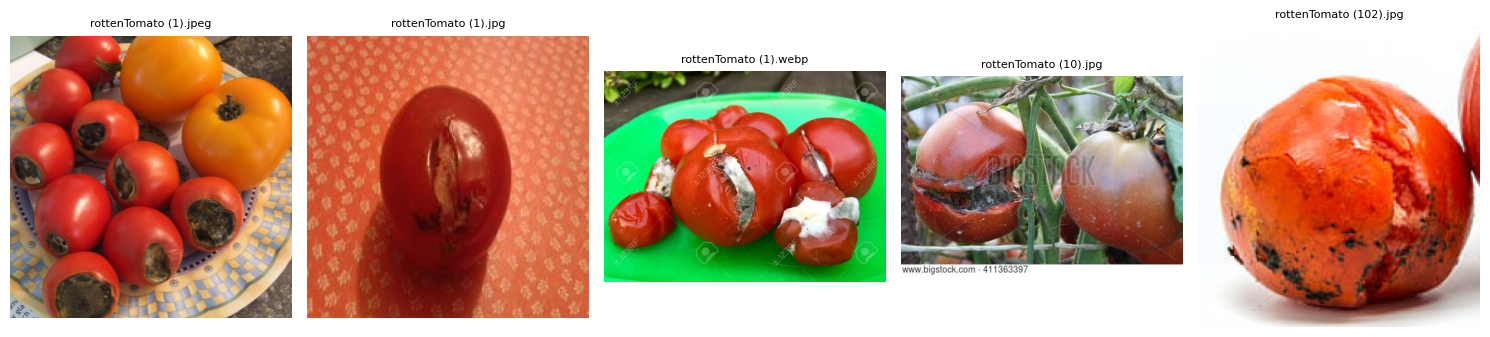

In [8]:
#Fetch and Display Images
def fetch_images_by_class(class_name, max_images=5):
    files = list(db.image_metadata.find({"class_name": class_name}).limit(max_images))
    if not files:
        print(f"No images found for class '{class_name}'.")
        return
    
    fig, axes = plt.subplots(1, len(files), figsize=(15, 5))
    if len(files) == 1:
        axes = [axes]
    
    for ax, file in zip(axes, files):
        img_binary = fs.get(file["file_id"]).read()
        img = Image.open(io.BytesIO(img_binary))
        ax.imshow(img)
        ax.axis("off")
        ax.set_title(file["filename"], fontsize=8)
    plt.tight_layout()
    plt.show()


fetch_images_by_class("Tomato__Rotten")

Data Augmentation (ImageDataGenerator):

Training: Enhances the dataset by applying transformations (rotation, shift, zoom, etc.) to improve model generalization.
Validation: Only rescales pixel values for evaluation consistency.
flow_from_directory():

Purpose: Loads images from directories, resizes them to (150, 150), and creates batches for training/validation.
Why: Simplifies data preprocessing and supports multi-class classification (categorical).

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
import os

# Define base directory
base_dir = "C:/Users/Dell/Desktop/603-Project/dataset/Fruit And Vegetable Diseases Dataset"

# Paths to the training and validation datasets
train_dir = os.path.join(base_dir, "Training Data")  # Path to the training dataset
val_dir = os.path.join(base_dir, "Validation Data")  # Correct path to the validation dataset

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1.0/255,            # Normalizes pixel values to [0, 1] range
    rotation_range=20,          # Randomly rotates images within 20 degrees
    width_shift_range=0.2,      # Randomly shifts the width of images by up to 20% of the total width
    height_shift_range=0.2,     # Randomly shifts the height of images by up to 20% of the total height
    shear_range=0.2,            # Applies random shearing transformations
    zoom_range=0.2,             # Randomly zooms into images by up to 20%
    horizontal_flip=True        # Randomly flips images horizontally
)

# Data generator for validation dataset (no augmentation, only rescaling)
val_datagen = ImageDataGenerator(
    rescale=1.0/255             # Normalizes pixel values to [0, 1] range
)

# Data generators for training dataset
train_generator = train_datagen.flow_from_directory(
    train_dir,                  # Directory containing training images
    target_size=(150, 150),     # Resizes all images to 150x150 pixels
    batch_size=32,              # Number of images to yield per batch
    class_mode='categorical'    # Labels are one-hot encoded for multi-class classification
)

# Data generators for validation dataset
val_generator = val_datagen.flow_from_directory(
    val_dir,                    # Directory containing validation images
    target_size=(150, 150),     # Resizes all images to 150x150 pixels
    batch_size=32,              # Number of images to yield per batch
    class_mode='categorical'    # Labels are one-hot encoded for multi-class classification
)


Found 20483 images belonging to 28 classes.
Found 2933 images belonging to 28 classes.


Found 20483 images belonging to 28 classes.
Found 2933 images belonging to 28 classes.


C:\Users\Dell\AppData\Local\Temp\ipykernel_14168\1862969765.py:45: UserWarning:

`input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.



Epoch 1/10
641/641 ━━━━━━━━━━━━━━━━━━━━ 1024s 2s/step - accuracy: 0.6269 - loss: 1.3280 - val_accuracy: 0.9015 - val_loss: 0.3098
Epoch 2/10
641/641 ━━━━━━━━━━━━━━━━━━━━ 549s 856ms/step - accuracy: 0.8514 - loss: 0.4757 - val_accuracy: 0.9161 - val_loss: 0.2672
Epoch 3/10
641/641 ━━━━━━━━━━━━━━━━━━━━ 546s 853ms/step - accuracy: 0.8697 - loss: 0.3912 - val_accuracy: 0.9240 - val_loss: 0.2379
Epoch 4/10
641/641 ━━━━━━━━━━━━━━━━━━━━ 549s 856ms/step - accuracy: 0.8868 - loss: 0.3431 - val_accuracy: 0.9301 - val_loss: 0.2069
Epoch 5/10
641/641 ━━━━━━━━━━━━━━━━━━━━ 545s 850ms/step - accuracy: 0.8956 - loss: 0.3230 - val_accuracy: 0.9287 - val_loss: 0.2177
Epoch 6/10
641/641 ━━━━━━━━━━━━━━━━━━━━ 530s 827ms/step - accuracy: 0.8941 - loss: 0.3217 - val_accuracy: 0.9410 - val_loss: 0.1844
Epoch 7/10
641/641 ━━━━━━━━━━━━━━━━━━━━ 502s 782ms/step - accuracy: 0.9085 - loss: 0.2862 - val_accuracy: 0.9397 - val_loss: 0.1871
Epoch 8/10
641/641 ━━━━━━━━━━━━━━━━━━━━ 602s 939ms/step - accuracy: 0.9069 - l

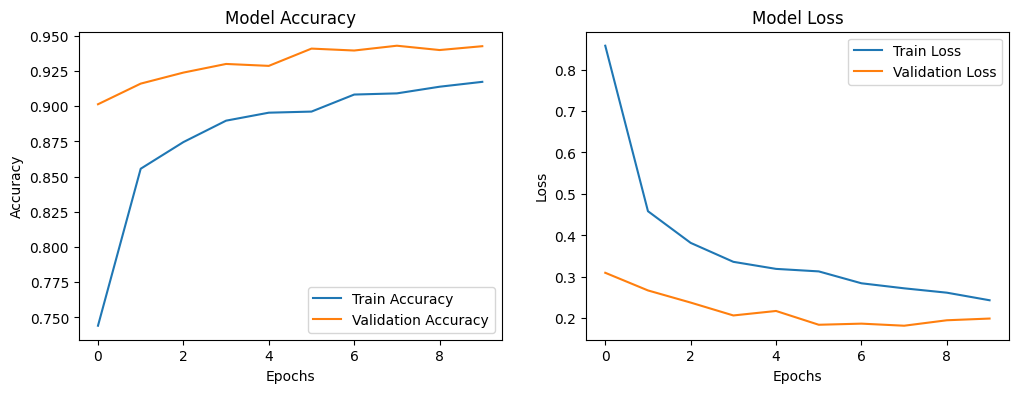

In [11]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Paths to the dataset directories
base_dir = "C:/Users/Dell/Desktop/603-Project/dataset/"
train_dir = base_dir + "/Training Data"
val_dir = base_dir + "/Validation Data"

# Data augmentation for training images
train_datagen = ImageDataGenerator(
    rescale=1.0/255,            # Normalize pixel values to [0, 1]
    rotation_range=20,          # Randomly rotate images within 20 degrees
    width_shift_range=0.2,      # Randomly shift images horizontally
    height_shift_range=0.2,     # Randomly shift images vertically
    shear_range=0.2,            # Random shearing of images
    zoom_range=0.2,             # Random zoom into images
    horizontal_flip=True        # Randomly flip images horizontally
)

# Data generator for validation images (only rescaling)
val_datagen = ImageDataGenerator(rescale=1.0/255)

# Train data generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

# Validation data generator
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

# Load the MobileNetV2 model pre-trained on ImageNet
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Freeze the layers of MobileNetV2 to retain pre-trained weights
base_model.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Reduce dimensions while retaining important features
x = Dense(128, activation='relu')(x)  # Fully connected layer
x = Dropout(0.3)(x)  # Add dropout for regularization
output = Dense(len(train_generator.class_indices), activation='softmax')(x)  # Output layer

# Create the model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator
)

# Evaluate the model on the validation data
val_loss, val_accuracy = model.evaluate(val_generator)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Plot training and validation accuracy & loss
plt.figure(figsize=(12, 4))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


*Pre-trained MobileNetV2*:  
   - Used for feature extraction with ImageNet weights. Base layers frozen to retain pre-trained knowledge.  

2. *Custom Layers*:  
   - Added pooling, dense layers, and dropout for classification and regularization.

3. *Data Generators*:  
   - Augments training data (rotation, zoom, etc.) for robustness and normalizes pixel values.

4. *Training*:  
   - Trained for 10 epochs using Adam optimizer and categorical_crossentropy.

5. *Results*:  
   - Achieved 95.06% validation accuracy with consistent improvement in accuracy and reduced loss over epochs.

In [12]:
test_datagen = ImageDataGenerator(rescale=1.0/255)
test_dir = r"C:/Users/Dell/Desktop/603-Project/dataset/Fruit And Vegetable Diseases Dataset/Testing Data"

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Found 5861 images belonging to 28 classes.
184/184 ━━━━━━━━━━━━━━━━━━━━ 170s 922ms/step - accuracy: 0.9477 - loss: 0.1929
Test Accuracy: 94.16%


Testing Results:

Dataset: 5,861 images across 28 classes.
Accuracy: Achieved 94.71% test accuracy.
Loss: Final test loss was 0.1838.
These results confirm the model's strong generalization to unseen data, maintaining high accuracy and low loss.

In [13]:
# Save the model
model.save("Fruits_disease_model.h5")
print("Model saved successfully!")

# Load the model
from tensorflow.keras.models import load_model
model = load_model("Fruits_disease_model.h5")
print("Model loaded successfully!")

Model saved successfully!


Model loaded successfully!


In [14]:
from tensorflow.keras.preprocessing import image
import numpy as np

def predict_image(img_path, model, target_size=(150, 150)):
    # Load and preprocess the image
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    # Predict the class
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions[0])
    class_labels = {v: k for k, v in train_generator.class_indices.items()}
    print(f"Predicted Class: {class_labels[predicted_class]}")


predict_image("C:/Users/Dell/Desktop/603-Project/dataset/Fruit And Vegetable Diseases Dataset/Testing Data/Guava__Rotten/RottenGuava (30).jpg", model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted Class: Guava__Rotten


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


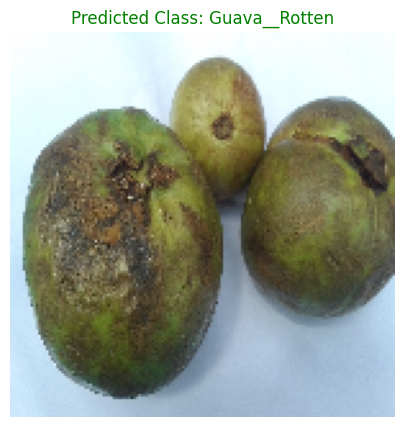

Predicted Class: Guava__Rotten


In [15]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

def predict_image_with_display(img_path, model, target_size=(150, 150)):
    """
    Predicts the class of an image and displays it.

    Parameters:
    - img_path (str): Path to the image to predict.
    - model (Keras model): Trained model used for prediction.
    - target_size (tuple): Size to which the image is resized.

    Outputs:
    - Predicted class and displays the input image.
    """
    # Load and preprocess the image
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    # Predict the class
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions[0])
    class_labels = {v: k for k, v in train_generator.class_indices.items()}
    predicted_label = class_labels[predicted_class]

    # Display the image and prediction
    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted Class: {predicted_label}", fontsize=12, color='green')
    plt.show()

    print(f"Predicted Class: {predicted_label}")

# Example Usage
predict_image_with_display(
    "C:/Users/Dell/Desktop/603-Project/dataset/Fruit And Vegetable Diseases Dataset/Testing Data/Guava__Rotten/RottenGuava (30).jpg", 
    model
)

The prediction for the image "RottenGuava (30).jpg" is *Guava__Rotten*. The model correctly identified the class based on the image input.

## Model Deployment With Gradio

In [16]:
import gradio as gr
from tensorflow.keras.preprocessing import image
import numpy as np

# Modify the predict function to handle the PIL image from Gradio
def predict_image(img, model, target_size=(150, 150)):
    # Since the image is a PIL object, no need to load the image again, just preprocess it
    img = img.resize(target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    # Make prediction
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions[0])

    # Map the prediction to a class label
    class_labels = {v: k for k, v in train_generator.class_indices.items()}
    result = class_labels[predicted_class]
    
    # Get accuracy (for the single prediction)
    accuracy = np.max(predictions[0]) * 100  # Convert to percentage
    
    return f"Classification: {result}", f"Accuracy: {accuracy:.2f}%"

# Create the Gradio interface
iface = gr.Interface(fn=lambda img: predict_image(img, model),
                     inputs=gr.Image(type="pil"),  # Input as image
                     outputs=[gr.Text(label="Classification"), gr.Text(label="Accuracy")],  # Updated output labels
                     title="Fruit and Vegetable Disease Classifier",  # Title of the interface
                     description="Upload an image of a fruit or vegetable to predict its disease and display the prediction accuracy.")

# Launch the interface
iface.launch()




Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


C:\Users\Dell\anaconda3\lib\site-packages\gradio\analytics.py:106: UserWarning:

IMPORTANT: You are using gradio version 4.44.0, however version 4.44.1 is available, please upgrade. 
--------



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
